In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
from pathlib import Path
import json

In [2]:
def df_to_delta(df):
    sps_gtr = 17.95
    sps_g0 = 27.643
    f0 = 200e6
    eta = 1/sps_gtr**2 - 1/sps_g0**2
    return -df/(f0*eta)

In [3]:
def remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2):
    "Remove apertures of off-momentum BPMs which give flanges as bottlenecks"
    tt = line.get_table()
    tw = line.twiss()
    mask_disp = 5*np.sqrt(tw.betx*exn*pmass/nrj)+n_buckets*bucket_height*tw.dx > 0.025
    mask_bpm = ['bp' in name for name in tt.name]
    mask_aper = np.array(['aper' in name for name in tt.name])
    offmom_bpms = tt.name[mask_disp & mask_bpm & ~mask_aper]
    aper_to_remove = [f'{name}{suffix}' for name in offmom_bpms for suffix in ('.a_aper', '.b_aper')]
    line.remove(aper_to_remove)

In [4]:
class SweepLosses:
    def __init__(self, line, sweep, plane, num_turns, num_particles=100, nemitt_x=3.5e-6, nemitt_y=3.5e-6, result_name=None, dir=None, gaussian=False):
        self.line = line
        self.plane = plane
        self.sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
        self.num_turns = num_turns
        self.sweep_per_turn = self.sweep/self.num_turns

        self.num_particles = num_particles
        self.gaussian = gaussian

        self.nemitt_x = nemitt_x
        self.nemitt_y = nemitt_y
        if dir is None:
            self.dir = Path.cwd
        else:
            self.dir = dir

        if result_name is None:
            print("WARNING: No result_name provided, using default 'sweep_losses'")
            self.result_name = 'sweep_losses'
        else:
            self.result_name = result_name
        
        self.savedir = Path(self.dir/self.result_name/self.plane)
        Path(self.savedir).mkdir(parents=True, exist_ok=True)
        
        self.track()

    def make_particles(self):
        if not self.gaussian:
            x_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))
            y_spacing = np.linspace(-0.025, 0.025, int(np.sqrt(self.num_particles)))

            X, Y = np.meshgrid(x_spacing, y_spacing, indexing='xy')
            x_norm = X.ravel()
            y_norm = Y.ravel()

            px_norm = np.zeros_like(x_norm)
            py_norm = np.zeros_like(x_norm)
            tw = self.line.twiss()
            zeta = np.ones_like(x_norm)*tw.particle_on_co.zeta
            delta = np.ones_like(x_norm)*tw.particle_on_co.delta

            return self.line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm, nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y, zeta=zeta, delta=delta)
        else:
            return xp.generate_matched_gaussian_bunch(nemitt_x=self.nemitt_x,
                                          nemitt_y=self.nemitt_y,
                                          sigma_z=0.224, num_particles=self.num_particles, line=self.line)

    def track(self):
        tw = self.line.twiss()
        tt = self.line.get_table()
        self.line.collimators.assign_optics(nemitt_x=self.nemitt_x, nemitt_y=self.nemitt_y)
        self.part = self.make_particles()

        self.line.discard_tracker()
        self.line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))
        rf_sweep = xc.RFSweep(self.line)
        rf_sweep.prepare(sweep_per_turn=self.sweep/self.num_turns)
        rf_sweep.info()
        self.line.scattering.enable()
        self.line.track(particles=self.part, num_turns=self.num_turns, time=True, with_progress=5)
        self.line.scattering.disable()
        print(f"Done sweeping RF in {self.line.time_last_track:.1f}s.")

        self.line.discard_tracker()
        self.line.build_tracker()


    @property
    def aperture_losses(self):
        loss_idxs, loss_counts = np.unique(self.part.at_element, return_counts=True)

        aper_losses = {}
        for idx, count in zip(loss_idxs, loss_counts):
            aper_losses[self.line.element_names[idx]] = int(count)

        json.dump(aper_losses, open(Path(self.savedir)/f'{self.result_name}_aper_losses.json', 'w'), indent=4)
        return aper_losses
    
    @property
    def plot_lossmap(self):
        self.ThisLM = xc.LossMap(self.line, line_is_reversed=False, part=self.part, interpolation=False)
        self.ThisLM.to_json(Path(self.savedir/f'LM_{self.result_name}.json'))
        self.ThisLM.plot(savefig=Path(self.savedir/f'LM_{self.result_name}.pdf'))
    
    @property
    def intensity_loss(self):
        fig, ax = plt.subplots(figsize=(12,6))
        turns, counts = np.unique(self.part.at_turn, return_counts=True)
        dic = {int(turn): int(count) for turn, count in zip(turns, counts)}
        dic['num_particles'] = self.num_particles
        dic['sweep_per_turn'] = self.sweep_per_turn
        json.dump(dic, open(Path(self.savedir)/f'IntensityLoss_{self.result_name}.json', 'w'), indent=4)
        ax.plot(df_to_delta(self.sweep_per_turn*turns)*1e3, 1-np.cumsum(counts)/self.num_particles, marker='o', color='royalblue')
        ax.grid()
        ax.set_xlabel(r'$\delta$ $[10^{-3}]$', fontsize=14)
        ax.set_ylabel('Normalised lost intensity', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=12)
        fig.tight_layout()
        fig.savefig(Path(self.savedir/f'IntensityLoss_{self.result_name}.pdf'), dpi=300)
        plt.show()
        return turns, counts
    

    def plot_loss_histogram(self, title="Losses per Element", top_n=None):
        # Optionally limit to top N elements by count
        aper_losses = self.aperture_losses
        items = sorted(aper_losses.items(), key=lambda x: x[1], reverse=True)
        if top_n is not None:
            items = items[:top_n]

        elements, counts = zip(*items)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(range(len(elements)), counts, color="steelblue")
        ax.set_xticks(range(len(elements)))
        ax.set_xticklabels(elements, rotation=90)
        ax.set_xlabel("Element name")
        ax.set_ylabel("Number of losses")
        ax.set_title(title)
        fig.tight_layout()

        return fig, ax

In [5]:
cases = {
    'case0' : {},
    'case1' : {'vcak.52501.a_aper' : -1e-3},
    'case2' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3},
    'case3' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3},
    'case4' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3},
    'case5' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3},
    'case6' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3},
    'case6_bis' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3, 'vcak.61101.a_aper' : 1e-3},
    'case7' : {'vcak.52501.a_aper' : -1e-3, 'vcak.22501.a_aper' : -1e-3, 'vcak.52501.b_aper' : -1e-3, 'vcak.12501.a_aper' : -1e-3, 'vtto.52505.a_aper' : -1e-3, 'lsd.52505.a_aper' : -1e-3, 'vcak.22501.b_aper' : -1e-3, 'vtto.22505.a_aper' : -1e-3},
}

In [6]:
np.linspace(0, 20e-3, 11)

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 ])

In [7]:
bump = 1e-3
print(f'bump_{bump*1e3:.0f}mm')

bump_1mm


##################################
qd.20110 0.0
##################################
 
DPpos


<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:26: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
<>:30: SyntaxWarning: invalid escape sequence '\.'
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_1880/282255688.py:26: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_1880/282255688.py:26: SyntaxWarning: invalid escape sequence '\.'
  tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipykernel_1880/282255688.py:30: SyntaxWarning: invalid escape sequence '\.'
  tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
/var/folders/b5/swvf1qzj6l36gcd1zzs4_g8h0000gn/T/ipy

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.22e-03 -> 2.88e-04, y_rms: 9.78e-05 -> 1.78e-05
Iteration 1, x_rms: 2.88e-04 -> 2.20e-04, y_rms: 1.78e-05 -> 1.30e-05
Iteration 2, x_rms: 2.20e-04 -> 1.87e-04, y_rms: 1.30e-05 -> 1.08e-05
Iteration 3, x_rms: 1.87e-04 -> 1.58e-04, y_rms: 1.08e-05 -> 8.80e-06
Iteration 4, x_rms: 1.58e-04 -> 1.38e-04, y_rms: 8.80e-06 -> 7.86e-06
Iteration 5, x_rms: 1.38e-04 -> 1.34e-04, y_rms: 7.86e-06 -> 7.45e-06
Iteration 6, x_rms: 1.34e-04 -> 1.28e-04, y_rms: 7.45e-06 -> 5.75e-06
Iteration 7, x_rms: 1.28e-04 -> 1.22e-04, y_rms: 5.75e-06 -> 5.26e-06
Iteration 8, x_rms: 1.22e-04 -> 1.19e-04, y_rms: 5.26e-06 -> 4.43e-06
Iteration 9, x_rms: 1.19e-04 -> 1.16e-04, y_rms: 4.43e-06 -> 4.08e-06


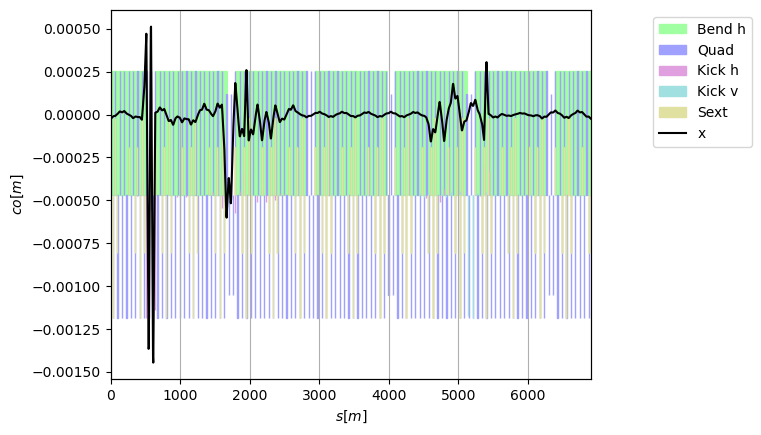

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.2809006924399915
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 91.0s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'sps$start': 1, 'vcak.21101.a_aper': 13, 'vtto.31105.a_aper': 10, 'vcak.51101.a_aper': 11, 'vcak.52501.a_aper': 3, 'vcak.61101.a_aper': 62}


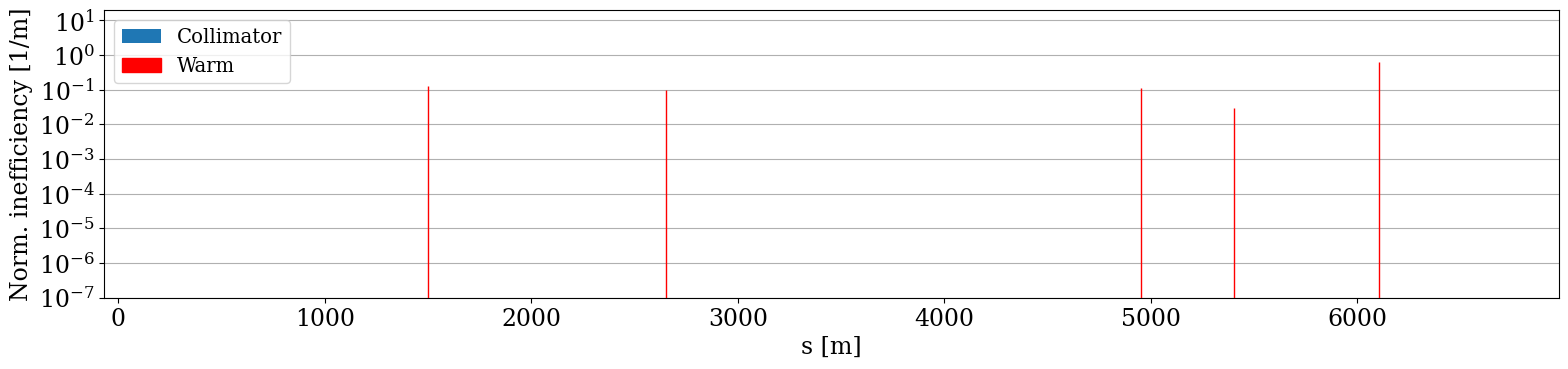

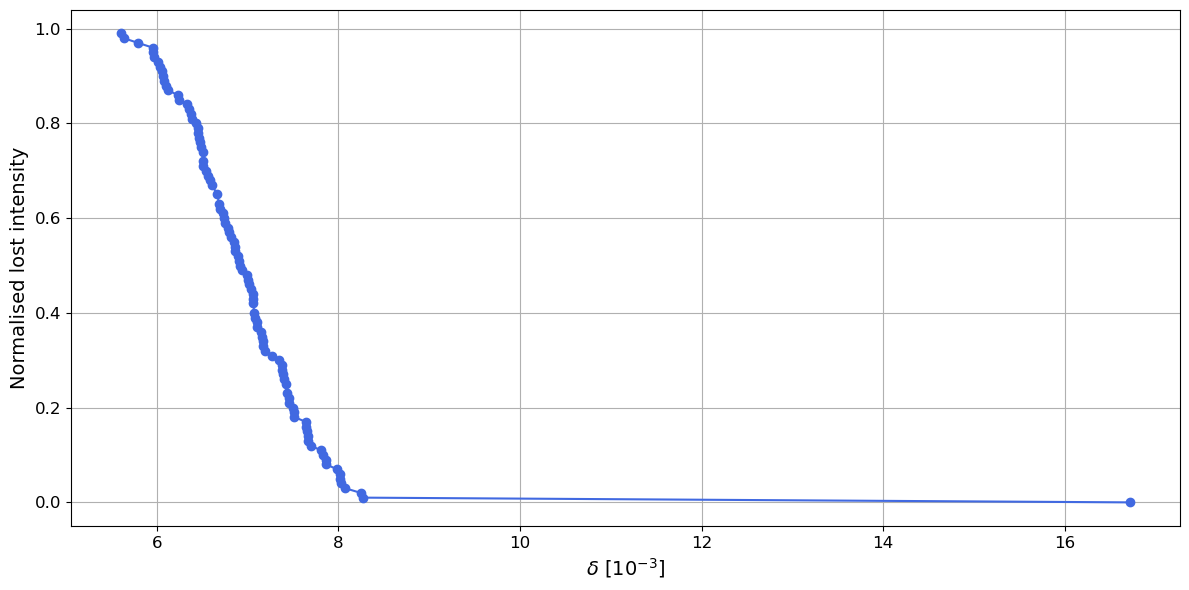

##################################
qd.20110 0.002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 5.24e-03 -> 2.46e-04, y_rms: 9.78e-05 -> 1.78e-05
Iteration 1, x_rms: 2.46e-04 -> 2.29e-04, y_rms: 1.78e-05 -> 1.30e-05
Iteration 2, x_rms: 2.29e-04 -> 2.09e-04, y_rms: 1.30e-05 -> 1.08e-05
Iteration 3, x_rms: 2.09e-04 -> 1.84e-04, y_rms: 1.08e-05 -> 9.22e-06
Iteration 4, x_rms: 1.84e-04 -> 1.74e-04, y_rms: 9.22e-06 -> 8.37e-06
Iteration 5, x_rms: 1.74e-04 -> 1.45e-04, y_rms: 8.37e-06 -> 7.57e-06
Iteration 6, x_rms: 1.45e-04 -> 1.41e-04, y_rms: 7.57e-06 -> 6.66e-06
Iteration 7, x_rms: 1.41e-04 -> 1.39e-04, y_rms: 6.66e-06 -> 6.11e-06
Iteration 8, x_rms: 1.39e-04 -> 1.32e-04, y_rms: 6.11e-06 -> 5.72e-06
Iteration 9, x_rms: 1.32e-04 -> 1.28e-04, y_rms: 5.72e-06 -> 5.13e-06


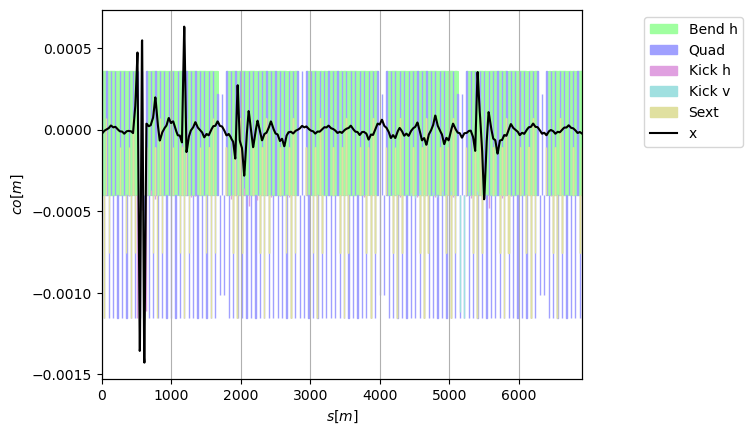

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.28090116872589094
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.08 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 83.5s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'vcak.21101.a_aper': 14, 'vtto.31105.a_aper': 17, 'vcak.51101.a_aper': 7, 'vcak.52501.a_aper': 8, 'vcak.61101.a_aper': 54}


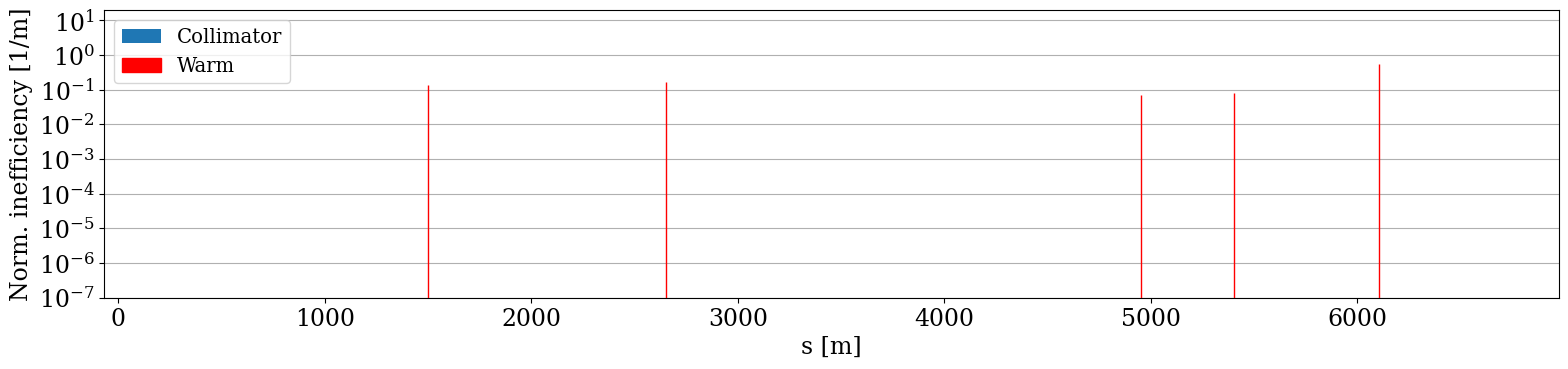

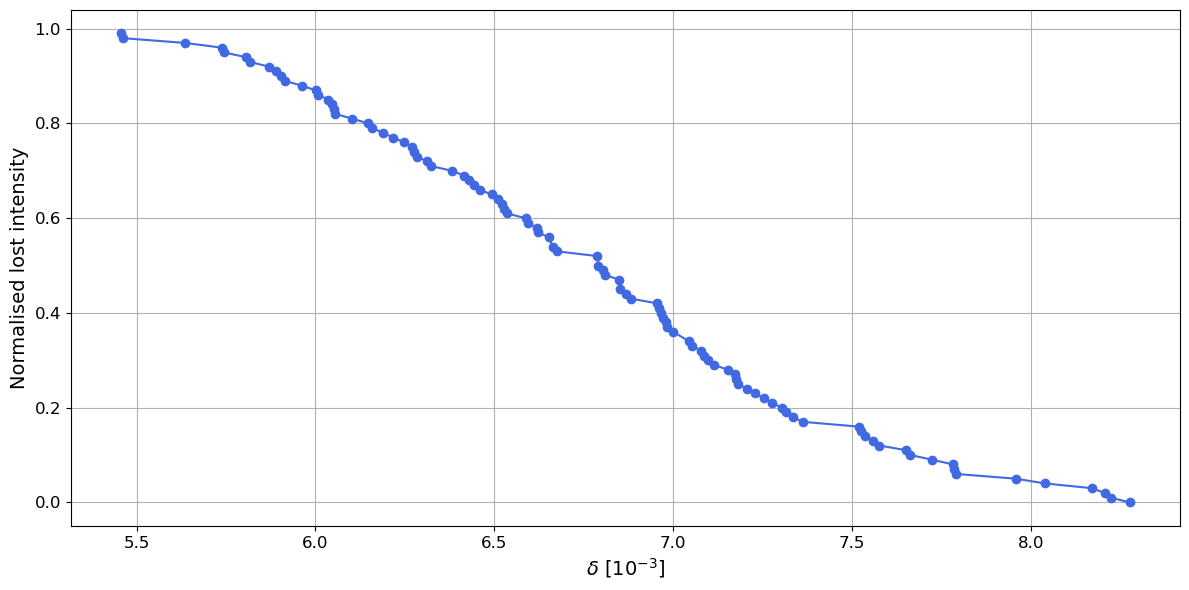

##################################
qd.20110 0.004
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 8.21e-03 -> 2.77e-04, y_rms: 9.78e-05 -> 4.64e-05
Iteration 1, x_rms: 2.77e-04 -> 2.43e-04, y_rms: 4.64e-05 -> 2.54e-05
Iteration 2, x_rms: 2.43e-04 -> 2.16e-04, y_rms: 2.54e-05 -> 1.79e-05
Iteration 3, x_rms: 2.16e-04 -> 1.80e-04, y_rms: 1.79e-05 -> 1.57e-05
Iteration 4, x_rms: 1.80e-04 -> 1.54e-04, y_rms: 1.57e-05 -> 1.20e-05
Iteration 5, x_rms: 1.54e-04 -> 1.50e-04, y_rms: 1.20e-05 -> 9.09e-06
Iteration 6, x_rms: 1.50e-04 -> 1.47e-04, y_rms: 9.09e-06 -> 8.41e-06
Iteration 7, x_rms: 1.47e-04 -> 1.46e-04, y_rms: 8.41e-06 -> 7.83e-06
Iteration 8, x_rms: 1.46e-04 -> 1.44e-04, y_rms: 7.83e-06 -> 7.50e-06
Iteration 9, x_rms: 1.44e-04 -> 1.44e-04, y_rms: 7.50e-06 -> 6.23e-06


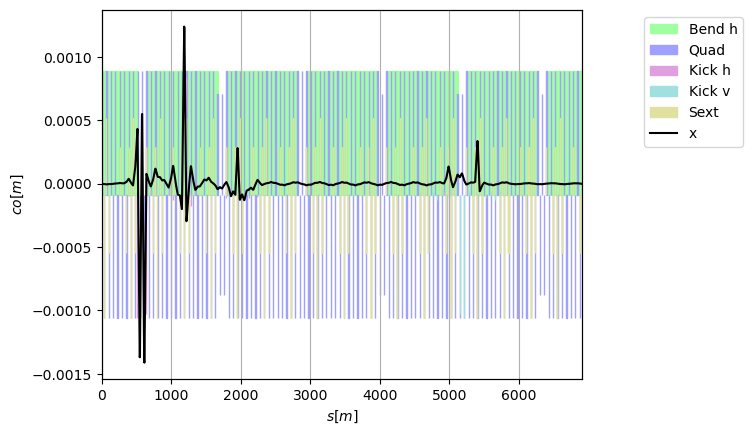

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.2808966537424927
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.12 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 85.6s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 28, 'vcak.21101.a_aper': 6, 'vtto.31105.a_aper': 13, 'vcak.51101.a_aper': 3, 'vcak.52501.a_aper': 11, 'vcak.61101.a_aper': 39}


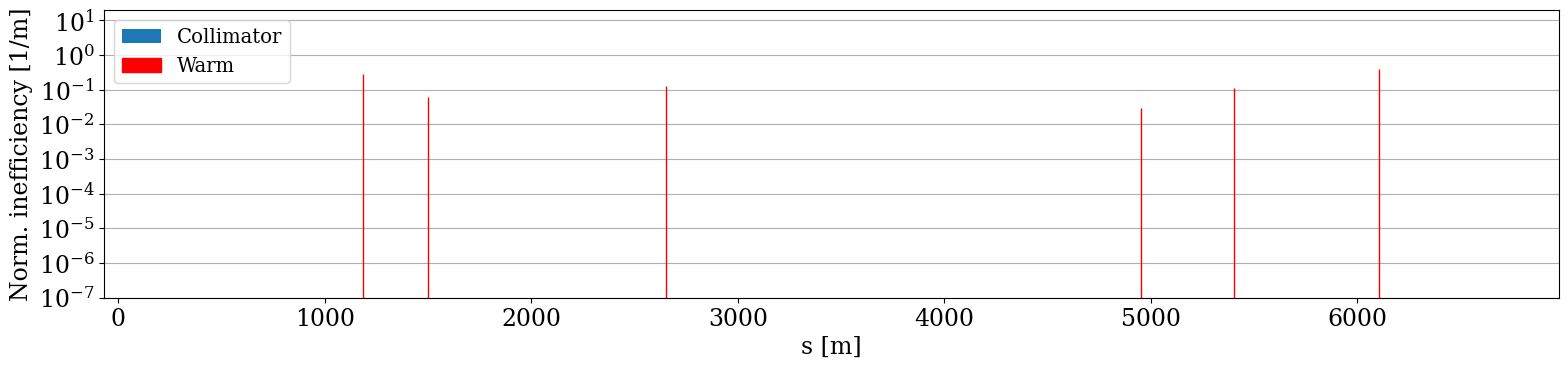

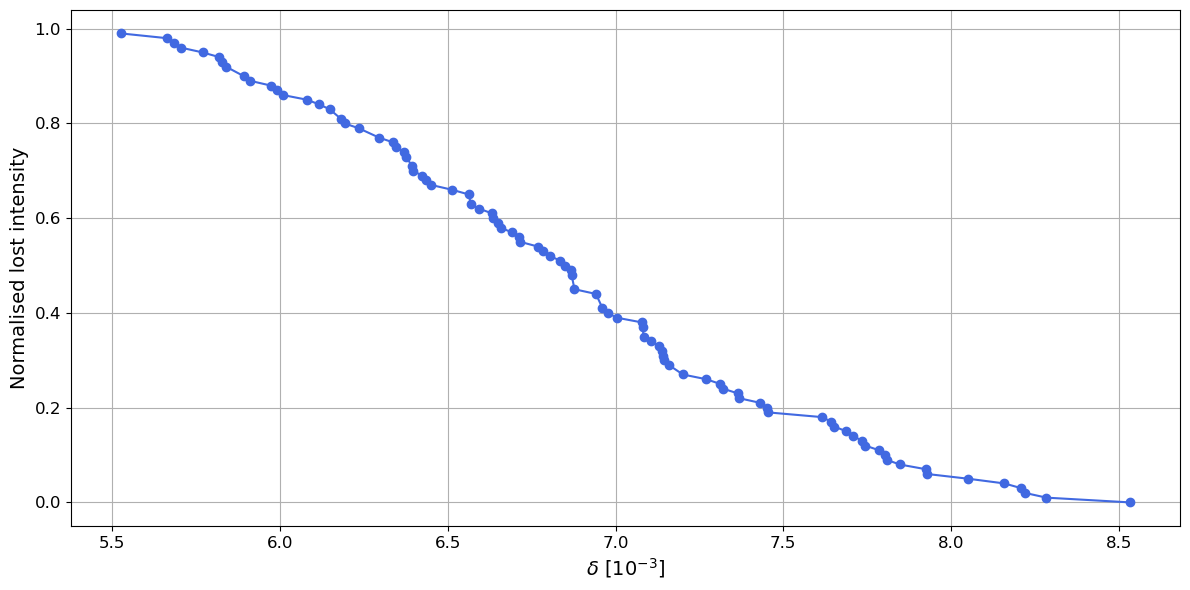

##################################
qd.20110 0.006
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.14e-02 -> 3.83e-04, y_rms: 9.78e-05 -> 4.64e-05
Iteration 1, x_rms: 3.83e-04 -> 2.81e-04, y_rms: 4.64e-05 -> 2.54e-05
Iteration 2, x_rms: 2.81e-04 -> 2.26e-04, y_rms: 2.54e-05 -> 1.79e-05
Iteration 3, x_rms: 2.26e-04 -> 2.05e-04, y_rms: 1.79e-05 -> 1.57e-05
Iteration 4, x_rms: 2.05e-04 -> 1.96e-04, y_rms: 1.57e-05 -> 1.20e-05
Iteration 5, x_rms: 1.96e-04 -> 1.86e-04, y_rms: 1.20e-05 -> 9.09e-06
Iteration 6, x_rms: 1.86e-04 -> 1.84e-04, y_rms: 9.09e-06 -> 8.41e-06
Iteration 7, x_rms: 1.84e-04 -> 1.82e-04, y_rms: 8.41e-06 -> 7.83e-06
Iteration 8, x_rms: 1.82e-04 -> 1.80e-04, y_rms: 7.83e-06 -> 7.50e-06
Iteration 9, x_rms: 1.80e-04 -> 1.78e-04, y_rms: 7.50e-06 -> 6.23e-06


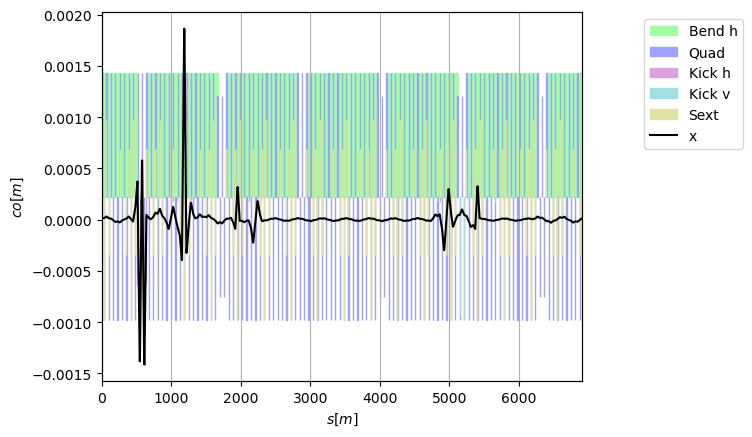

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.2808947882583575
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.13 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 77.2s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


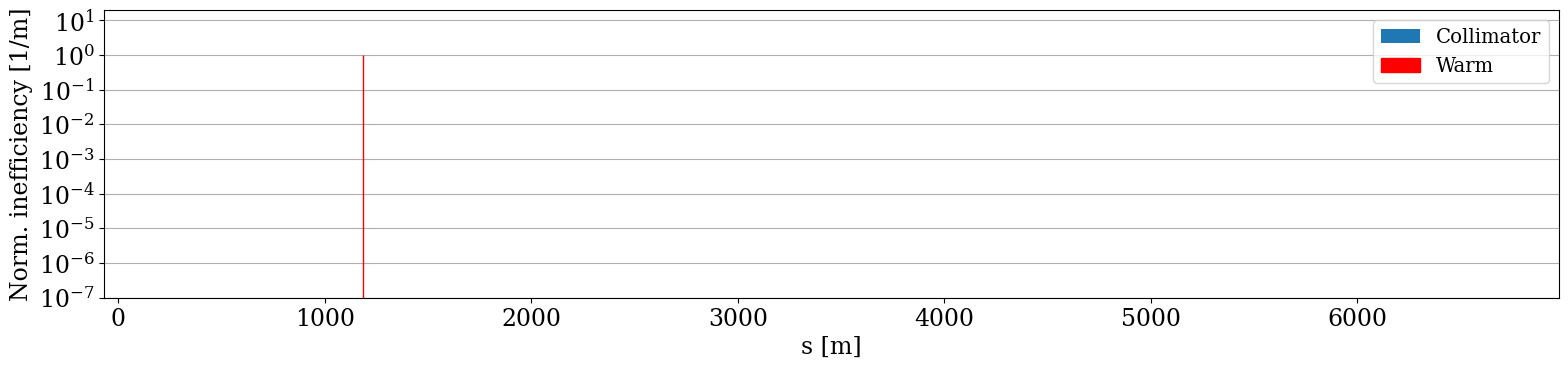

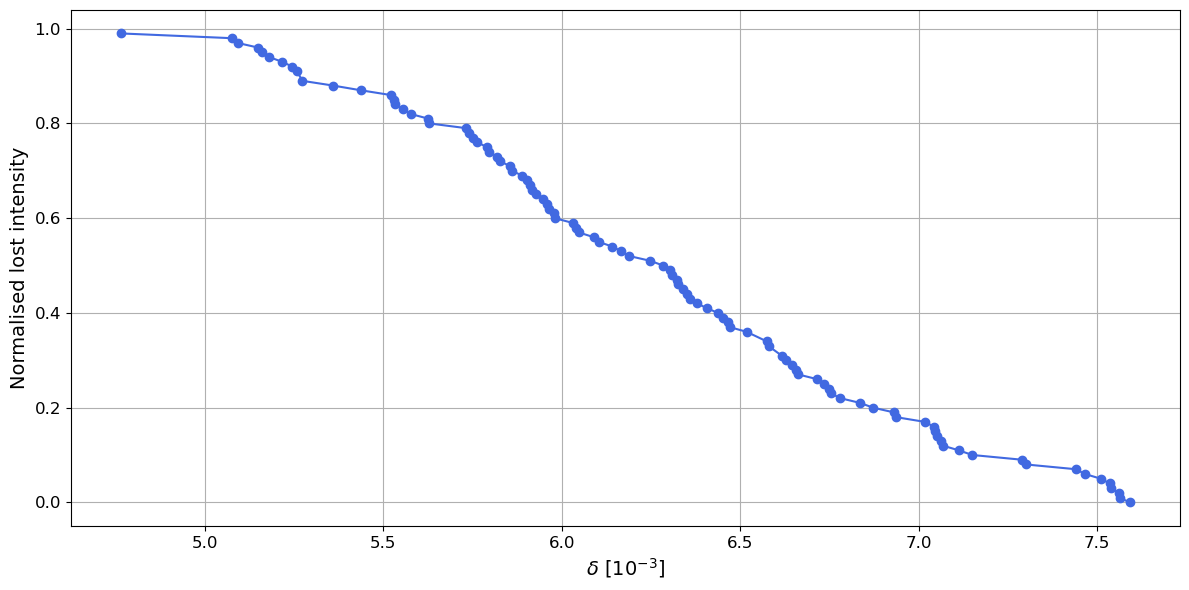

##################################
qd.20110 0.008
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.47e-02 -> 5.27e-04, y_rms: 9.78e-05 -> 4.64e-05
Iteration 1, x_rms: 5.27e-04 -> 3.30e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 3.30e-04 -> 2.70e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 2.70e-04 -> 2.47e-04, y_rms: 2.15e-05 -> 2.01e-05
Iteration 4, x_rms: 2.47e-04 -> 2.38e-04, y_rms: 2.01e-05 -> 1.91e-05
Iteration 5, x_rms: 2.38e-04 -> 2.35e-04, y_rms: 1.91e-05 -> 1.69e-05
Iteration 6, x_rms: 2.35e-04 -> 2.19e-04, y_rms: 1.69e-05 -> 1.62e-05
Iteration 7, x_rms: 2.19e-04 -> 2.18e-04, y_rms: 1.62e-05 -> 1.33e-05
Iteration 8, x_rms: 2.18e-04 -> 2.17e-04, y_rms: 1.33e-05 -> 1.19e-05
Iteration 9, x_rms: 2.17e-04 -> 2.15e-04, y_rms: 1.19e-05 -> 1.07e-05


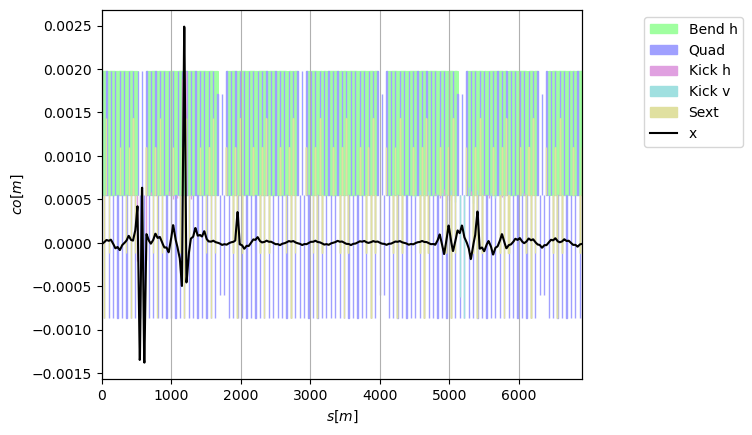

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.2808911148705955
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.16 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 71.5s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


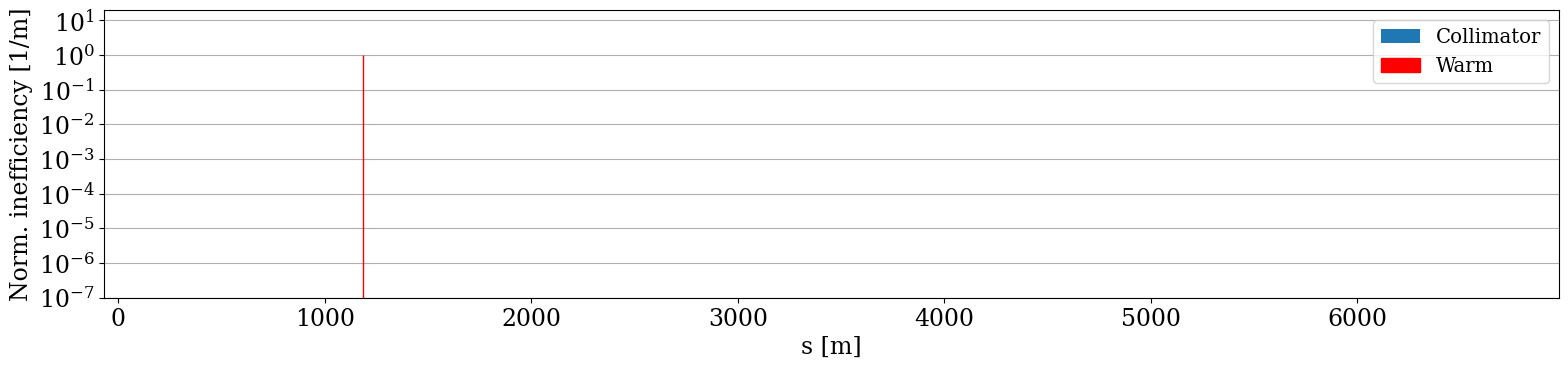

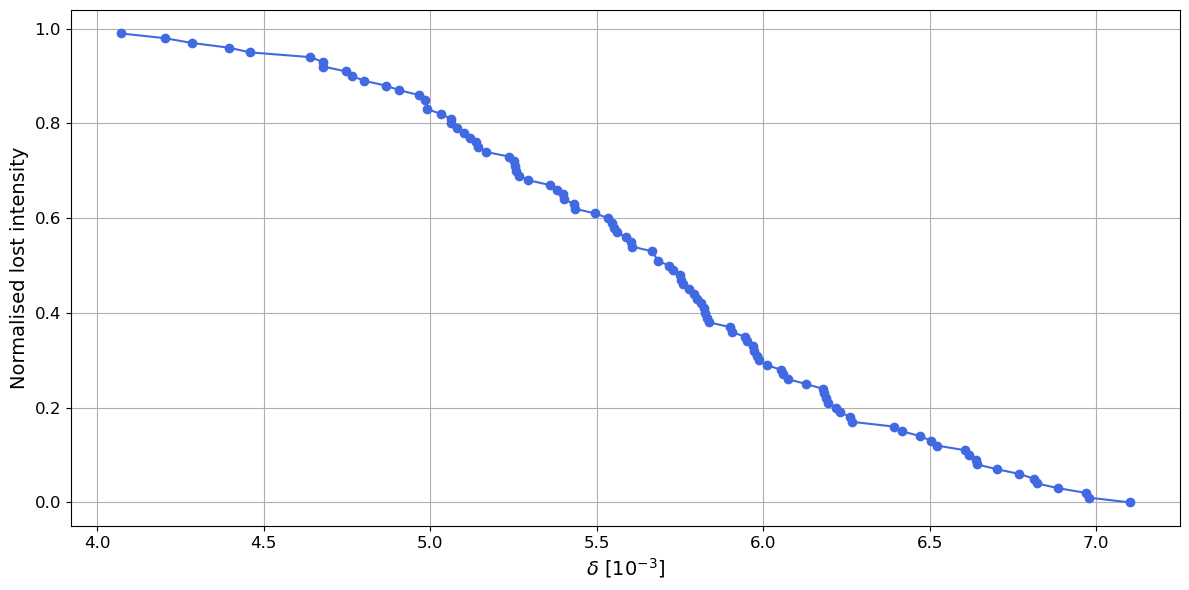

##################################
qd.20110 0.01
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.81e-02 -> 6.32e-04, y_rms: 9.79e-05 -> 4.64e-05
Iteration 1, x_rms: 6.32e-04 -> 3.86e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 3.86e-04 -> 3.25e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 3.25e-04 -> 2.97e-04, y_rms: 2.15e-05 -> 1.91e-05
Iteration 4, x_rms: 2.97e-04 -> 2.82e-04, y_rms: 1.91e-05 -> 1.62e-05
Iteration 5, x_rms: 2.82e-04 -> 2.74e-04, y_rms: 1.62e-05 -> 1.42e-05
Iteration 6, x_rms: 2.74e-04 -> 2.66e-04, y_rms: 1.42e-05 -> 1.22e-05
Iteration 7, x_rms: 2.66e-04 -> 2.60e-04, y_rms: 1.22e-05 -> 1.10e-05
Iteration 8, x_rms: 2.60e-04 -> 2.59e-04, y_rms: 1.10e-05 -> 1.05e-05
Iteration 9, x_rms: 2.59e-04 -> 2.58e-04, y_rms: 1.05e-05 -> 1.01e-05


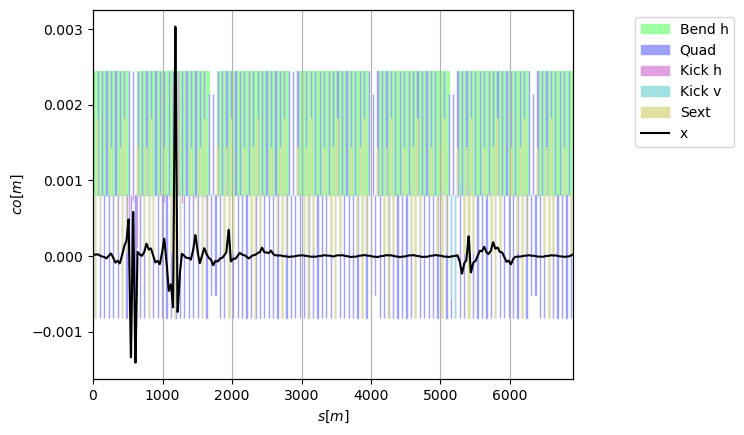

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.28088122332933246
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.23 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 62.7s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


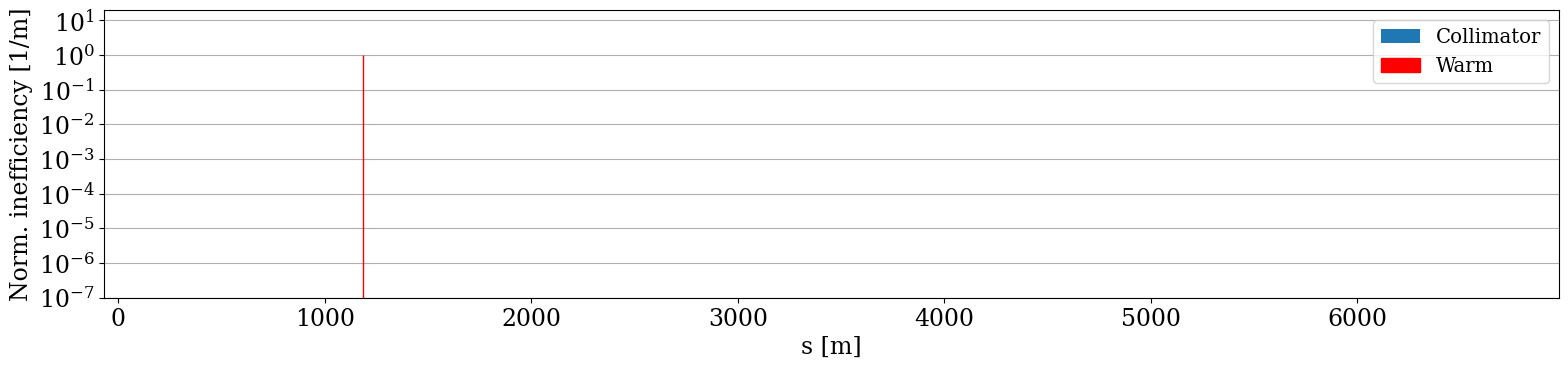

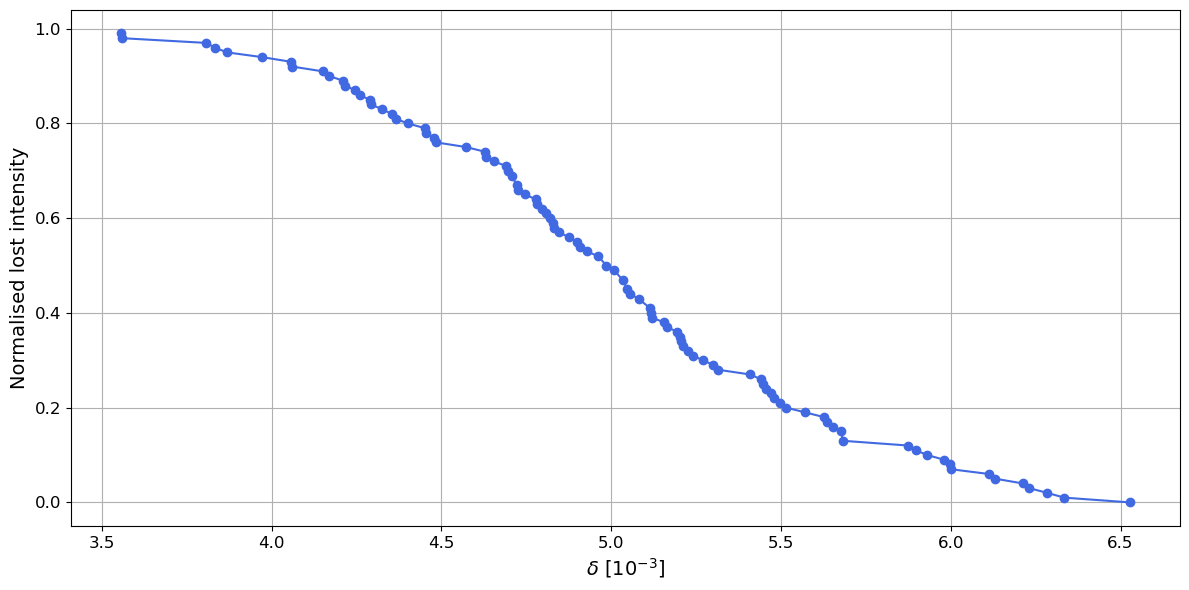

##################################
qd.20110 0.012
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.16e-02 -> 7.74e-04, y_rms: 9.79e-05 -> 4.64e-05
Iteration 1, x_rms: 7.74e-04 -> 4.13e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 4.13e-04 -> 3.70e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 3.70e-04 -> 3.33e-04, y_rms: 2.15e-05 -> 1.91e-05
Iteration 4, x_rms: 3.33e-04 -> 3.12e-04, y_rms: 1.91e-05 -> 1.62e-05
Iteration 5, x_rms: 3.12e-04 -> 3.05e-04, y_rms: 1.62e-05 -> 1.42e-05
Iteration 6, x_rms: 3.05e-04 -> 3.01e-04, y_rms: 1.42e-05 -> 1.22e-05
Iteration 7, x_rms: 3.01e-04 -> 3.00e-04, y_rms: 1.22e-05 -> 1.10e-05
Iteration 8, x_rms: 3.00e-04 -> 2.99e-04, y_rms: 1.10e-05 -> 1.05e-05
Iteration 9, x_rms: 2.99e-04 -> 2.99e-04, y_rms: 1.05e-05 -> 1.01e-05


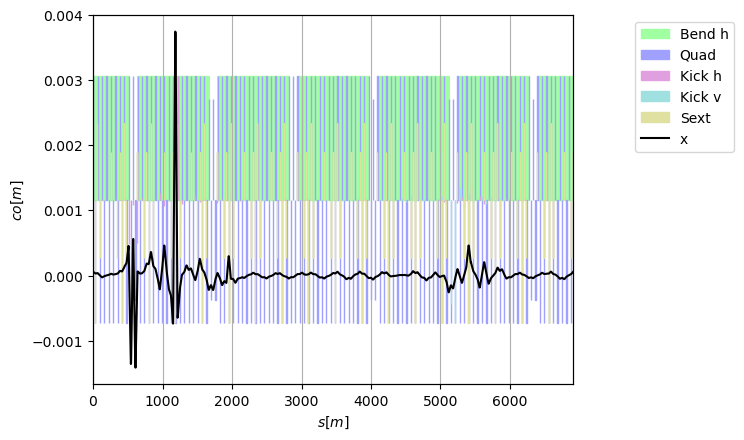

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.2808870522774525
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.19 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 55.7s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


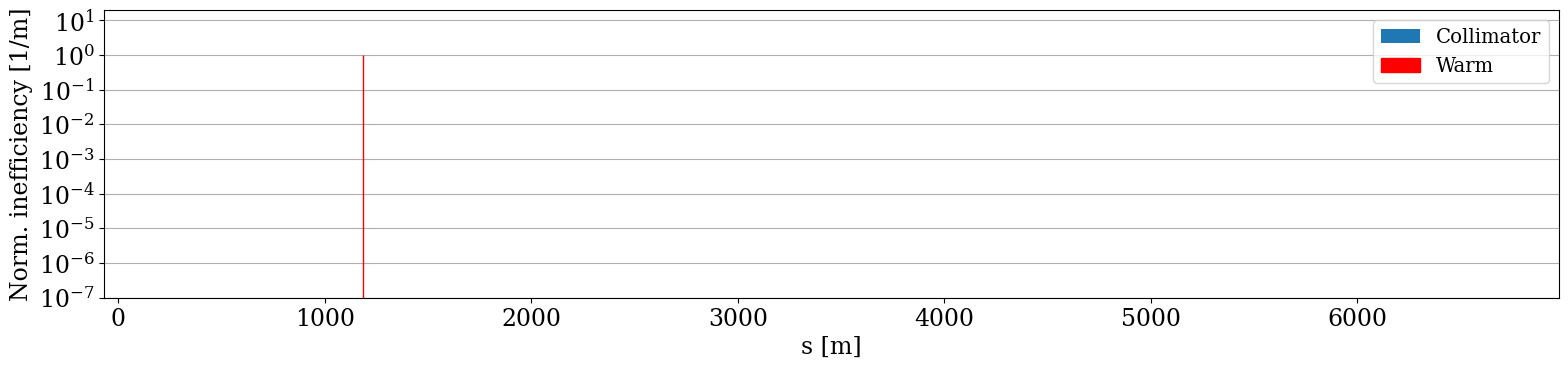

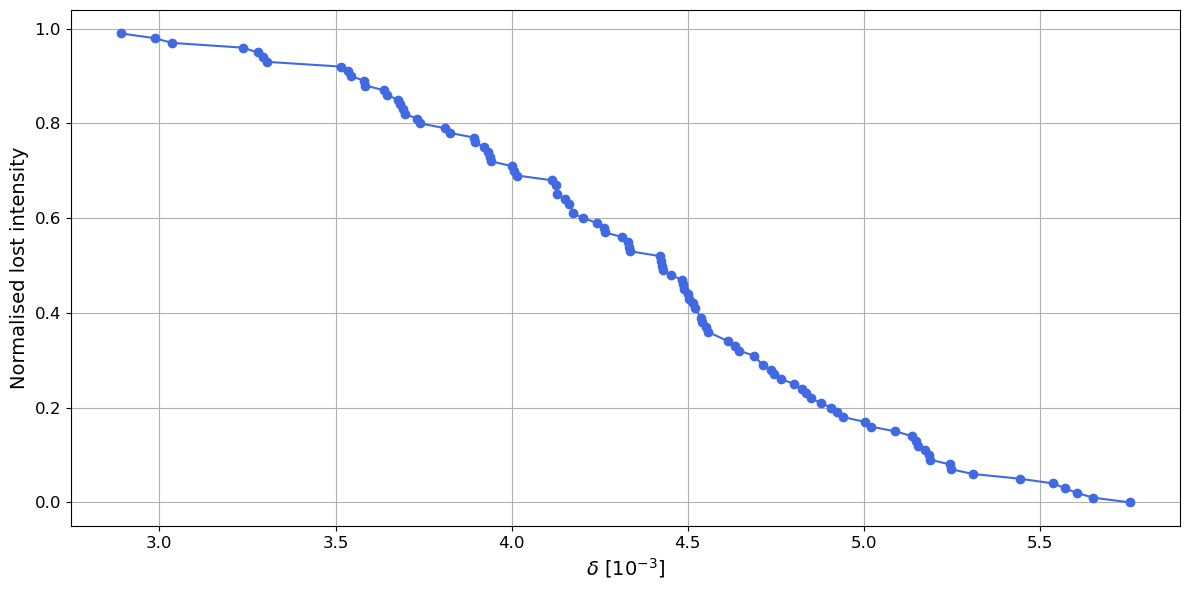

##################################
qd.20110 0.014
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.50e-02 -> 9.57e-04, y_rms: 9.79e-05 -> 4.64e-05
Iteration 1, x_rms: 9.57e-04 -> 4.50e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 4.50e-04 -> 3.85e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 3.85e-04 -> 3.58e-04, y_rms: 2.15e-05 -> 1.91e-05
Iteration 4, x_rms: 3.58e-04 -> 3.53e-04, y_rms: 1.91e-05 -> 1.62e-05
Iteration 5, x_rms: 3.53e-04 -> 3.49e-04, y_rms: 1.62e-05 -> 1.42e-05
Iteration 6, x_rms: 3.49e-04 -> 3.46e-04, y_rms: 1.42e-05 -> 1.22e-05
Iteration 7, x_rms: 3.46e-04 -> 3.44e-04, y_rms: 1.22e-05 -> 1.10e-05
Iteration 8, x_rms: 3.44e-04 -> 3.38e-04, y_rms: 1.10e-05 -> 1.05e-05
Iteration 9, x_rms: 3.38e-04 -> 3.37e-04, y_rms: 1.05e-05 -> 1.01e-05


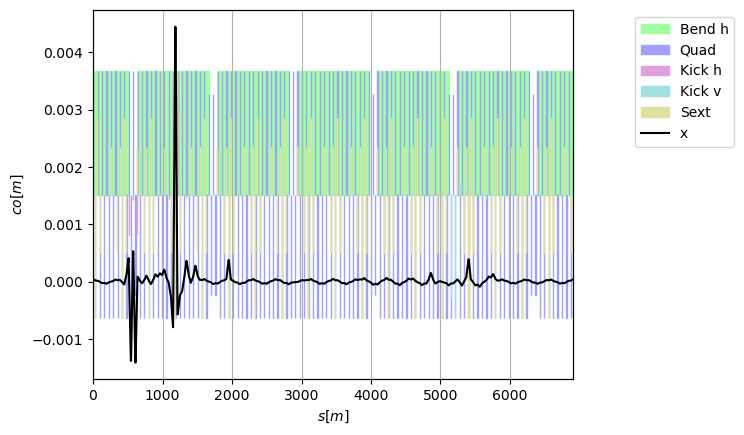

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28087471080626686
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.28 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 46.4s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


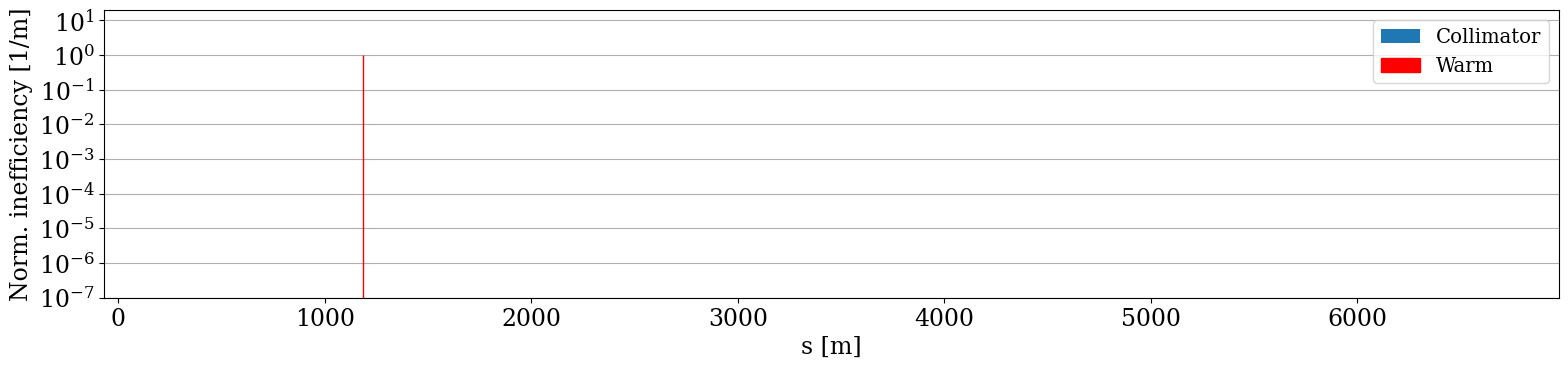

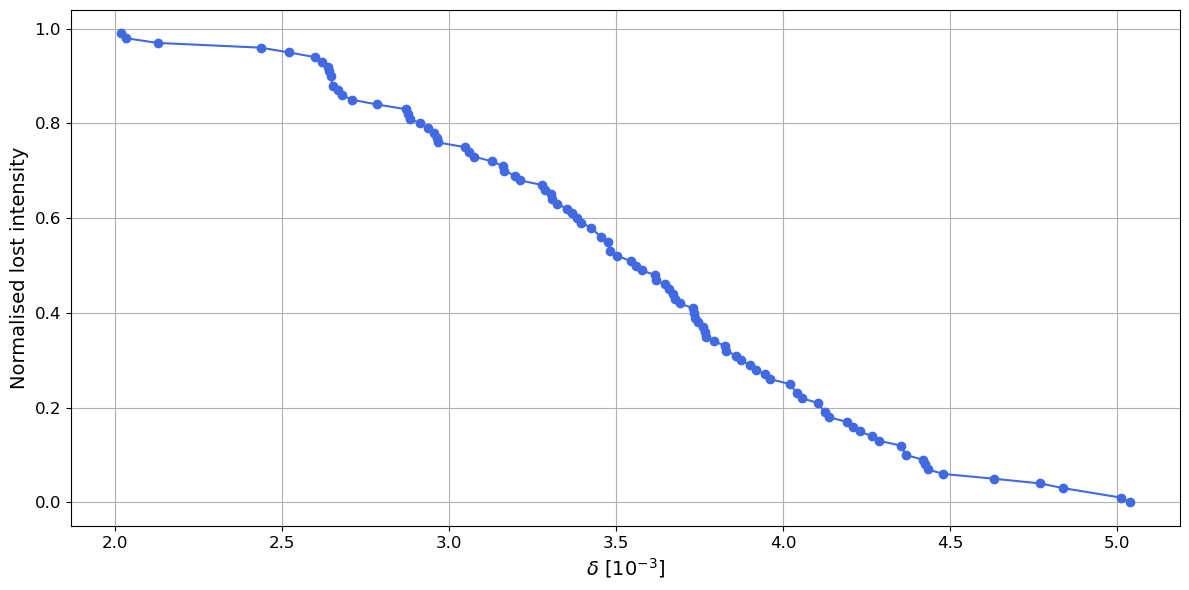

##################################
qd.20110 0.016
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.85e-02 -> 1.17e-03, y_rms: 9.80e-05 -> 4.64e-05
Iteration 1, x_rms: 1.17e-03 -> 4.44e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 4.44e-04 -> 4.02e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 4.02e-04 -> 3.93e-04, y_rms: 2.15e-05 -> 1.91e-05
Iteration 4, x_rms: 3.93e-04 -> 3.91e-04, y_rms: 1.91e-05 -> 1.62e-05
Iteration 5, x_rms: 3.91e-04 -> 3.91e-04, y_rms: 1.62e-05 -> 1.42e-05
Iteration 6, x_rms: 3.91e-04 -> 3.87e-04, y_rms: 1.42e-05 -> 1.22e-05
Iteration 7, x_rms: 3.87e-04 -> 3.86e-04, y_rms: 1.22e-05 -> 1.11e-05
Iteration 8, x_rms: 3.86e-04 -> 3.85e-04, y_rms: 1.11e-05 -> 1.05e-05
Iteration 9, x_rms: 3.85e-04 -> 3.81e-04, y_rms: 1.05e-05 -> 1.01e-05


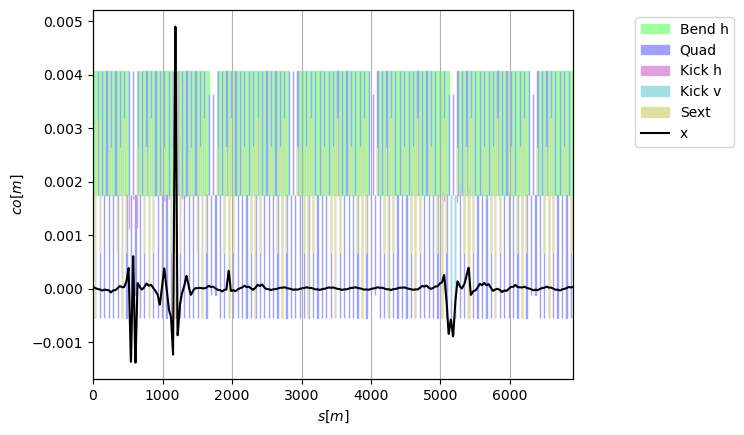

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.28086427904130484
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.36 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 38.8s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


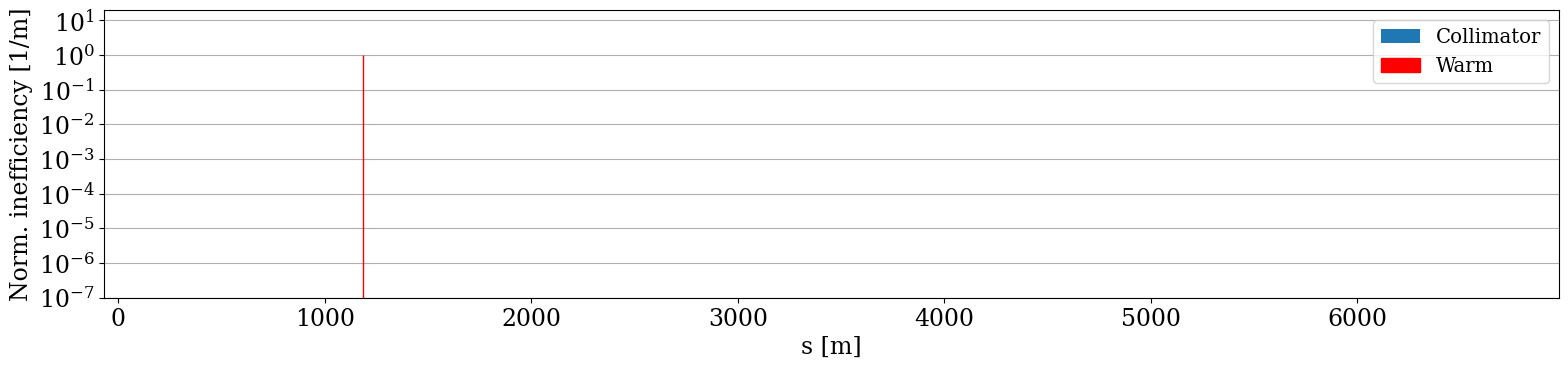

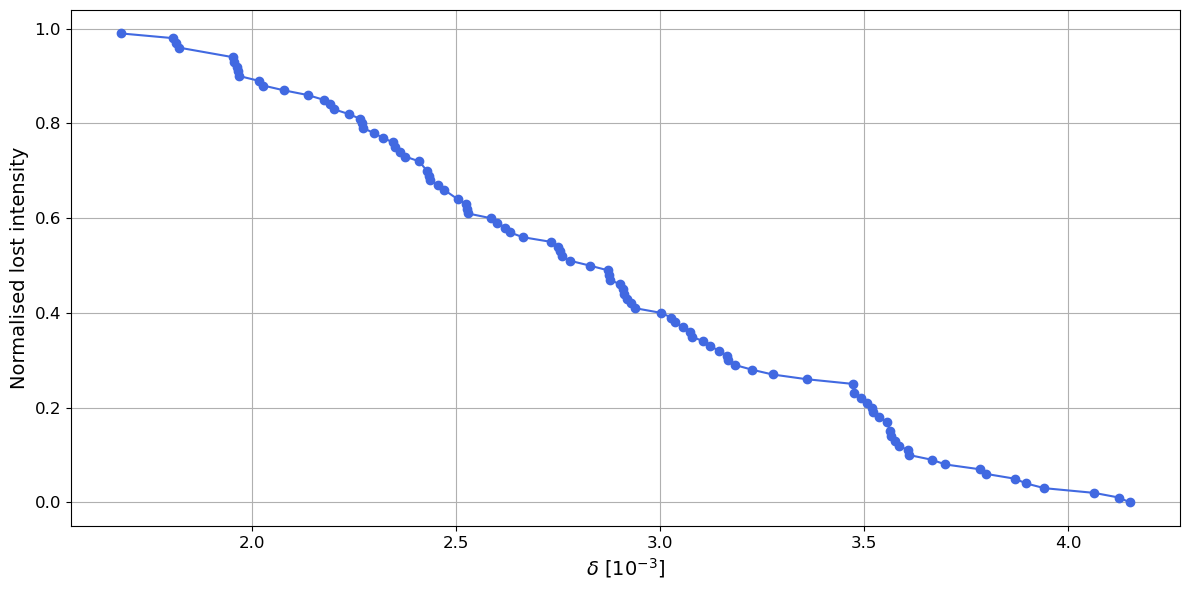

##################################
qd.20110 0.018000000000000002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.21e-02 -> 1.41e-03, y_rms: 9.80e-05 -> 4.74e-05
Iteration 1, x_rms: 1.41e-03 -> 4.93e-04, y_rms: 4.74e-05 -> 2.32e-05
Iteration 2, x_rms: 4.93e-04 -> 4.70e-04, y_rms: 2.32e-05 -> 2.04e-05
Iteration 3, x_rms: 4.70e-04 -> 4.50e-04, y_rms: 2.04e-05 -> 1.80e-05
Iteration 4, x_rms: 4.50e-04 -> 4.37e-04, y_rms: 1.80e-05 -> 1.63e-05
Iteration 5, x_rms: 4.37e-04 -> 4.32e-04, y_rms: 1.63e-05 -> 1.35e-05
Iteration 6, x_rms: 4.32e-04 -> 4.30e-04, y_rms: 1.35e-05 -> 9.14e-06
Iteration 7, x_rms: 4.30e-04 -> 4.28e-04, y_rms: 9.14e-06 -> 7.94e-06
Iteration 8, x_rms: 4.28e-04 -> 4.25e-04, y_rms: 7.94e-06 -> 6.32e-06
Iteration 9, x_rms: 4.25e-04 -> 4.23e-04, y_rms: 6.32e-06 -> 5.80e-06


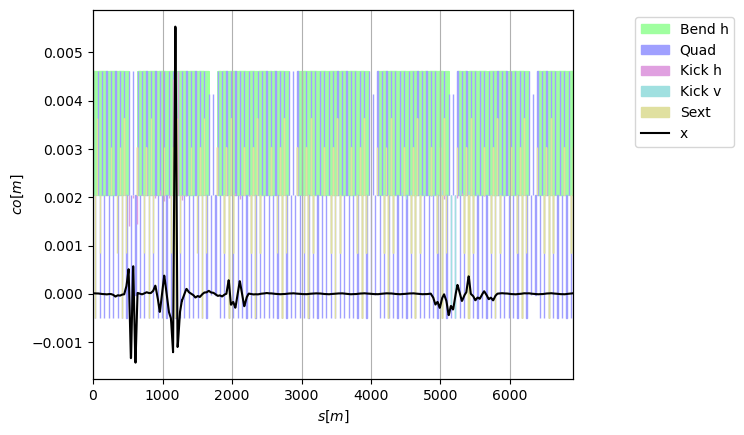

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.2808581552251163
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.41 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 34.3s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


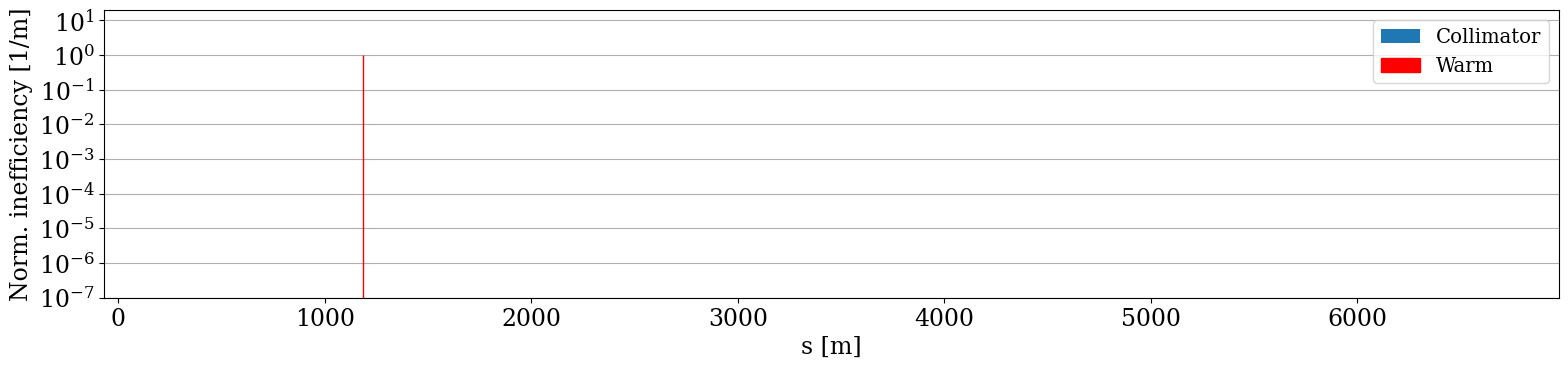

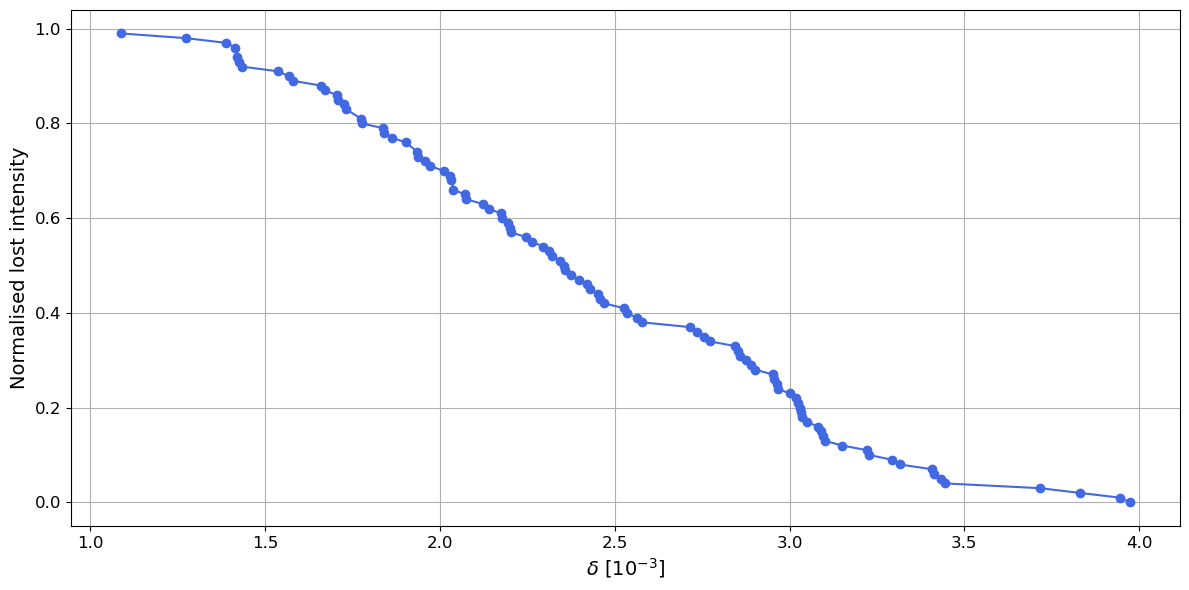

##################################
qd.20110 0.02
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.56e-02 -> 1.67e-03, y_rms: 9.80e-05 -> 2.04e-05
Iteration 1, x_rms: 1.67e-03 -> 5.39e-04, y_rms: 2.04e-05 -> 1.23e-05
Iteration 2, x_rms: 5.39e-04 -> 5.02e-04, y_rms: 1.23e-05 -> 9.54e-06
Iteration 3, x_rms: 5.02e-04 -> 4.85e-04, y_rms: 9.54e-06 -> 8.35e-06
Iteration 4, x_rms: 4.85e-04 -> 4.73e-04, y_rms: 8.35e-06 -> 7.95e-06
Iteration 5, x_rms: 4.73e-04 -> 4.66e-04, y_rms: 7.95e-06 -> 7.32e-06
Iteration 6, x_rms: 4.66e-04 -> 4.64e-04, y_rms: 7.32e-06 -> 7.00e-06
Iteration 7, x_rms: 4.64e-04 -> 4.63e-04, y_rms: 7.00e-06 -> 6.38e-06
Iteration 8, x_rms: 4.63e-04 -> 4.62e-04, y_rms: 6.38e-06 -> 6.11e-06
Iteration 9, x_rms: 4.62e-04 -> 4.62e-04, y_rms: 6.11e-06 -> 5.58e-06


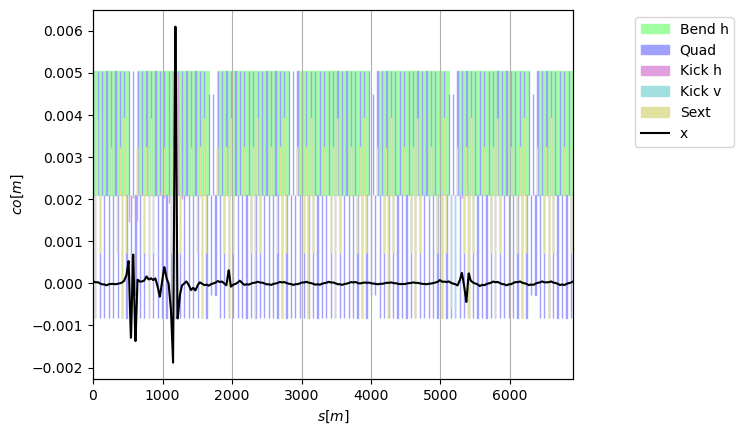

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28085282477691426
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.45 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 26.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.20110.a_aper': 100}


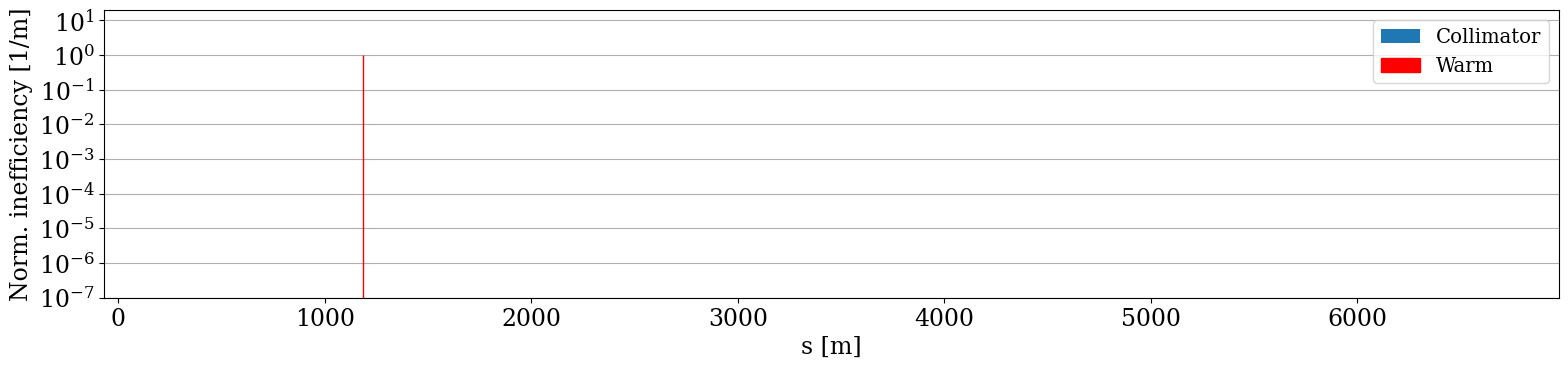

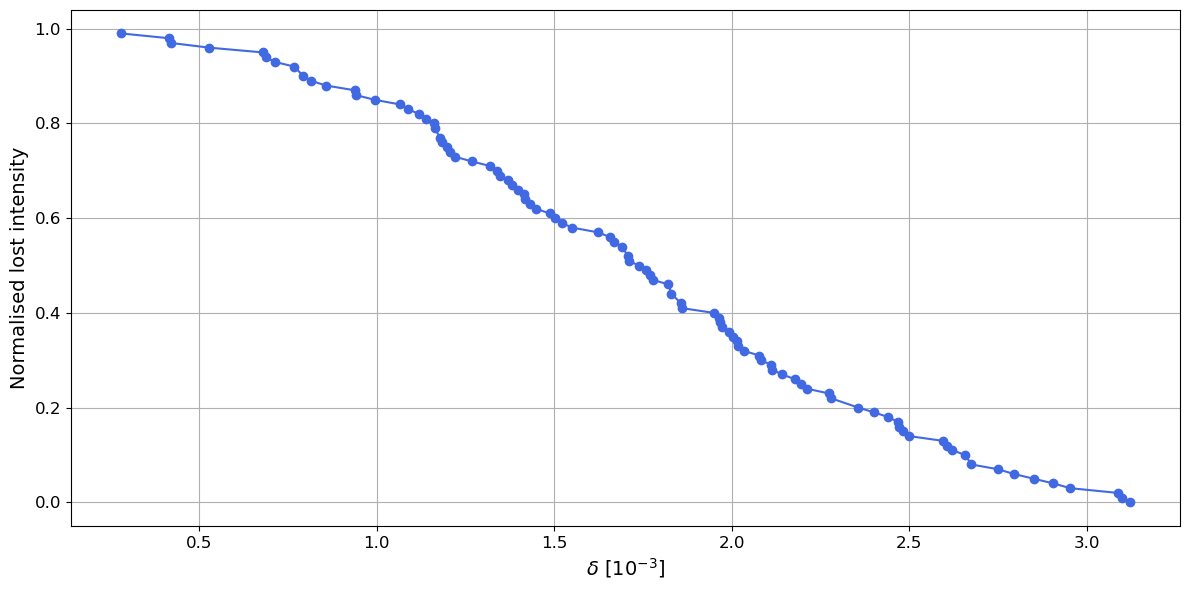

##################################
qd.31110 0.0
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.22e-03 -> 2.88e-04, y_rms: 9.78e-05 -> 1.78e-05
Iteration 1, x_rms: 2.88e-04 -> 2.20e-04, y_rms: 1.78e-05 -> 1.30e-05
Iteration 2, x_rms: 2.20e-04 -> 1.87e-04, y_rms: 1.30e-05 -> 1.08e-05
Iteration 3, x_rms: 1.87e-04 -> 1.58e-04, y_rms: 1.08e-05 -> 8.80e-06
Iteration 4, x_rms: 1.58e-04 -> 1.38e-04, y_rms: 8.80e-06 -> 7.86e-06
Iteration 5, x_rms: 1.38e-04 -> 1.34e-04, y_rms: 7.86e-06 -> 7.45e-06
Iteration 6, x_rms: 1.34e-04 -> 1.28e-04, y_rms: 7.45e-06 -> 5.75e-06
Iteration 7, x_rms: 1.28e-04 -> 1.22e-04, y_rms: 5.75e-06 -> 5.26e-06
Iteration 8, x_rms: 1.22e-04 -> 1.19e-04, y_rms: 5.26e-06 -> 4.43e-06
Iteration 9, x_rms: 1.19e-04 -> 1.16e-04, y_rms: 4.43e-06 -> 4.08e-06


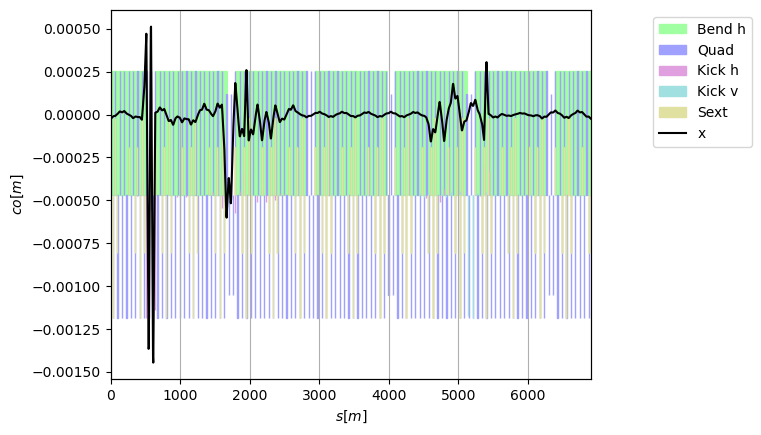

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.2809006924399915
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 85.0s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'vcak.21101.a_aper': 23, 'vtto.31105.a_aper': 10, 'vcak.51101.a_aper': 8, 'vcak.52501.a_aper': 6, 'vcak.61101.a_aper': 53}


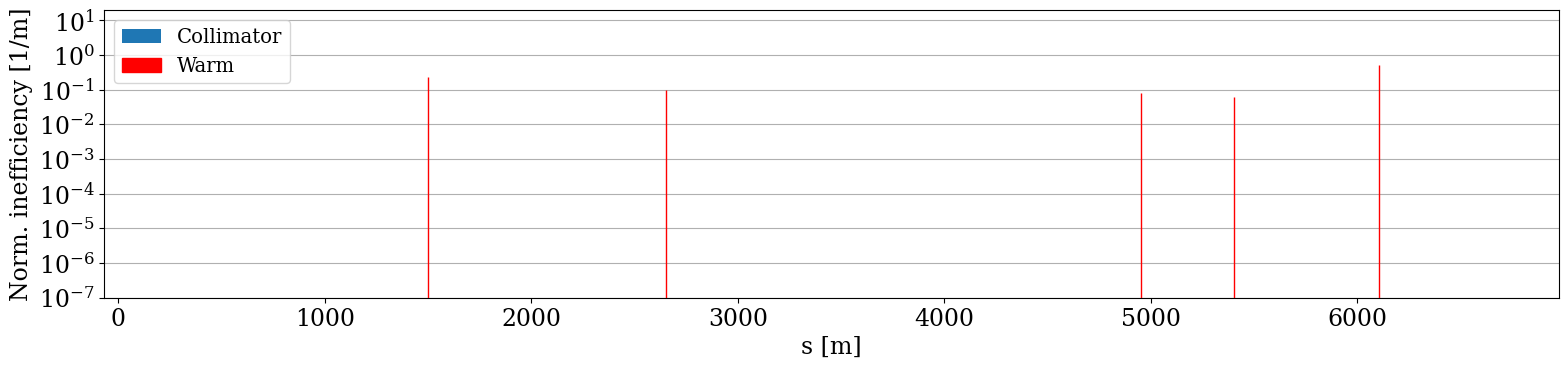

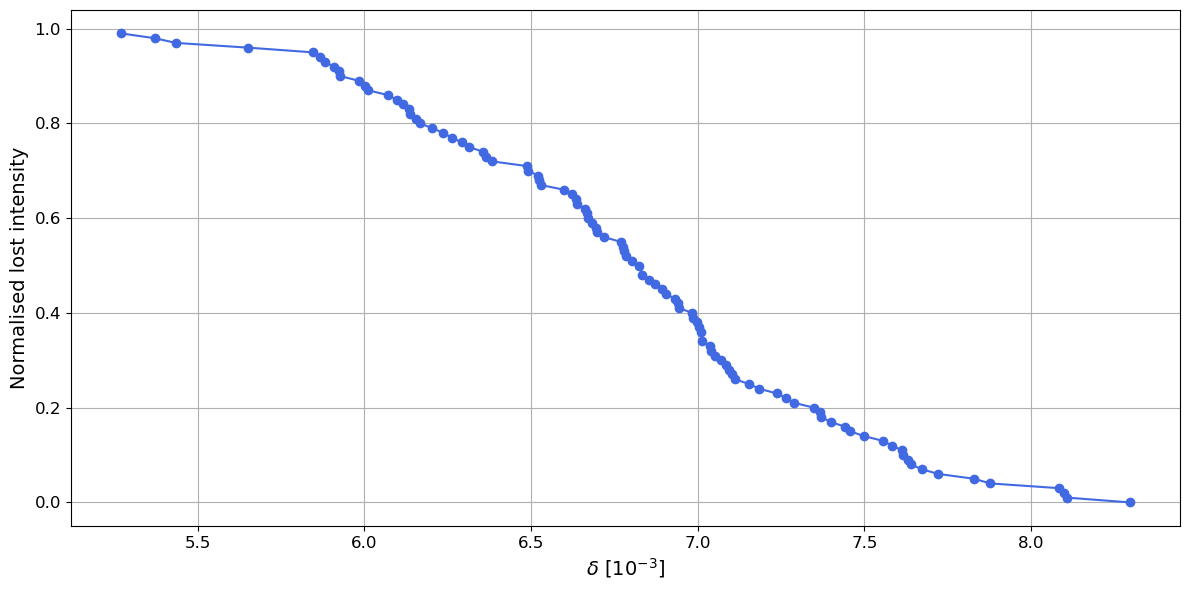

##################################
qd.31110 0.002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 6.37e-03 -> 4.34e-04, y_rms: 9.80e-05 -> 4.64e-05
Iteration 1, x_rms: 4.34e-04 -> 3.02e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 3.02e-04 -> 2.58e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 2.58e-04 -> 2.30e-04, y_rms: 2.15e-05 -> 2.01e-05
Iteration 4, x_rms: 2.30e-04 -> 2.07e-04, y_rms: 2.01e-05 -> 1.91e-05
Iteration 5, x_rms: 2.07e-04 -> 1.82e-04, y_rms: 1.91e-05 -> 1.69e-05
Iteration 6, x_rms: 1.82e-04 -> 1.65e-04, y_rms: 1.69e-05 -> 1.62e-05
Iteration 7, x_rms: 1.65e-04 -> 1.56e-04, y_rms: 1.62e-05 -> 1.33e-05
Iteration 8, x_rms: 1.56e-04 -> 1.51e-04, y_rms: 1.33e-05 -> 1.19e-05
Iteration 9, x_rms: 1.51e-04 -> 1.49e-04, y_rms: 1.19e-05 -> 1.07e-05


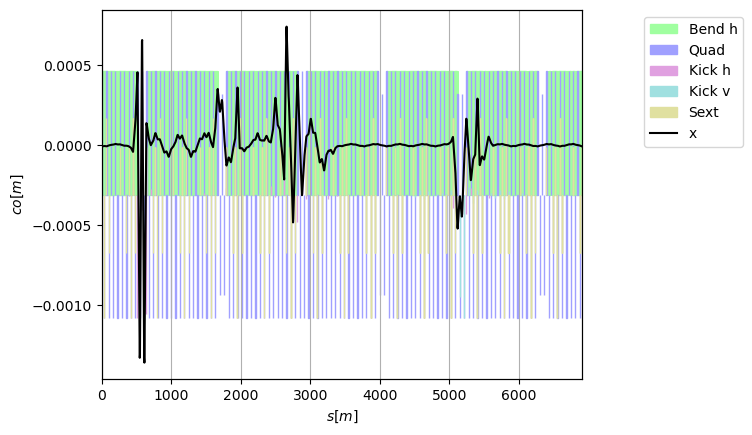

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.2809085909633662
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.03 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 80.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


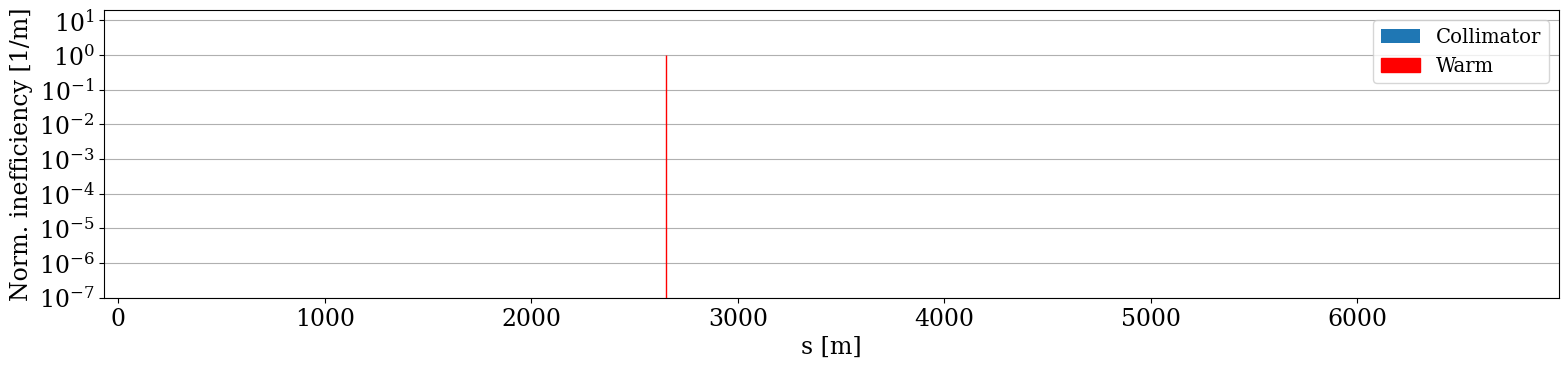

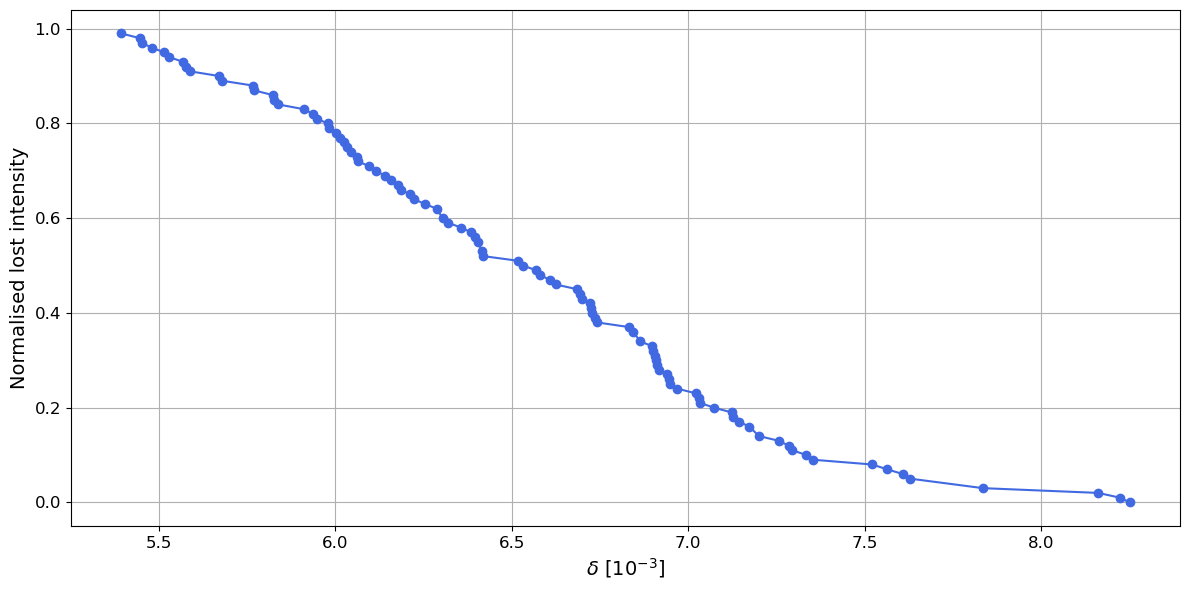

##################################
qd.31110 0.004
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 9.58e-03 -> 3.86e-04, y_rms: 9.82e-05 -> 4.65e-05
Iteration 1, x_rms: 3.86e-04 -> 3.04e-04, y_rms: 4.65e-05 -> 3.03e-05
Iteration 2, x_rms: 3.04e-04 -> 2.42e-04, y_rms: 3.03e-05 -> 2.73e-05
Iteration 3, x_rms: 2.42e-04 -> 2.12e-04, y_rms: 2.73e-05 -> 2.36e-05
Iteration 4, x_rms: 2.12e-04 -> 1.76e-04, y_rms: 2.36e-05 -> 2.14e-05
Iteration 5, x_rms: 1.76e-04 -> 1.61e-04, y_rms: 2.14e-05 -> 1.72e-05
Iteration 6, x_rms: 1.61e-04 -> 1.55e-04, y_rms: 1.72e-05 -> 1.36e-05
Iteration 7, x_rms: 1.55e-04 -> 1.53e-04, y_rms: 1.36e-05 -> 1.06e-05
Iteration 8, x_rms: 1.53e-04 -> 1.52e-04, y_rms: 1.06e-05 -> 9.06e-06
Iteration 9, x_rms: 1.52e-04 -> 1.51e-04, y_rms: 9.06e-06 -> 7.94e-06


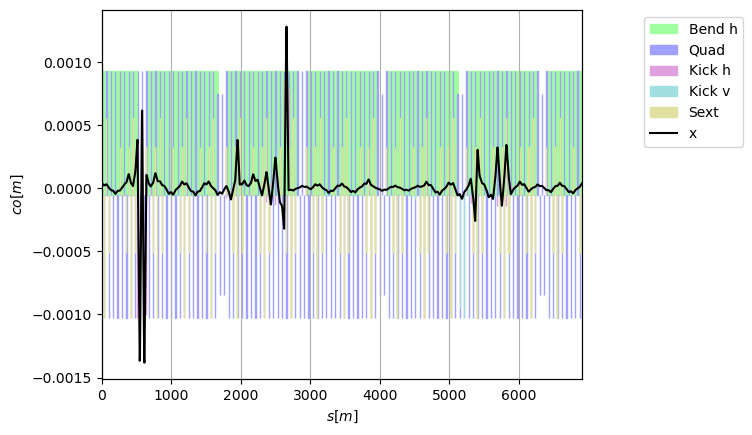

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.2809082301248079
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.03 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 82.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


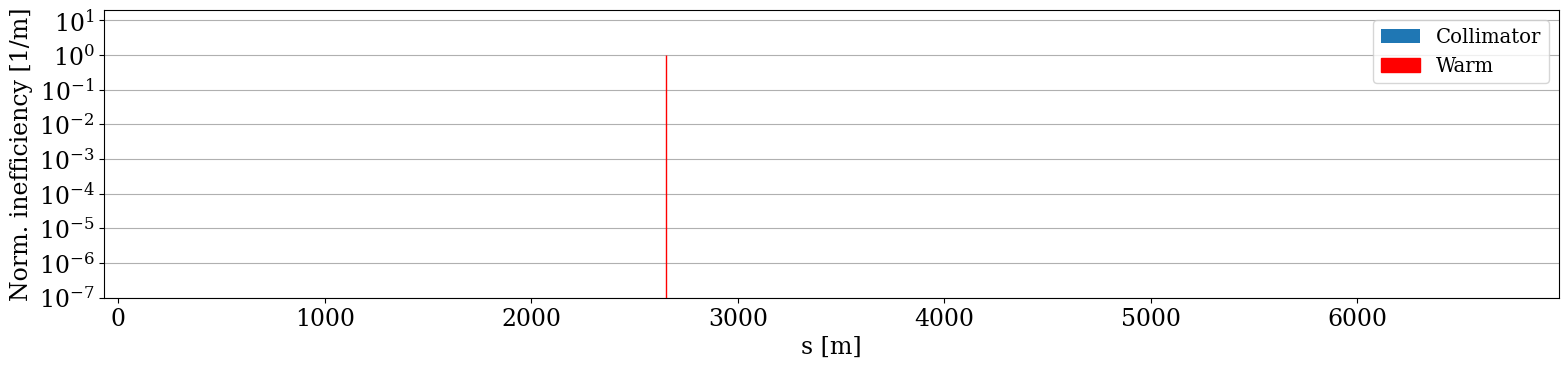

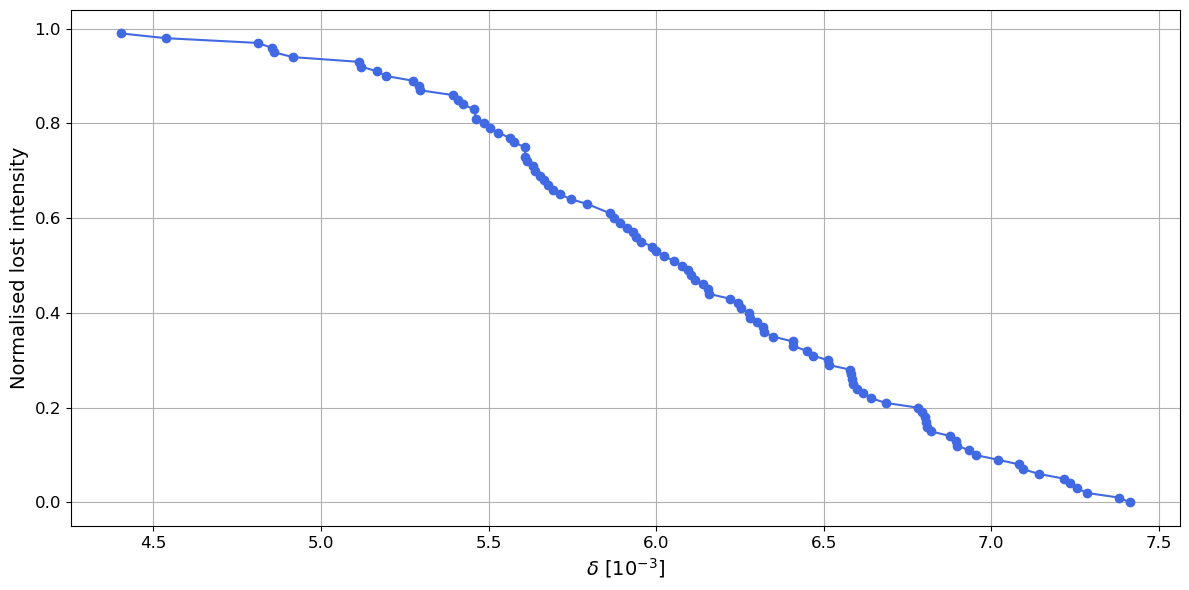

##################################
qd.31110 0.006
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.28e-02 -> 3.85e-04, y_rms: 9.85e-05 -> 4.66e-05
Iteration 1, x_rms: 3.85e-04 -> 2.68e-04, y_rms: 4.66e-05 -> 3.04e-05
Iteration 2, x_rms: 2.68e-04 -> 2.22e-04, y_rms: 3.04e-05 -> 2.74e-05
Iteration 3, x_rms: 2.22e-04 -> 2.00e-04, y_rms: 2.74e-05 -> 2.36e-05
Iteration 4, x_rms: 2.00e-04 -> 1.98e-04, y_rms: 2.36e-05 -> 2.14e-05
Iteration 5, x_rms: 1.98e-04 -> 1.97e-04, y_rms: 2.14e-05 -> 1.73e-05
Iteration 6, x_rms: 1.97e-04 -> 1.93e-04, y_rms: 1.73e-05 -> 1.37e-05
Iteration 7, x_rms: 1.93e-04 -> 1.90e-04, y_rms: 1.37e-05 -> 1.06e-05
Iteration 8, x_rms: 1.90e-04 -> 1.87e-04, y_rms: 1.06e-05 -> 9.08e-06
Iteration 9, x_rms: 1.87e-04 -> 1.83e-04, y_rms: 9.08e-06 -> 8.62e-06


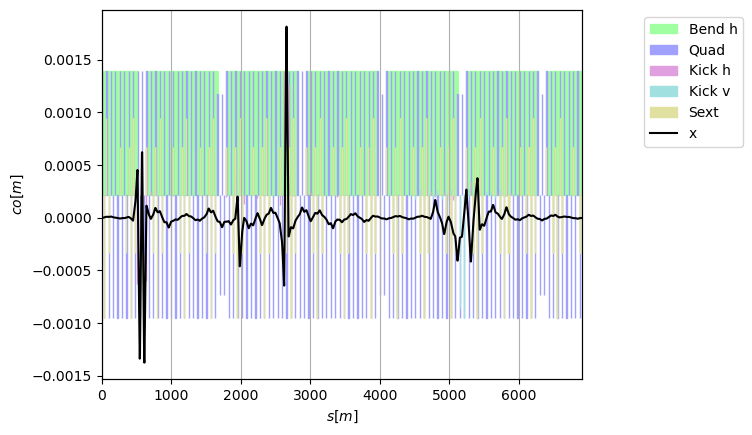

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.2809044303896039
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.06 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 69.2s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


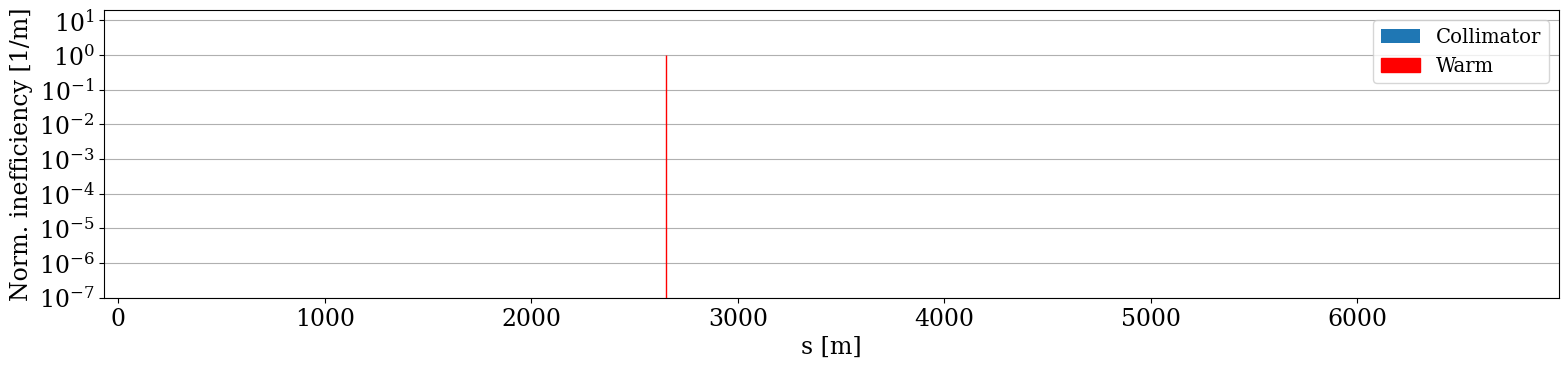

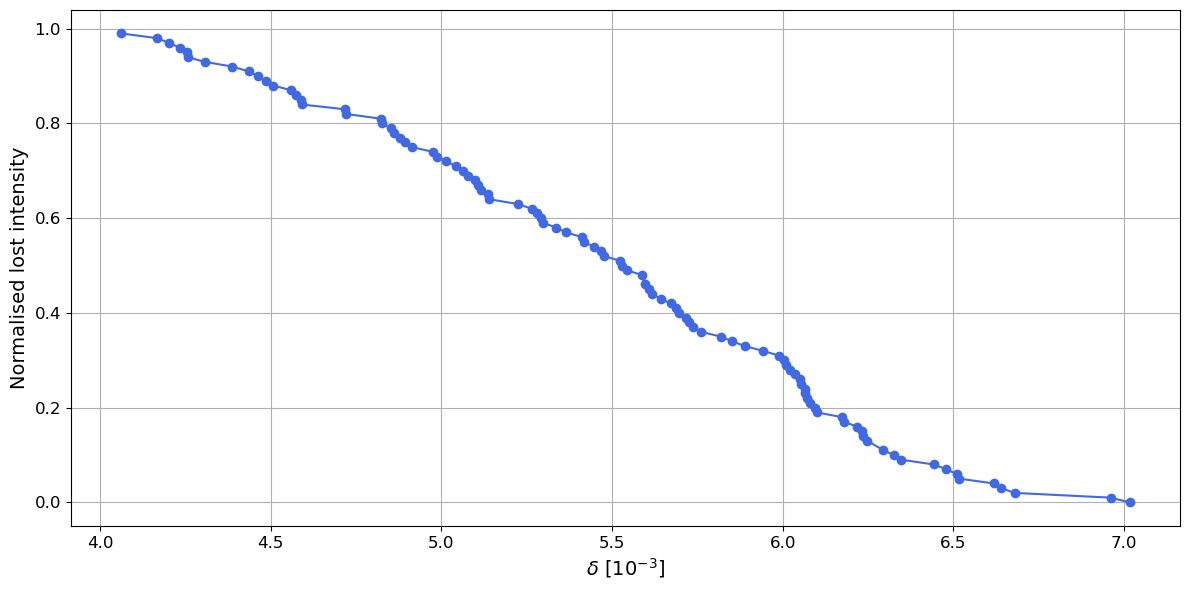

##################################
qd.31110 0.008
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.61e-02 -> 9.78e-04, y_rms: 9.88e-05 -> 4.69e-05
Iteration 1, x_rms: 9.78e-04 -> 4.55e-04, y_rms: 4.69e-05 -> 2.60e-05
Iteration 2, x_rms: 4.55e-04 -> 3.53e-04, y_rms: 2.60e-05 -> 2.03e-05
Iteration 3, x_rms: 3.53e-04 -> 2.90e-04, y_rms: 2.03e-05 -> 1.87e-05
Iteration 4, x_rms: 2.90e-04 -> 2.34e-04, y_rms: 1.87e-05 -> 1.32e-05
Iteration 5, x_rms: 2.34e-04 -> 2.21e-04, y_rms: 1.32e-05 -> 9.72e-06
Iteration 6, x_rms: 2.21e-04 -> 2.15e-04, y_rms: 9.72e-06 -> 9.05e-06
Iteration 7, x_rms: 2.15e-04 -> 2.12e-04, y_rms: 9.05e-06 -> 8.71e-06
Iteration 8, x_rms: 2.12e-04 -> 2.11e-04, y_rms: 8.71e-06 -> 8.52e-06
Iteration 9, x_rms: 2.11e-04 -> 2.11e-04, y_rms: 8.52e-06 -> 8.01e-06


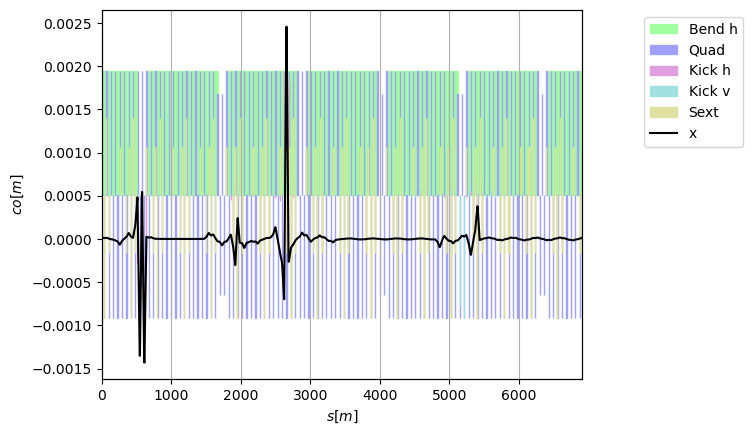

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.28090341419246256
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.06 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 64.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


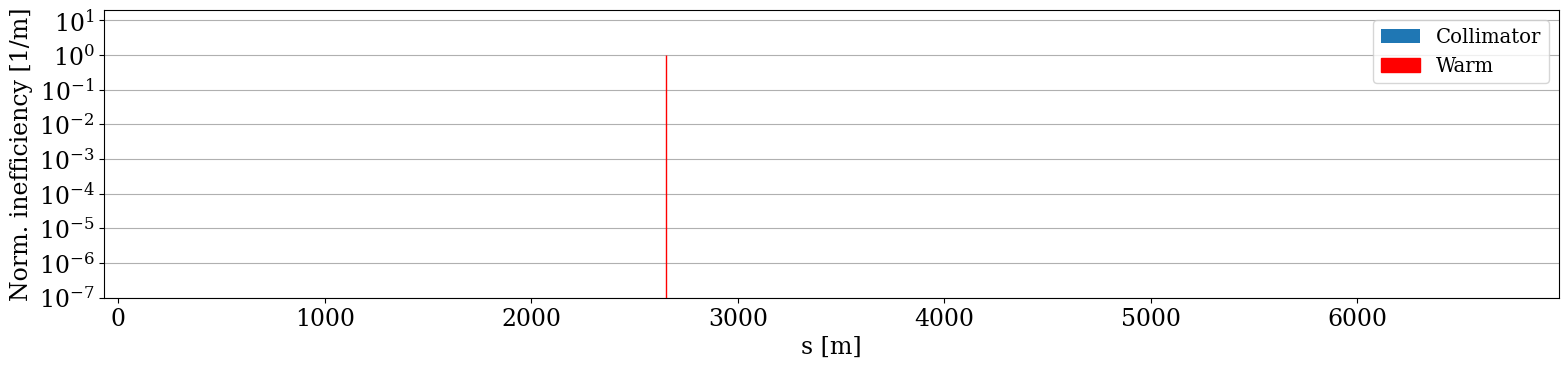

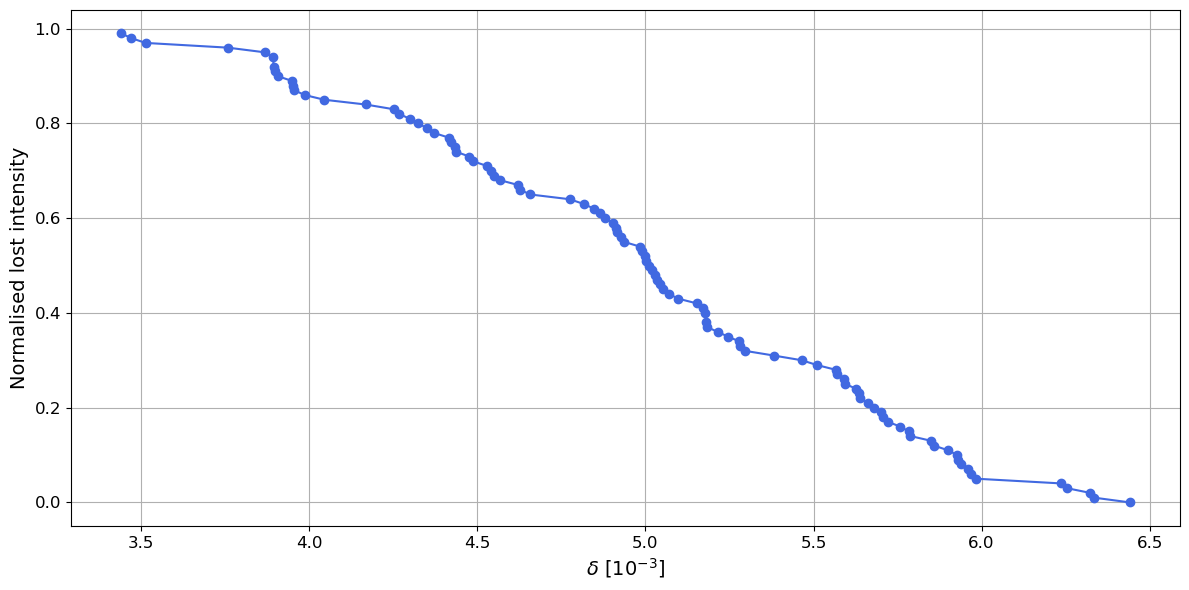

##################################
qd.31110 0.01
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.93e-02 -> 7.12e-04, y_rms: 9.91e-05 -> 3.45e-05
Iteration 1, x_rms: 7.12e-04 -> 3.66e-04, y_rms: 3.45e-05 -> 2.48e-05
Iteration 2, x_rms: 3.66e-04 -> 3.48e-04, y_rms: 2.48e-05 -> 2.02e-05
Iteration 3, x_rms: 3.48e-04 -> 3.00e-04, y_rms: 2.02e-05 -> 1.35e-05
Iteration 4, x_rms: 3.00e-04 -> 2.73e-04, y_rms: 1.35e-05 -> 1.03e-05
Iteration 5, x_rms: 2.73e-04 -> 2.70e-04, y_rms: 1.03e-05 -> 9.15e-06
Iteration 6, x_rms: 2.70e-04 -> 2.63e-04, y_rms: 9.15e-06 -> 8.76e-06
Iteration 7, x_rms: 2.63e-04 -> 2.59e-04, y_rms: 8.76e-06 -> 8.10e-06
Iteration 8, x_rms: 2.59e-04 -> 2.57e-04, y_rms: 8.10e-06 -> 7.24e-06
Iteration 9, x_rms: 2.57e-04 -> 2.55e-04, y_rms: 7.24e-06 -> 6.94e-06


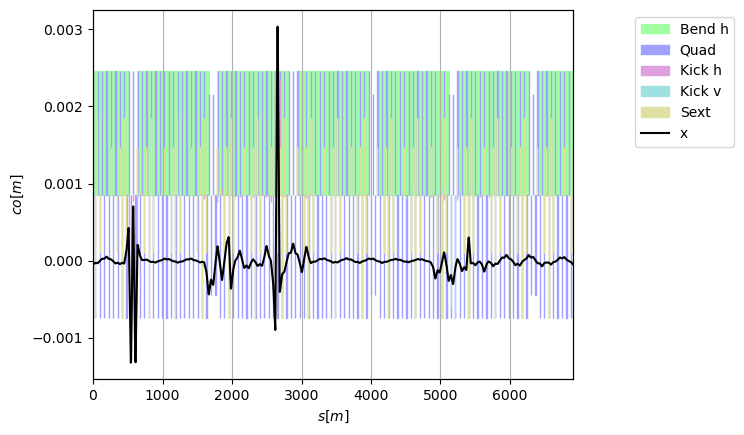

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.2809001598172635
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 54.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


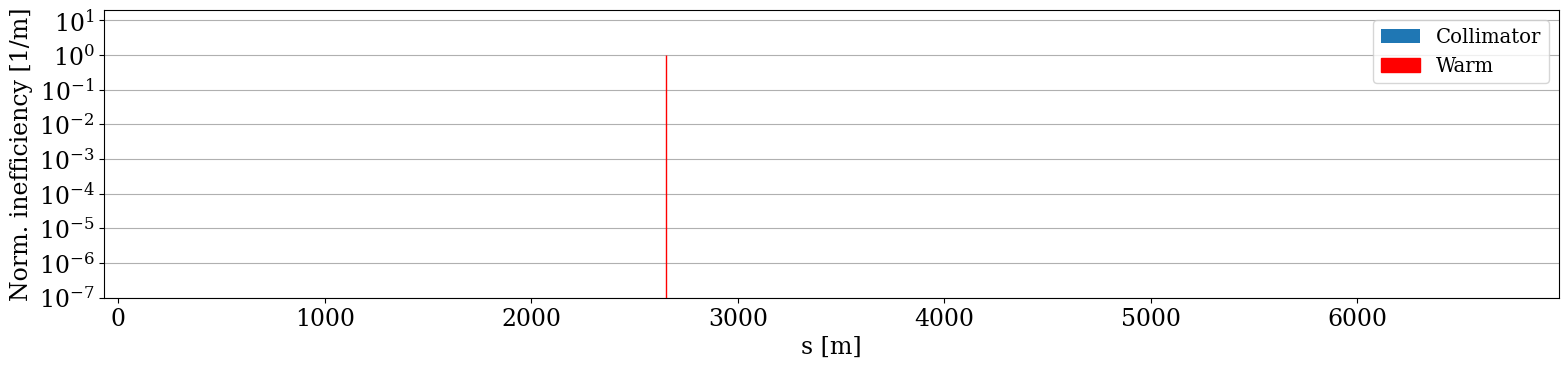

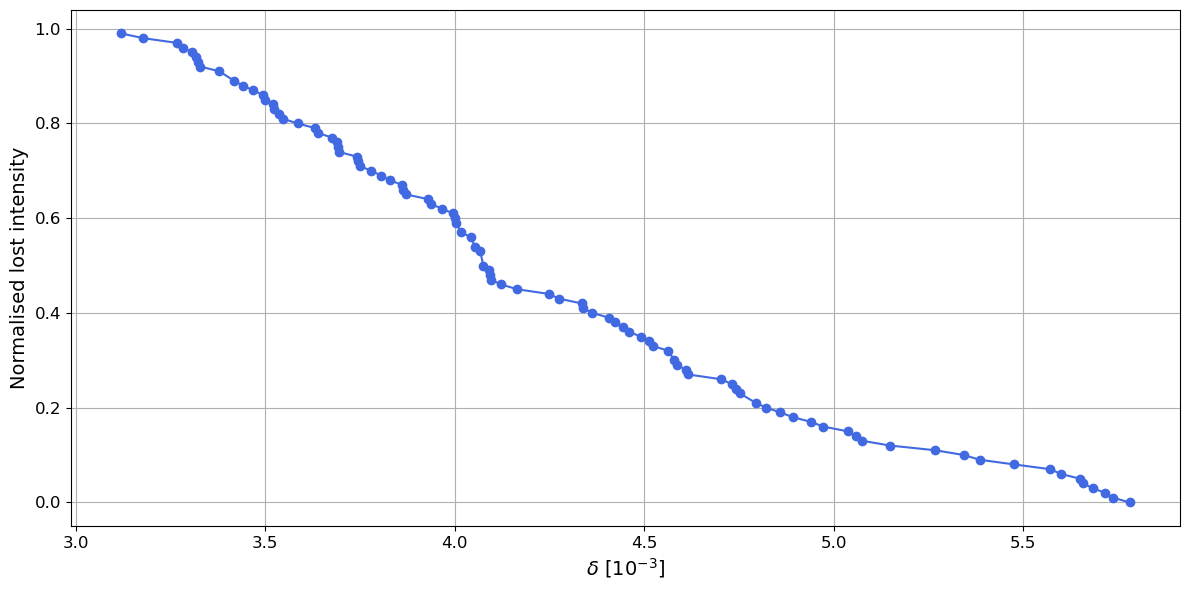

##################################
qd.31110 0.012
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.26e-02 -> 7.48e-04, y_rms: 9.95e-05 -> 2.24e-05
Iteration 1, x_rms: 7.48e-04 -> 4.01e-04, y_rms: 2.24e-05 -> 9.43e-06
Iteration 2, x_rms: 4.01e-04 -> 3.85e-04, y_rms: 9.43e-06 -> 7.41e-06
Iteration 3, x_rms: 3.85e-04 -> 3.36e-04, y_rms: 7.41e-06 -> 7.11e-06
Iteration 4, x_rms: 3.36e-04 -> 3.13e-04, y_rms: 7.11e-06 -> 6.53e-06
Iteration 5, x_rms: 3.13e-04 -> 3.08e-04, y_rms: 6.53e-06 -> 6.12e-06
Iteration 6, x_rms: 3.08e-04 -> 3.06e-04, y_rms: 6.12e-06 -> 5.84e-06
Iteration 7, x_rms: 3.06e-04 -> 3.00e-04, y_rms: 5.84e-06 -> 5.32e-06
Iteration 8, x_rms: 3.00e-04 -> 2.92e-04, y_rms: 5.32e-06 -> 5.04e-06
Iteration 9, x_rms: 2.92e-04 -> 2.92e-04, y_rms: 5.04e-06 -> 4.77e-06


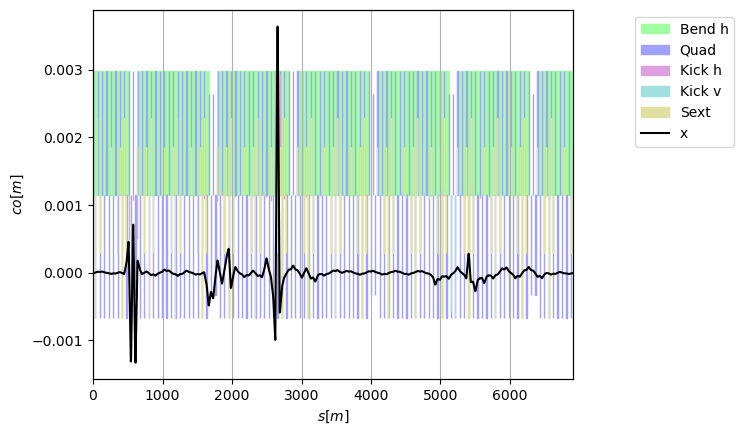

*** Maximum RMS bunch length 0.23610110400434298m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.2808990638835838
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.1 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 58.3s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'sps$start': 1, 'veqd.31110.a_aper': 99}


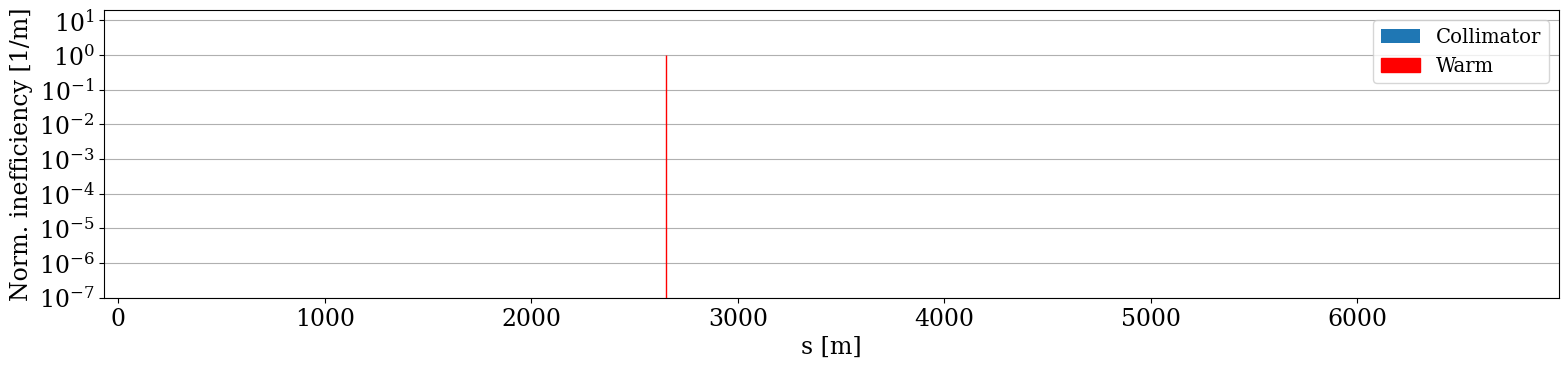

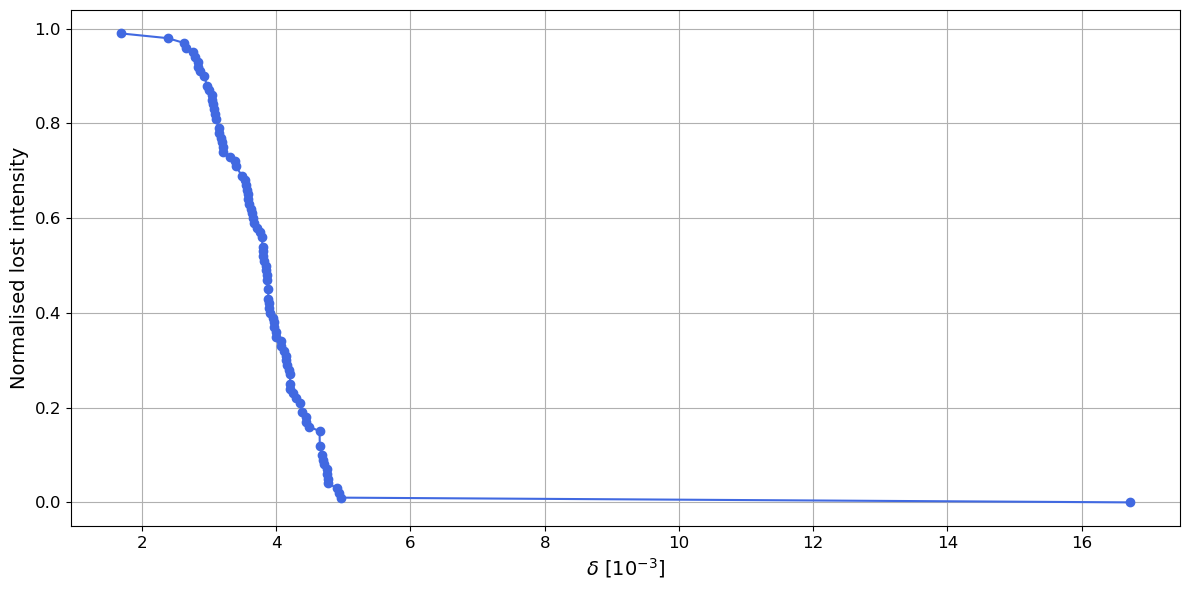

##################################
qd.31110 0.014
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.59e-02 -> 7.92e-04, y_rms: 9.99e-05 -> 2.33e-05
Iteration 1, x_rms: 7.92e-04 -> 4.39e-04, y_rms: 2.33e-05 -> 9.40e-06
Iteration 2, x_rms: 4.39e-04 -> 3.92e-04, y_rms: 9.40e-06 -> 7.40e-06
Iteration 3, x_rms: 3.92e-04 -> 3.83e-04, y_rms: 7.40e-06 -> 7.09e-06
Iteration 4, x_rms: 3.83e-04 -> 3.60e-04, y_rms: 7.09e-06 -> 6.51e-06
Iteration 5, x_rms: 3.60e-04 -> 3.51e-04, y_rms: 6.51e-06 -> 6.09e-06
Iteration 6, x_rms: 3.51e-04 -> 3.48e-04, y_rms: 6.09e-06 -> 5.82e-06
Iteration 7, x_rms: 3.48e-04 -> 3.43e-04, y_rms: 5.82e-06 -> 5.30e-06
Iteration 8, x_rms: 3.43e-04 -> 3.33e-04, y_rms: 5.30e-06 -> 5.02e-06
Iteration 9, x_rms: 3.33e-04 -> 3.32e-04, y_rms: 5.02e-06 -> 4.75e-06


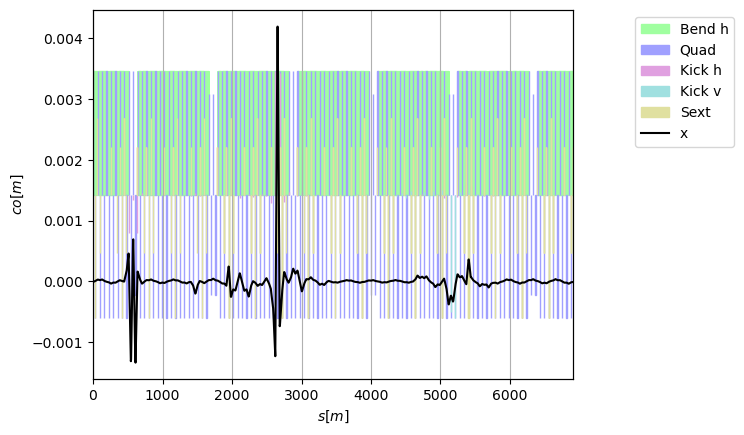

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004857
--> Emittance: 0.280902374308578
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.07 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 41.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 100}


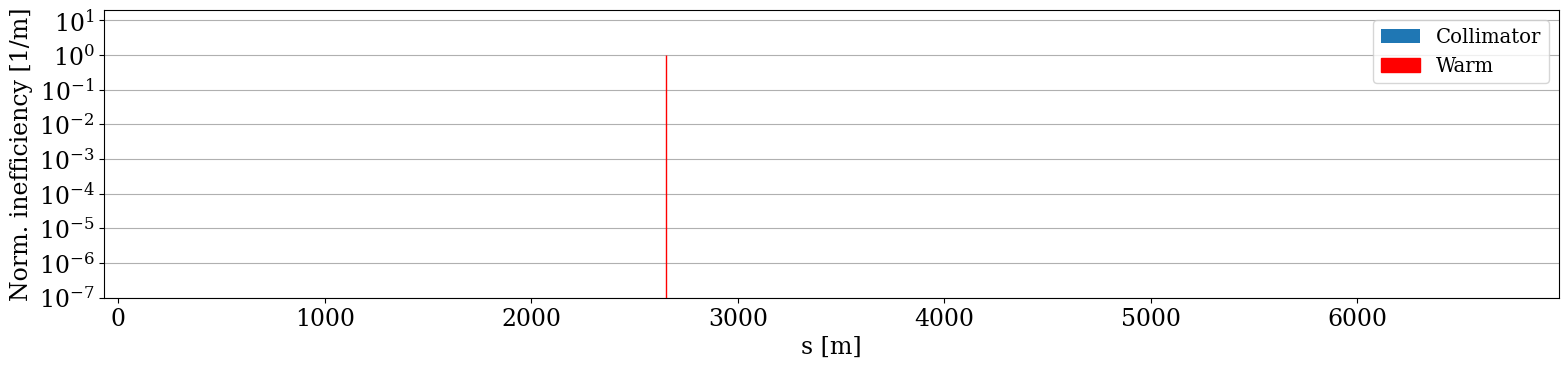

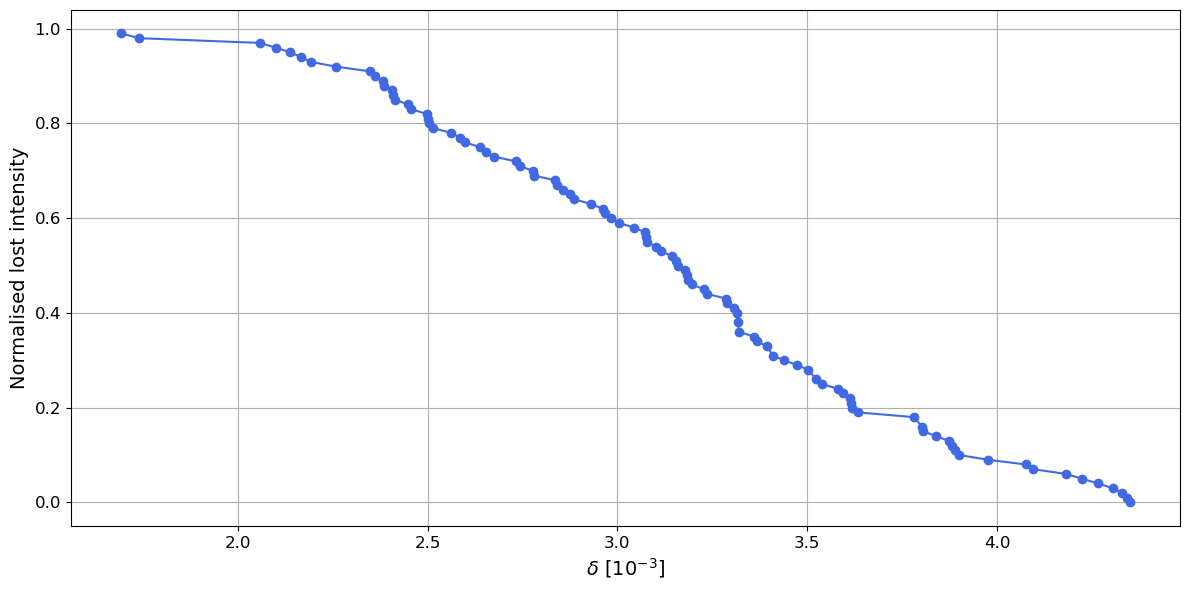

##################################
qd.31110 0.016
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.92e-02 -> 8.45e-04, y_rms: 1.00e-04 -> 2.43e-05
Iteration 1, x_rms: 8.45e-04 -> 4.76e-04, y_rms: 2.43e-05 -> 9.37e-06
Iteration 2, x_rms: 4.76e-04 -> 4.49e-04, y_rms: 9.37e-06 -> 7.38e-06
Iteration 3, x_rms: 4.49e-04 -> 4.07e-04, y_rms: 7.38e-06 -> 7.07e-06
Iteration 4, x_rms: 4.07e-04 -> 4.02e-04, y_rms: 7.07e-06 -> 6.49e-06
Iteration 5, x_rms: 4.02e-04 -> 3.89e-04, y_rms: 6.49e-06 -> 6.07e-06
Iteration 6, x_rms: 3.89e-04 -> 3.86e-04, y_rms: 6.07e-06 -> 5.80e-06
Iteration 7, x_rms: 3.86e-04 -> 3.76e-04, y_rms: 5.80e-06 -> 5.28e-06
Iteration 8, x_rms: 3.76e-04 -> 3.73e-04, y_rms: 5.28e-06 -> 5.00e-06
Iteration 9, x_rms: 3.73e-04 -> 3.72e-04, y_rms: 5.00e-06 -> 4.72e-06


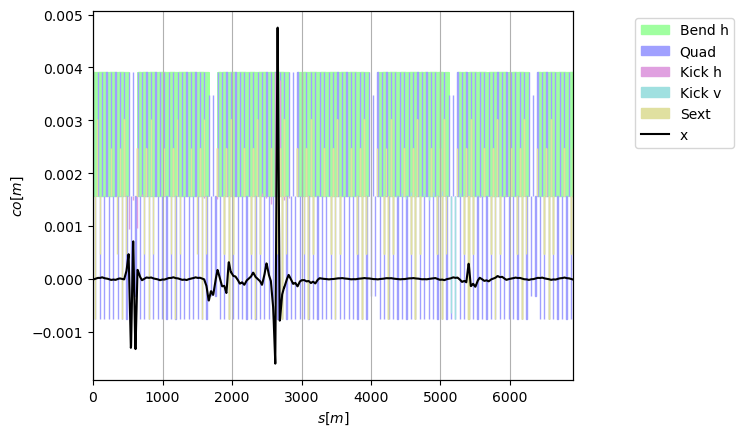

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.2809005021377575
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 36.4s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.31110.a_aper': 99, 'veqd.31110.b_aper': 1}


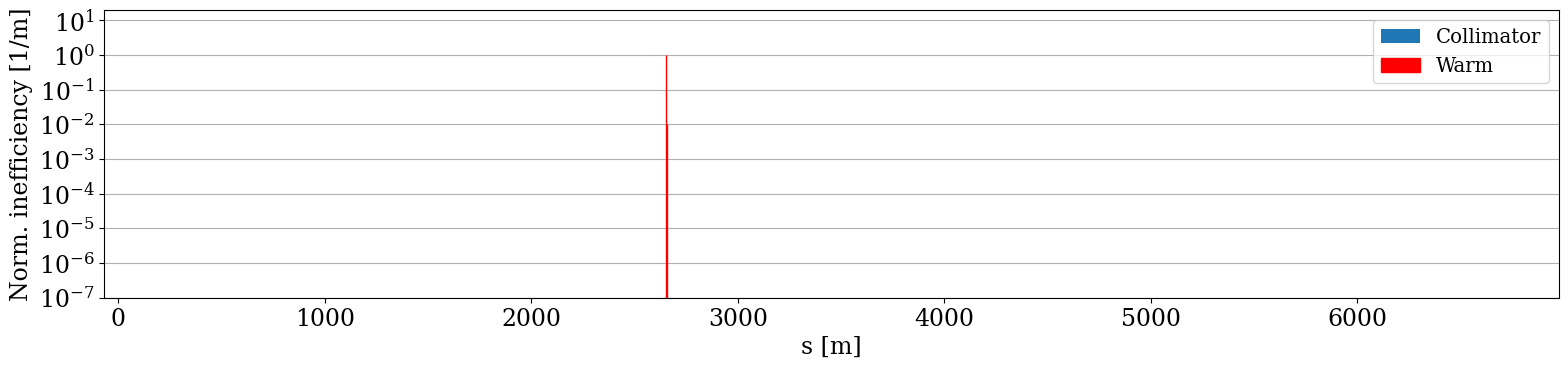

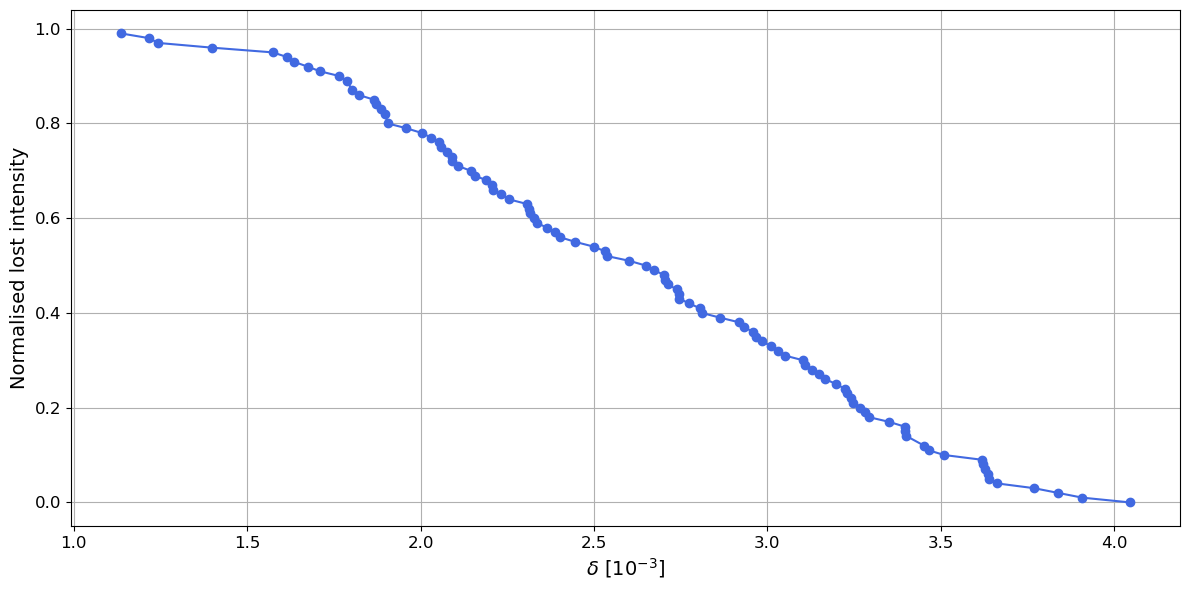

##################################
qd.31110 0.018000000000000002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.25e-02 -> 9.07e-04, y_rms: 1.01e-04 -> 2.54e-05
Iteration 1, x_rms: 9.07e-04 -> 5.10e-04, y_rms: 2.54e-05 -> 9.34e-06
Iteration 2, x_rms: 5.10e-04 -> 4.80e-04, y_rms: 9.34e-06 -> 7.36e-06
Iteration 3, x_rms: 4.80e-04 -> 4.72e-04, y_rms: 7.36e-06 -> 7.05e-06
Iteration 4, x_rms: 4.72e-04 -> 4.42e-04, y_rms: 7.05e-06 -> 6.47e-06
Iteration 5, x_rms: 4.42e-04 -> 4.30e-04, y_rms: 6.47e-06 -> 6.05e-06
Iteration 6, x_rms: 4.30e-04 -> 4.27e-04, y_rms: 6.05e-06 -> 5.78e-06
Iteration 7, x_rms: 4.27e-04 -> 4.23e-04, y_rms: 5.78e-06 -> 5.26e-06
Iteration 8, x_rms: 4.23e-04 -> 4.22e-04, y_rms: 5.26e-06 -> 4.98e-06
Iteration 9, x_rms: 4.22e-04 -> 4.22e-04, y_rms: 4.98e-06 -> 4.71e-06


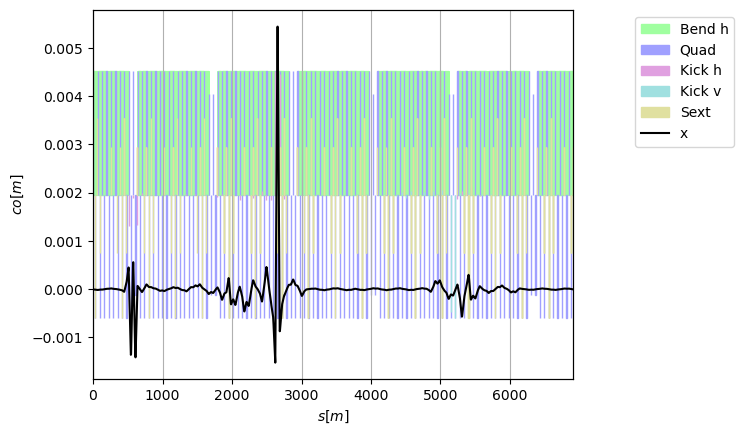

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28089955868860456
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 46.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'sps$start': 2, 'veqd.31110.a_aper': 98}


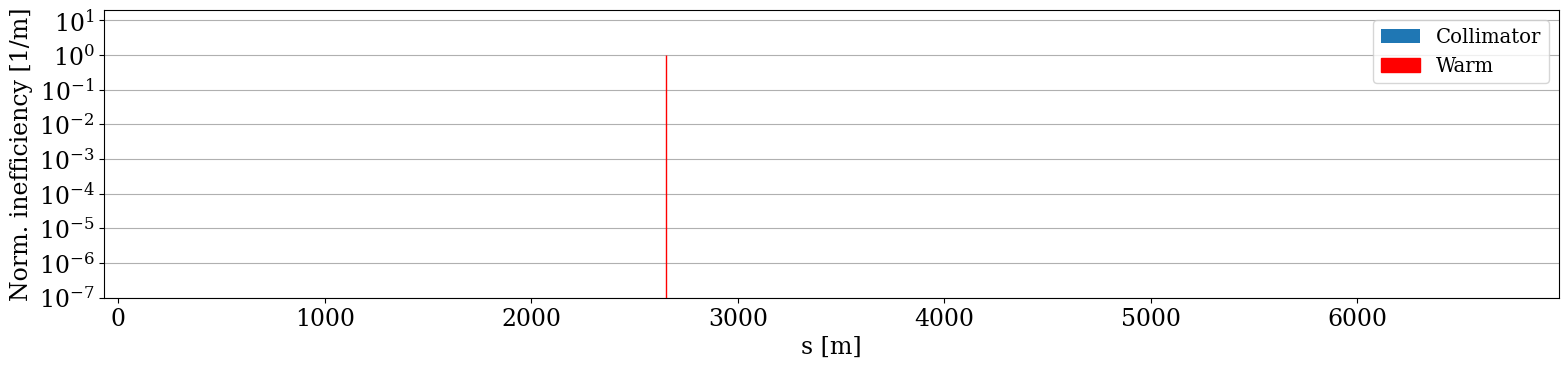

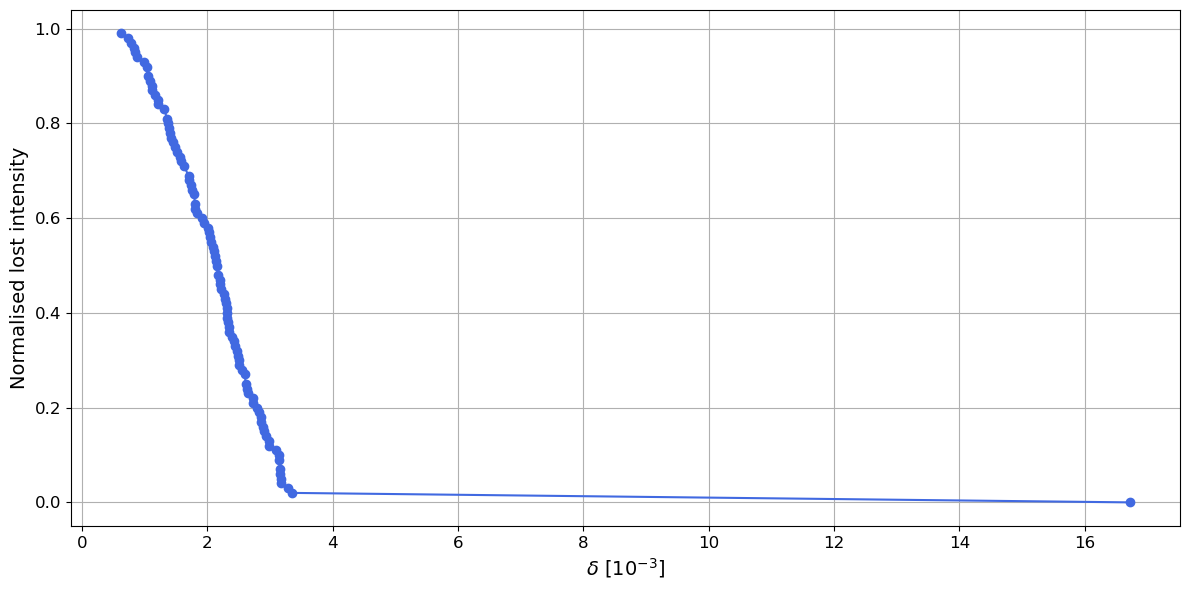

##################################
qd.31110 0.02
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.57e-02 -> 9.76e-04, y_rms: 1.02e-04 -> 2.67e-05
Iteration 1, x_rms: 9.76e-04 -> 5.47e-04, y_rms: 2.67e-05 -> 9.31e-06
Iteration 2, x_rms: 5.47e-04 -> 5.14e-04, y_rms: 9.31e-06 -> 7.70e-06
Iteration 3, x_rms: 5.14e-04 -> 5.02e-04, y_rms: 7.70e-06 -> 7.05e-06
Iteration 4, x_rms: 5.02e-04 -> 4.83e-04, y_rms: 7.05e-06 -> 6.34e-06
Iteration 5, x_rms: 4.83e-04 -> 4.68e-04, y_rms: 6.34e-06 -> 5.79e-06
Iteration 6, x_rms: 4.68e-04 -> 4.61e-04, y_rms: 5.79e-06 -> 5.55e-06
Iteration 7, x_rms: 4.61e-04 -> 4.60e-04, y_rms: 5.55e-06 -> 5.12e-06
Iteration 8, x_rms: 4.60e-04 -> 4.60e-04, y_rms: 5.12e-06 -> 5.02e-06
Iteration 9, x_rms: 4.60e-04 -> 4.60e-04, y_rms: 5.02e-06 -> 4.62e-06


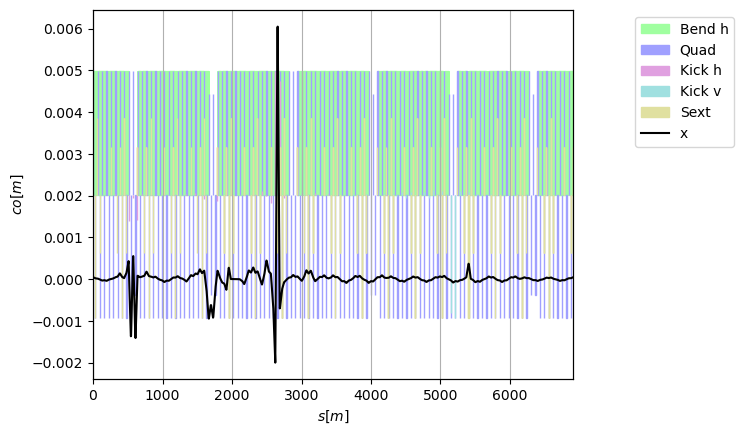

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.280909351312591
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.02 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 35.8s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'sps$start': 1, 'veqd.31110.a_aper': 96, 'veqd.31110.b_aper': 3}


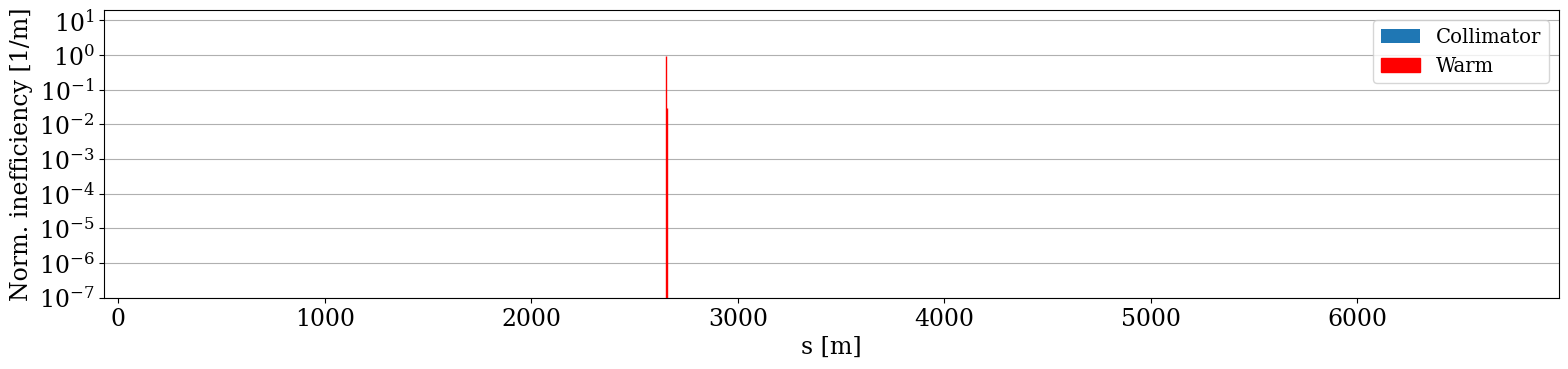

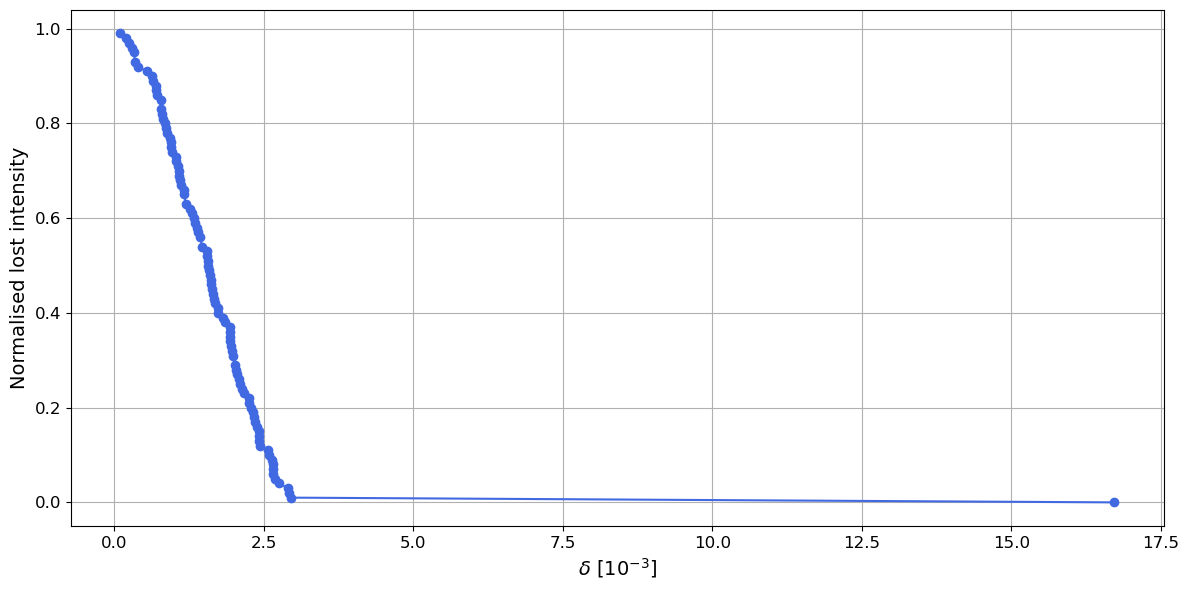

##################################
qd.50110 0.0
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.22e-03 -> 2.88e-04, y_rms: 9.78e-05 -> 1.78e-05
Iteration 1, x_rms: 2.88e-04 -> 2.20e-04, y_rms: 1.78e-05 -> 1.30e-05
Iteration 2, x_rms: 2.20e-04 -> 1.87e-04, y_rms: 1.30e-05 -> 1.08e-05
Iteration 3, x_rms: 1.87e-04 -> 1.58e-04, y_rms: 1.08e-05 -> 8.80e-06
Iteration 4, x_rms: 1.58e-04 -> 1.38e-04, y_rms: 8.80e-06 -> 7.86e-06
Iteration 5, x_rms: 1.38e-04 -> 1.34e-04, y_rms: 7.86e-06 -> 7.45e-06
Iteration 6, x_rms: 1.34e-04 -> 1.28e-04, y_rms: 7.45e-06 -> 5.75e-06
Iteration 7, x_rms: 1.28e-04 -> 1.22e-04, y_rms: 5.75e-06 -> 5.26e-06
Iteration 8, x_rms: 1.22e-04 -> 1.19e-04, y_rms: 5.26e-06 -> 4.43e-06
Iteration 9, x_rms: 1.19e-04 -> 1.16e-04, y_rms: 4.43e-06 -> 4.08e-06


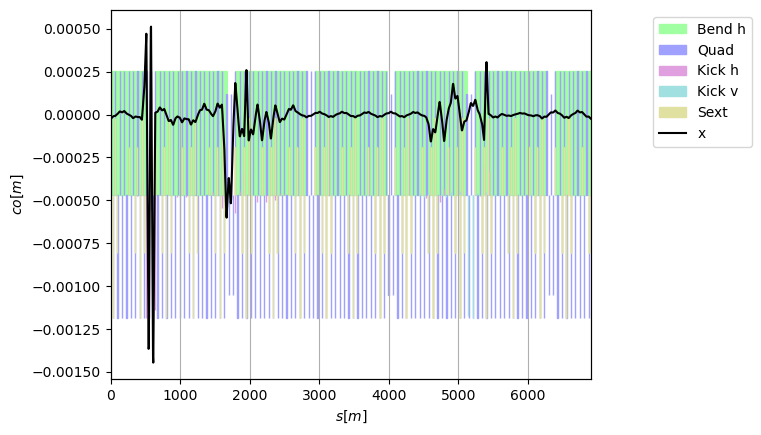

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.2809006924399915
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.09 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 86.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'vcak.21101.a_aper': 18, 'vtto.31105.a_aper': 11, 'vcak.51101.a_aper': 9, 'vcak.52501.a_aper': 6, 'vcak.61101.a_aper': 56}


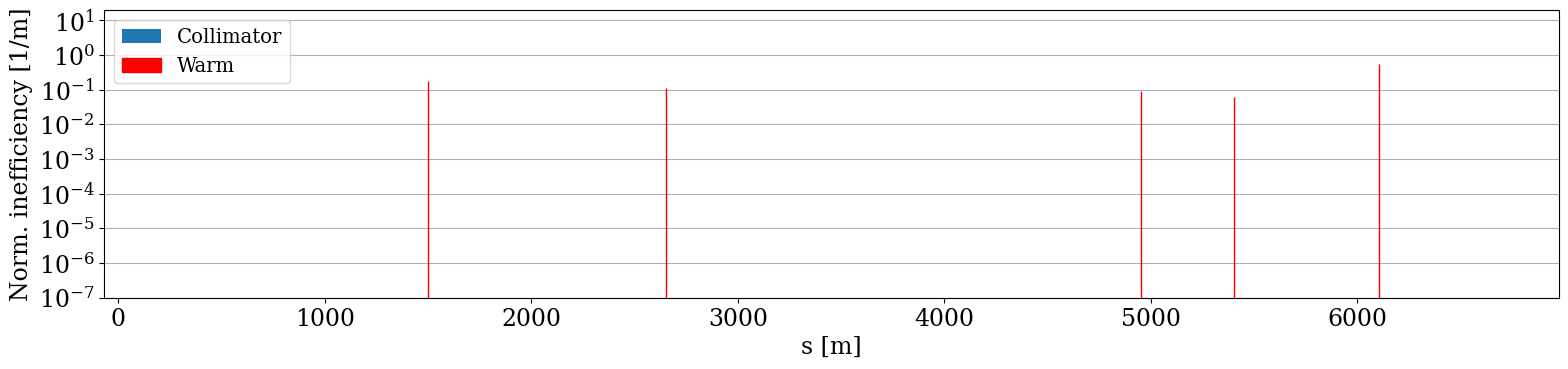

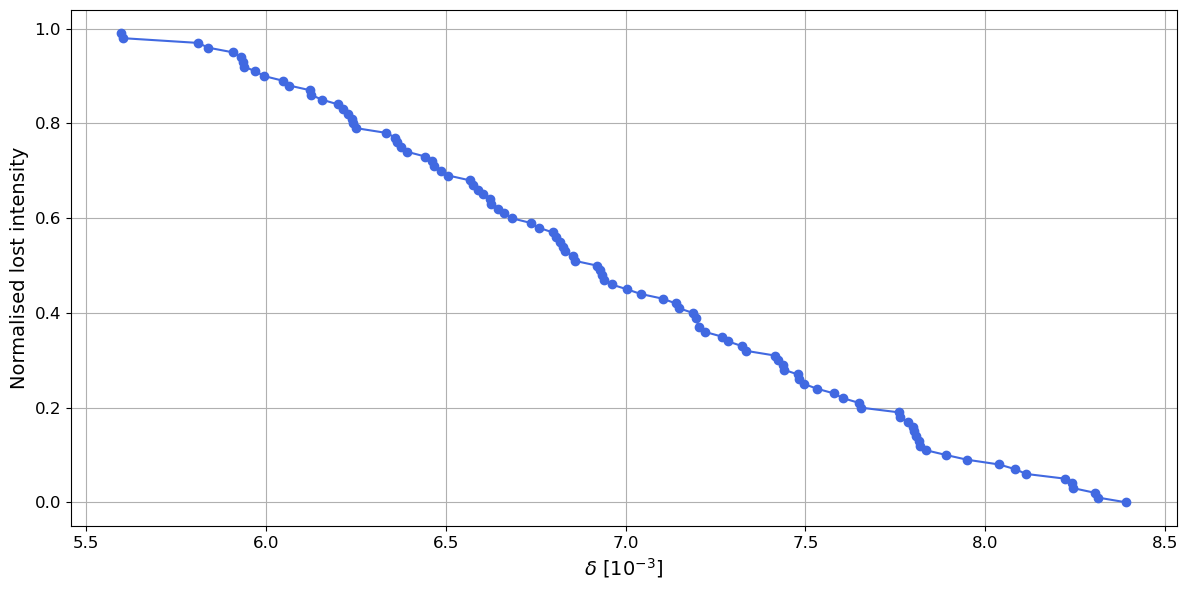

##################################
qd.50110 0.002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 5.11e-03 -> 2.43e-04, y_rms: 9.78e-05 -> 4.64e-05
Iteration 1, x_rms: 2.43e-04 -> 1.63e-04, y_rms: 4.64e-05 -> 2.54e-05
Iteration 2, x_rms: 1.63e-04 -> 1.34e-04, y_rms: 2.54e-05 -> 1.79e-05
Iteration 3, x_rms: 1.34e-04 -> 1.32e-04, y_rms: 1.79e-05 -> 1.56e-05
Iteration 4, x_rms: 1.32e-04 -> 1.29e-04, y_rms: 1.56e-05 -> 1.26e-05
Iteration 5, x_rms: 1.29e-04 -> 1.27e-04, y_rms: 1.26e-05 -> 1.12e-05
Iteration 6, x_rms: 1.27e-04 -> 1.26e-04, y_rms: 1.12e-05 -> 1.08e-05
Iteration 7, x_rms: 1.26e-04 -> 1.24e-04, y_rms: 1.08e-05 -> 1.04e-05
Iteration 8, x_rms: 1.24e-04 -> 1.24e-04, y_rms: 1.04e-05 -> 9.55e-06
Iteration 9, x_rms: 1.24e-04 -> 1.23e-04, y_rms: 9.55e-06 -> 7.34e-06


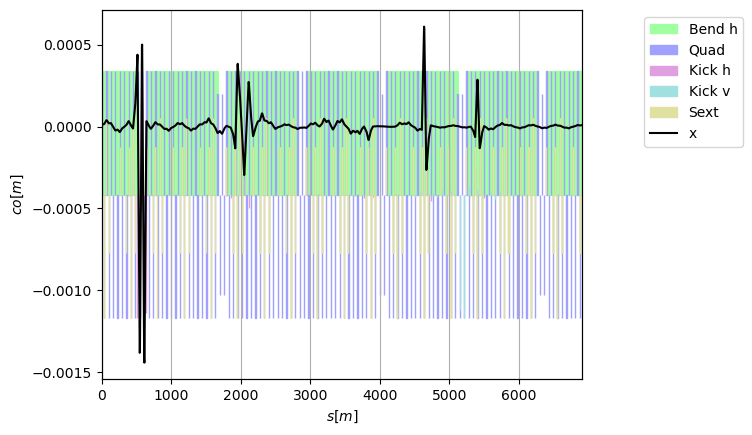

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.28090324087484
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.812e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.07 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 84.4s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'vcak.21101.a_aper': 17, 'vtto.31105.a_aper': 13, 'vcak.51101.a_aper': 4, 'vcak.52501.a_aper': 6, 'vcak.61101.a_aper': 60}


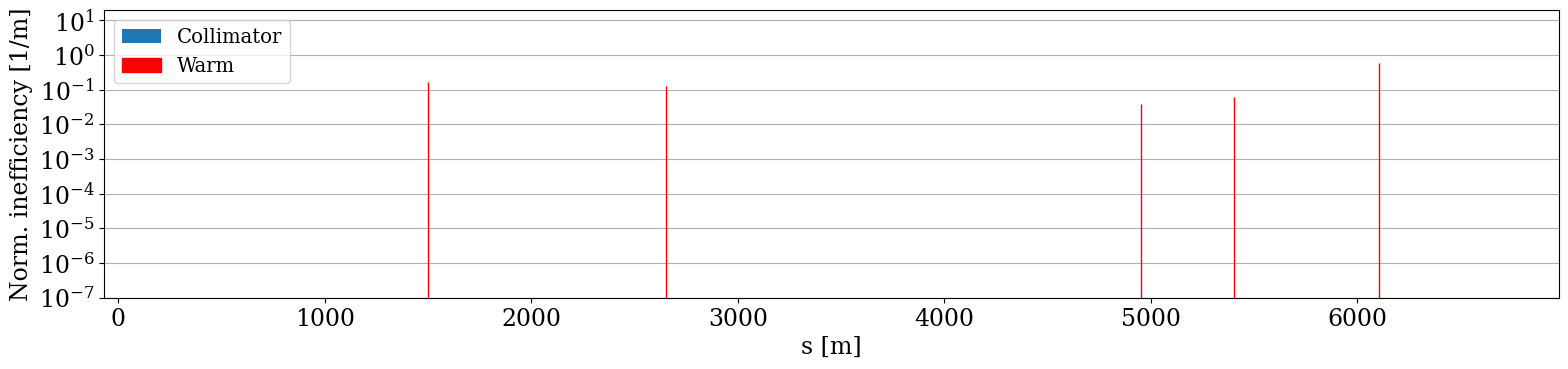

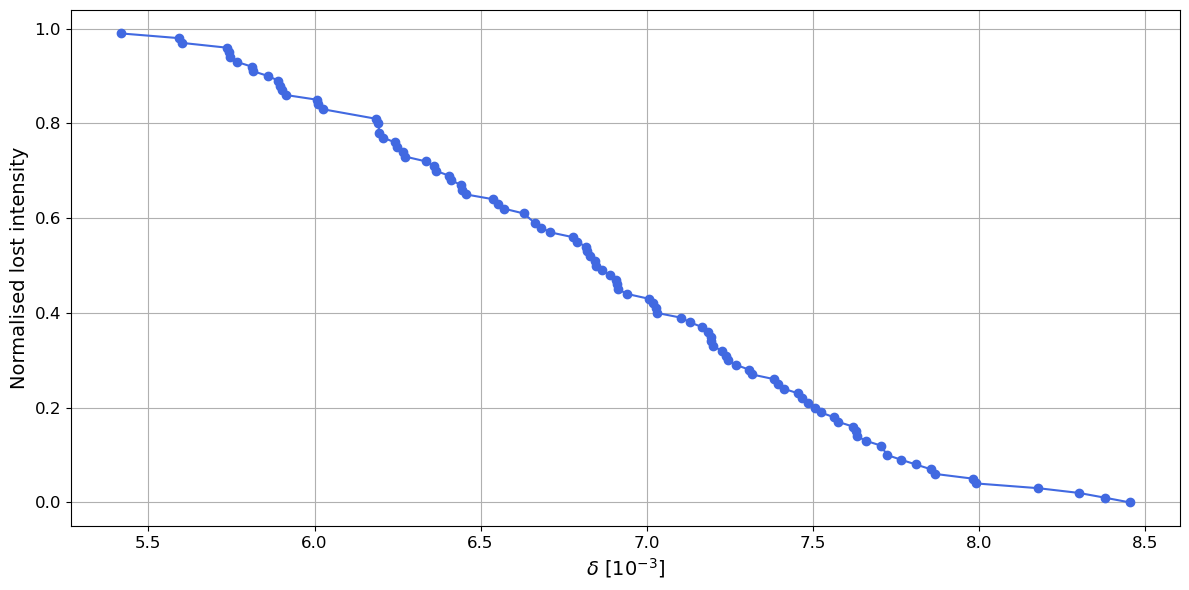

##################################
qd.50110 0.004
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 7.98e-03 -> 2.86e-04, y_rms: 9.79e-05 -> 4.64e-05
Iteration 1, x_rms: 2.86e-04 -> 2.47e-04, y_rms: 4.64e-05 -> 2.60e-05
Iteration 2, x_rms: 2.47e-04 -> 2.14e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 2.14e-04 -> 1.96e-04, y_rms: 2.15e-05 -> 2.01e-05
Iteration 4, x_rms: 1.96e-04 -> 1.62e-04, y_rms: 2.01e-05 -> 1.91e-05
Iteration 5, x_rms: 1.62e-04 -> 1.59e-04, y_rms: 1.91e-05 -> 1.69e-05
Iteration 6, x_rms: 1.59e-04 -> 1.53e-04, y_rms: 1.69e-05 -> 1.62e-05
Iteration 7, x_rms: 1.53e-04 -> 1.51e-04, y_rms: 1.62e-05 -> 1.33e-05
Iteration 8, x_rms: 1.51e-04 -> 1.49e-04, y_rms: 1.33e-05 -> 1.19e-05
Iteration 9, x_rms: 1.49e-04 -> 1.47e-04, y_rms: 1.19e-05 -> 1.07e-05


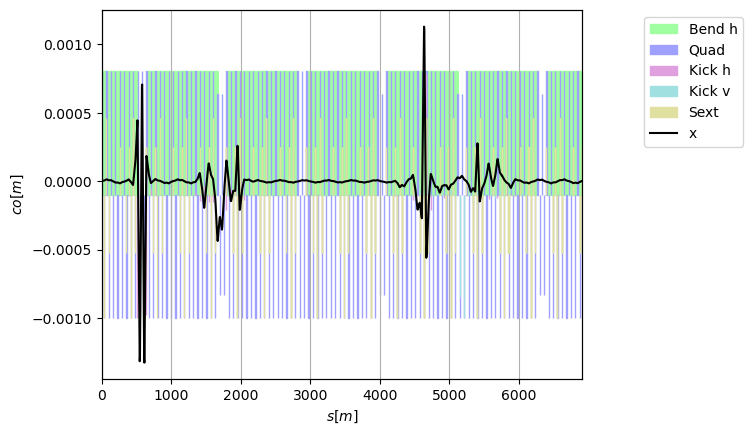

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28089283574569524
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.15 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 91.1s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'sps$start': 1, 'vcak.21101.a_aper': 10, 'vtto.31105.a_aper': 8, 'veqd.50110.a_aper': 4, 'vcak.51101.a_aper': 1, 'vcak.52501.a_aper': 10, 'vcak.61101.a_aper': 66}


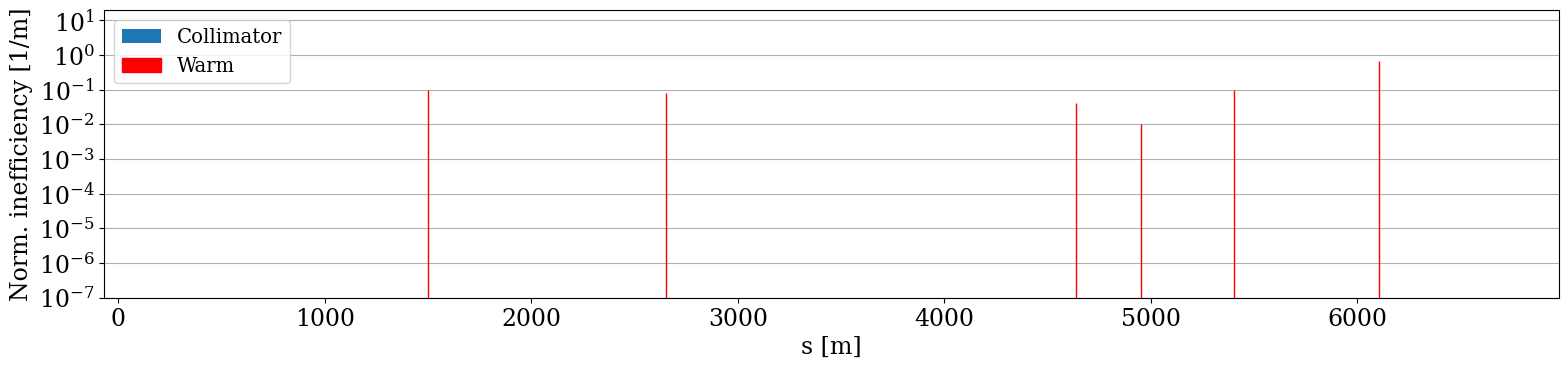

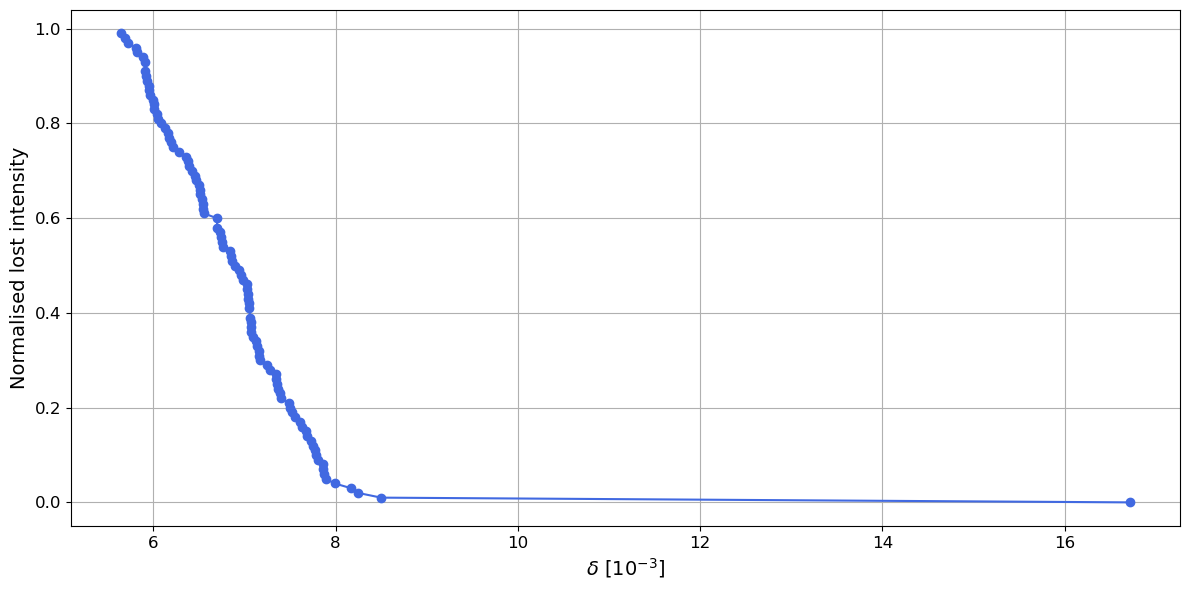

##################################
qd.50110 0.006
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.11e-02 -> 3.83e-04, y_rms: 9.80e-05 -> 4.65e-05
Iteration 1, x_rms: 3.83e-04 -> 2.89e-04, y_rms: 4.65e-05 -> 2.60e-05
Iteration 2, x_rms: 2.89e-04 -> 2.28e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 2.28e-04 -> 2.01e-04, y_rms: 2.15e-05 -> 1.91e-05
Iteration 4, x_rms: 2.01e-04 -> 1.88e-04, y_rms: 1.91e-05 -> 1.62e-05
Iteration 5, x_rms: 1.88e-04 -> 1.78e-04, y_rms: 1.62e-05 -> 1.42e-05
Iteration 6, x_rms: 1.78e-04 -> 1.76e-04, y_rms: 1.42e-05 -> 1.22e-05
Iteration 7, x_rms: 1.76e-04 -> 1.75e-04, y_rms: 1.22e-05 -> 1.11e-05
Iteration 8, x_rms: 1.75e-04 -> 1.74e-04, y_rms: 1.11e-05 -> 1.05e-05
Iteration 9, x_rms: 1.74e-04 -> 1.74e-04, y_rms: 1.05e-05 -> 1.01e-05


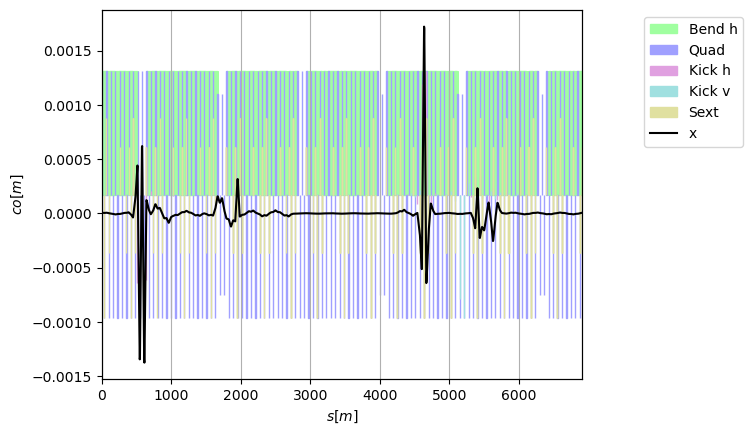

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.2808869256943017
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.19 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 79.0s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


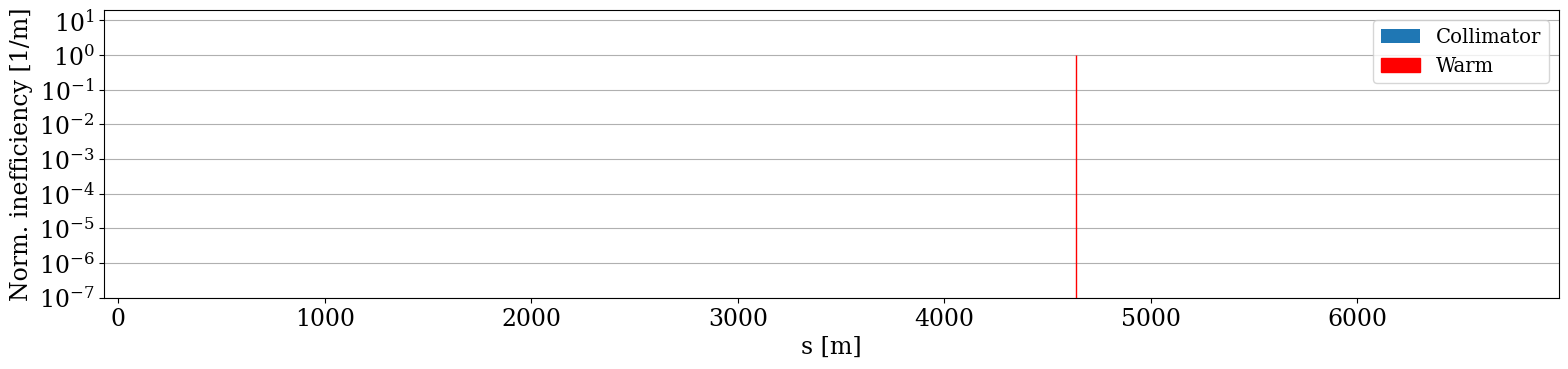

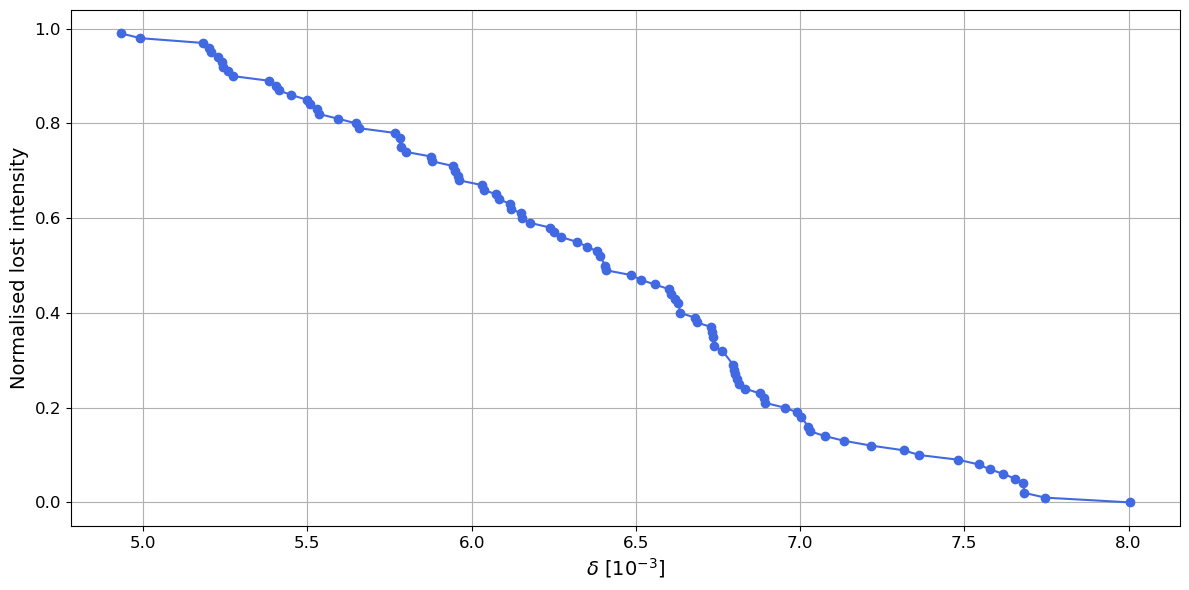

##################################
qd.50110 0.008
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.44e-02 -> 5.21e-04, y_rms: 9.81e-05 -> 4.65e-05
Iteration 1, x_rms: 5.21e-04 -> 3.25e-04, y_rms: 4.65e-05 -> 2.60e-05
Iteration 2, x_rms: 3.25e-04 -> 2.63e-04, y_rms: 2.60e-05 -> 2.15e-05
Iteration 3, x_rms: 2.63e-04 -> 2.43e-04, y_rms: 2.15e-05 -> 2.01e-05
Iteration 4, x_rms: 2.43e-04 -> 2.26e-04, y_rms: 2.01e-05 -> 1.91e-05
Iteration 5, x_rms: 2.26e-04 -> 2.19e-04, y_rms: 1.91e-05 -> 1.69e-05
Iteration 6, x_rms: 2.19e-04 -> 2.15e-04, y_rms: 1.69e-05 -> 1.62e-05
Iteration 7, x_rms: 2.15e-04 -> 2.14e-04, y_rms: 1.62e-05 -> 1.33e-05
Iteration 8, x_rms: 2.14e-04 -> 2.14e-04, y_rms: 1.33e-05 -> 1.19e-05
Iteration 9, x_rms: 2.14e-04 -> 2.12e-04, y_rms: 1.19e-05 -> 1.07e-05


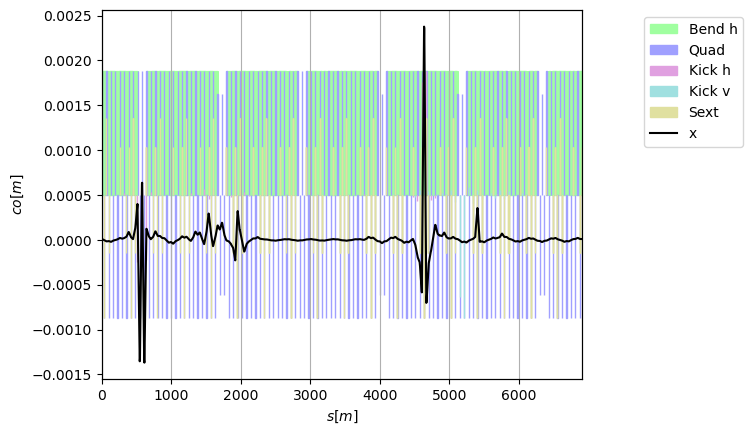

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.2808897421222859
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.17 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 68.7s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


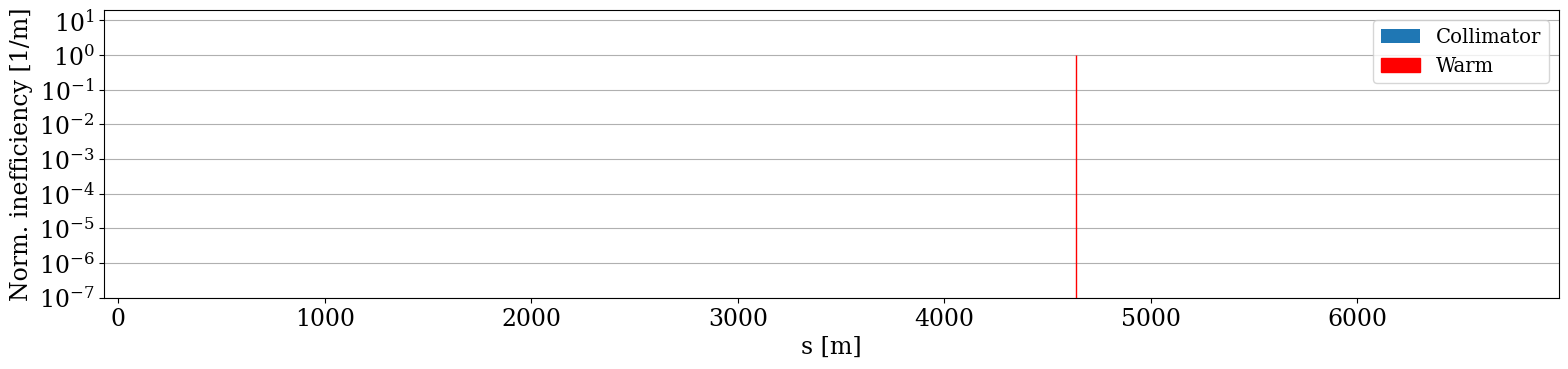

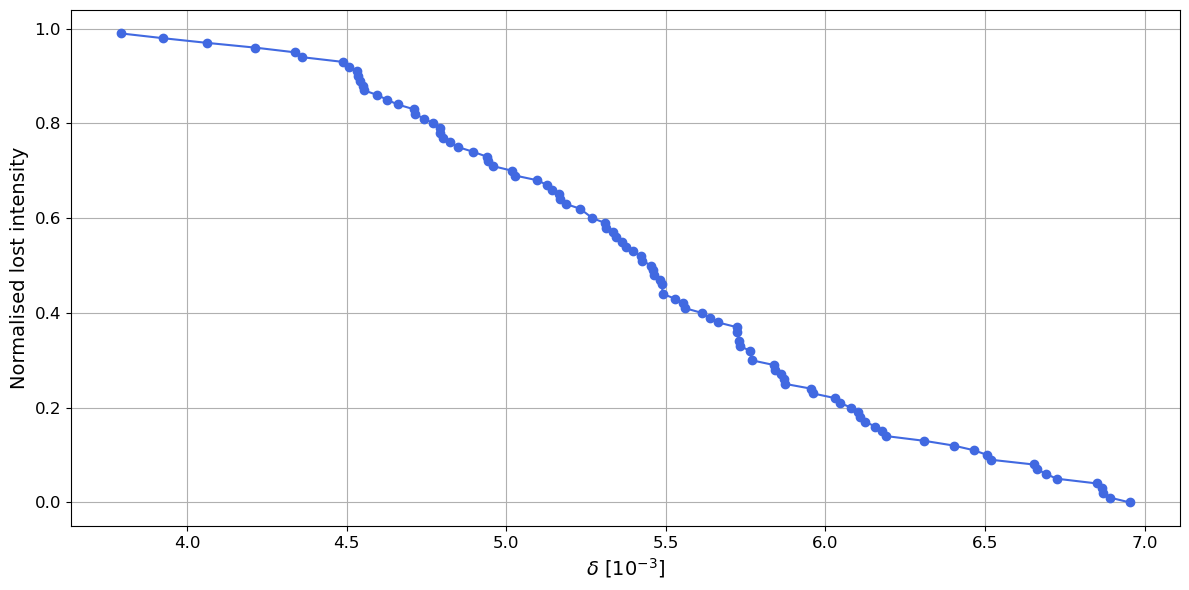

##################################
qd.50110 0.01
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 1.77e-02 -> 6.28e-04, y_rms: 9.82e-05 -> 4.66e-05
Iteration 1, x_rms: 6.28e-04 -> 3.26e-04, y_rms: 4.66e-05 -> 3.03e-05
Iteration 2, x_rms: 3.26e-04 -> 2.67e-04, y_rms: 3.03e-05 -> 2.73e-05
Iteration 3, x_rms: 2.67e-04 -> 2.58e-04, y_rms: 2.73e-05 -> 2.36e-05
Iteration 4, x_rms: 2.58e-04 -> 2.55e-04, y_rms: 2.36e-05 -> 2.14e-05
Iteration 5, x_rms: 2.55e-04 -> 2.54e-04, y_rms: 2.14e-05 -> 1.72e-05
Iteration 6, x_rms: 2.54e-04 -> 2.53e-04, y_rms: 1.72e-05 -> 1.36e-05
Iteration 7, x_rms: 2.53e-04 -> 2.51e-04, y_rms: 1.36e-05 -> 1.06e-05
Iteration 8, x_rms: 2.51e-04 -> 2.49e-04, y_rms: 1.06e-05 -> 9.05e-06
Iteration 9, x_rms: 2.49e-04 -> 2.48e-04, y_rms: 9.05e-06 -> 8.27e-06


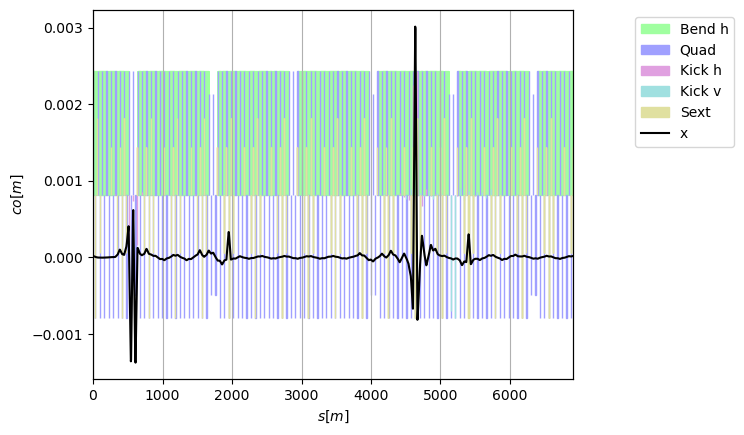

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28088154370145735
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32246 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.23 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 64.5s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


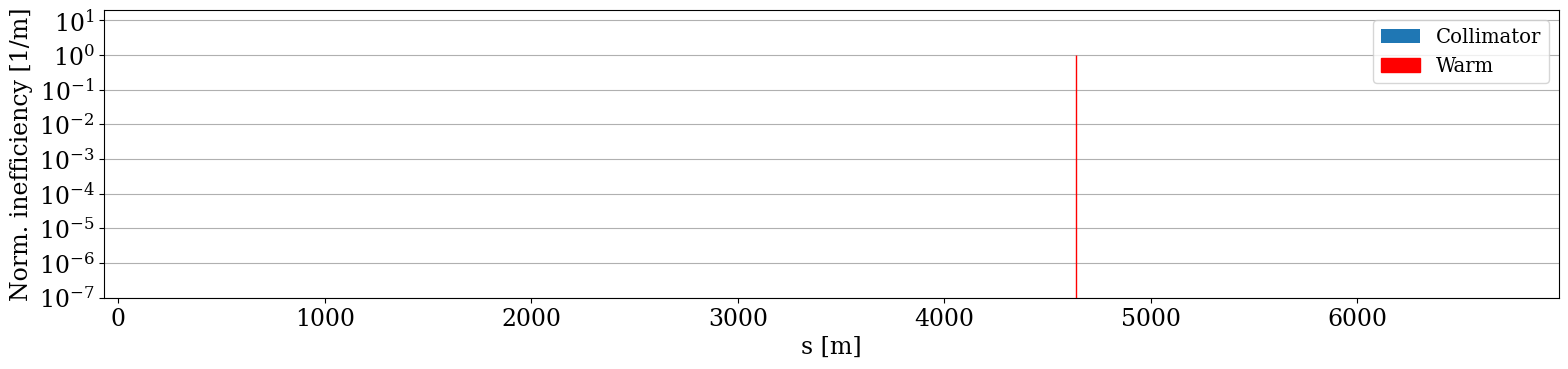

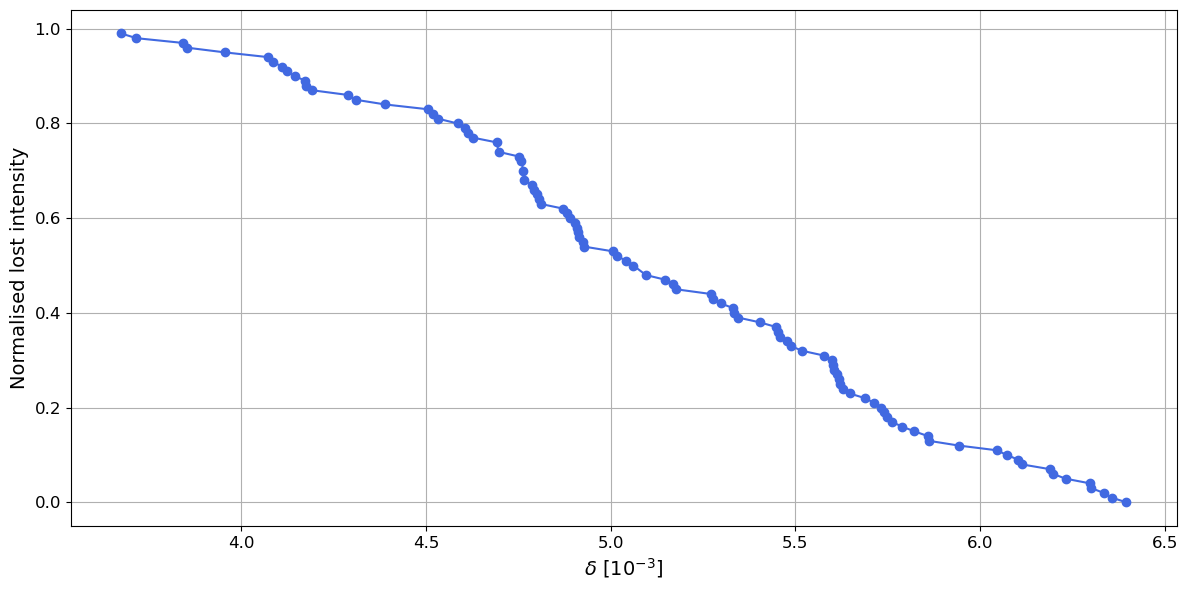

##################################
qd.50110 0.012
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.11e-02 -> 9.79e-04, y_rms: 9.83e-05 -> 2.06e-05
Iteration 1, x_rms: 9.79e-04 -> 3.83e-04, y_rms: 2.06e-05 -> 1.11e-05
Iteration 2, x_rms: 3.83e-04 -> 3.16e-04, y_rms: 1.11e-05 -> 8.35e-06
Iteration 3, x_rms: 3.16e-04 -> 3.11e-04, y_rms: 8.35e-06 -> 7.53e-06
Iteration 4, x_rms: 3.11e-04 -> 2.99e-04, y_rms: 7.53e-06 -> 6.81e-06
Iteration 5, x_rms: 2.99e-04 -> 2.96e-04, y_rms: 6.81e-06 -> 6.43e-06
Iteration 6, x_rms: 2.96e-04 -> 2.95e-04, y_rms: 6.43e-06 -> 6.15e-06
Iteration 7, x_rms: 2.95e-04 -> 2.95e-04, y_rms: 6.15e-06 -> 5.74e-06
Iteration 8, x_rms: 2.95e-04 -> 2.94e-04, y_rms: 5.74e-06 -> 5.26e-06
Iteration 9, x_rms: 2.94e-04 -> 2.90e-04, y_rms: 5.26e-06 -> 4.62e-06


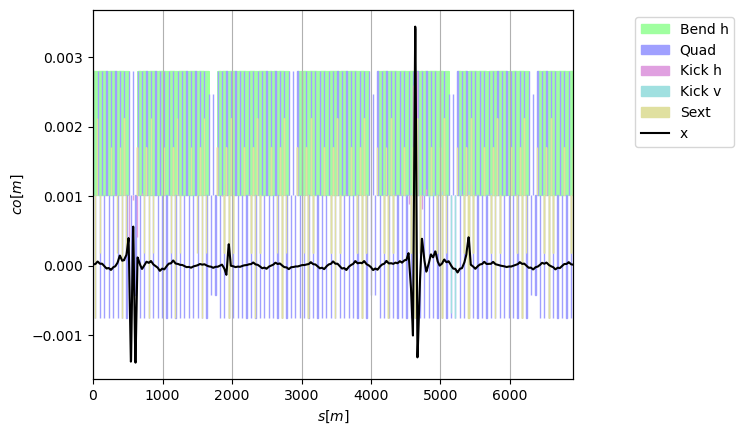

*** Maximum RMS bunch length 0.23610110400434295m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004854
--> Emittance: 0.28087398008230663
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.29 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 57.2s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


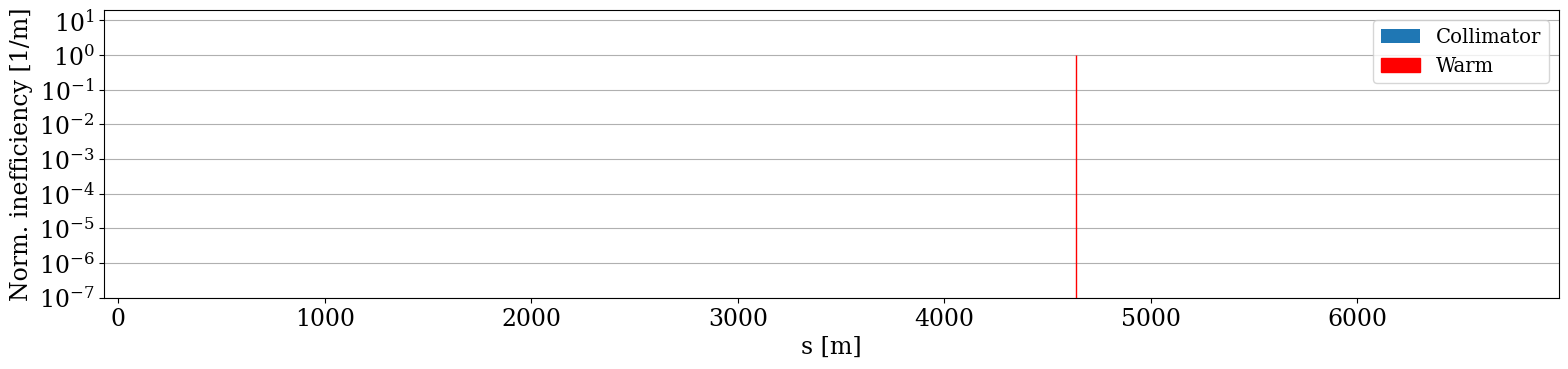

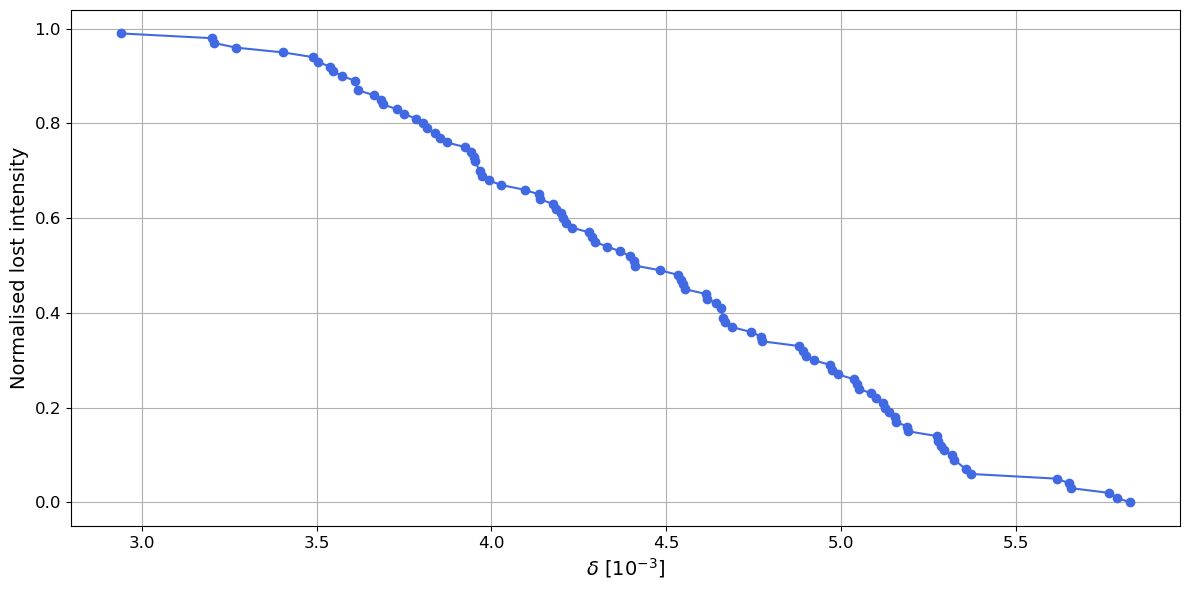

##################################
qd.50110 0.014
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.45e-02 -> 9.51e-04, y_rms: 9.84e-05 -> 2.08e-05
Iteration 1, x_rms: 9.51e-04 -> 4.44e-04, y_rms: 2.08e-05 -> 1.10e-05
Iteration 2, x_rms: 4.44e-04 -> 3.81e-04, y_rms: 1.10e-05 -> 8.33e-06
Iteration 3, x_rms: 3.81e-04 -> 3.70e-04, y_rms: 8.33e-06 -> 7.45e-06
Iteration 4, x_rms: 3.70e-04 -> 3.54e-04, y_rms: 7.45e-06 -> 6.99e-06
Iteration 5, x_rms: 3.54e-04 -> 3.45e-04, y_rms: 6.99e-06 -> 6.65e-06
Iteration 6, x_rms: 3.45e-04 -> 3.42e-04, y_rms: 6.65e-06 -> 5.98e-06
Iteration 7, x_rms: 3.42e-04 -> 3.39e-04, y_rms: 5.98e-06 -> 5.82e-06
Iteration 8, x_rms: 3.39e-04 -> 3.35e-04, y_rms: 5.82e-06 -> 4.93e-06
Iteration 9, x_rms: 3.35e-04 -> 3.34e-04, y_rms: 4.93e-06 -> 4.63e-06


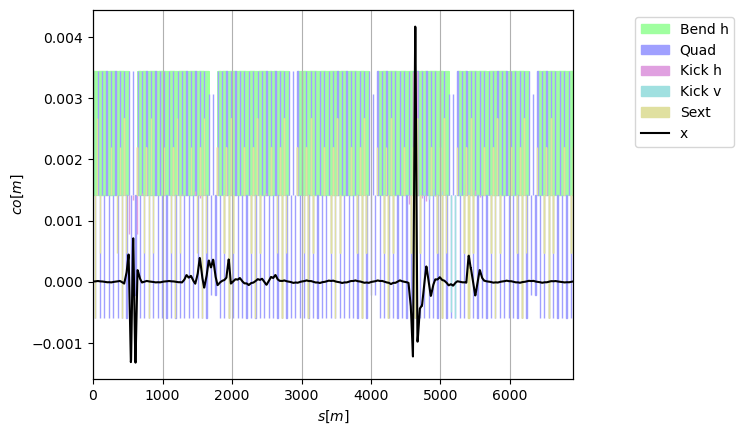

*** Maximum RMS bunch length 0.23610110400434298m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004862
--> Emittance: 0.28087265361087277
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.3 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 48.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


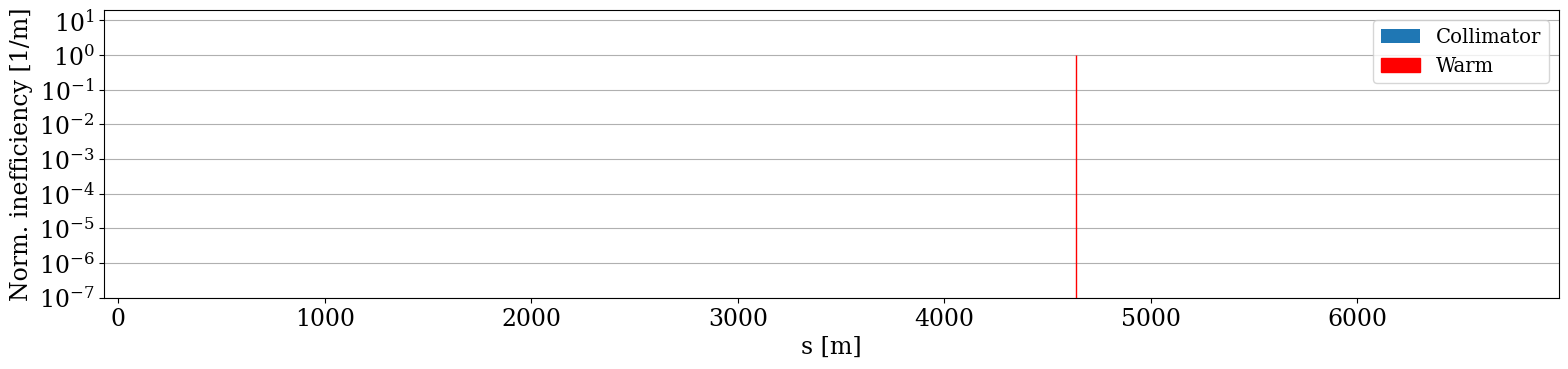

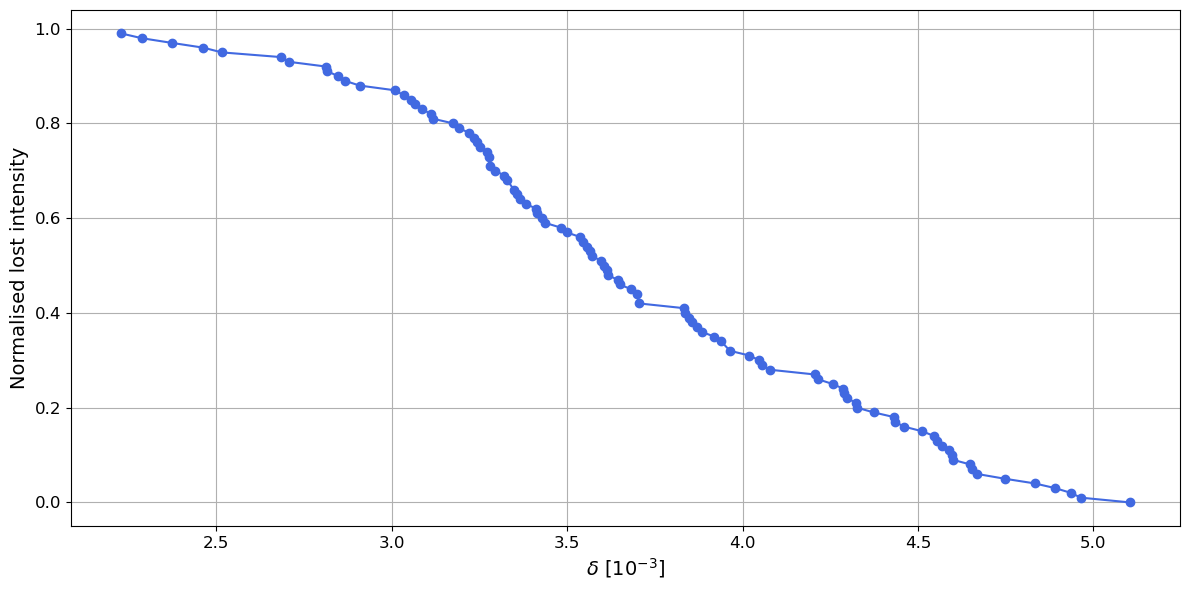

##################################
qd.50110 0.016
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 2.79e-02 -> 1.16e-03, y_rms: 9.85e-05 -> 2.10e-05
Iteration 1, x_rms: 1.16e-03 -> 4.42e-04, y_rms: 2.10e-05 -> 1.10e-05
Iteration 2, x_rms: 4.42e-04 -> 4.00e-04, y_rms: 1.10e-05 -> 8.32e-06
Iteration 3, x_rms: 4.00e-04 -> 3.93e-04, y_rms: 8.32e-06 -> 7.51e-06
Iteration 4, x_rms: 3.93e-04 -> 3.81e-04, y_rms: 7.51e-06 -> 6.78e-06
Iteration 5, x_rms: 3.81e-04 -> 3.80e-04, y_rms: 6.78e-06 -> 6.39e-06
Iteration 6, x_rms: 3.80e-04 -> 3.74e-04, y_rms: 6.39e-06 -> 6.11e-06
Iteration 7, x_rms: 3.74e-04 -> 3.72e-04, y_rms: 6.11e-06 -> 5.71e-06
Iteration 8, x_rms: 3.72e-04 -> 3.72e-04, y_rms: 5.71e-06 -> 5.52e-06
Iteration 9, x_rms: 3.72e-04 -> 3.71e-04, y_rms: 5.52e-06 -> 4.80e-06


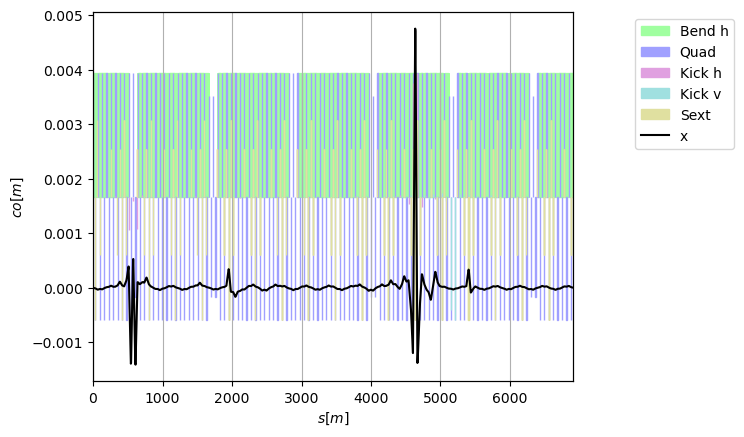

*** Maximum RMS bunch length 0.23610110400434292m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004868
--> Emittance: 0.28086142682879833
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.38 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 41.7s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


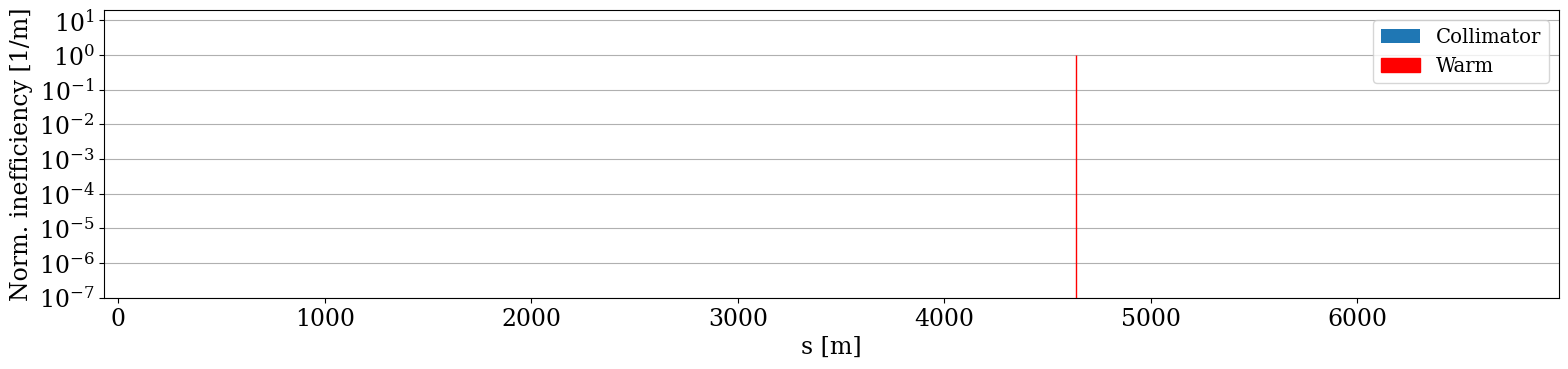

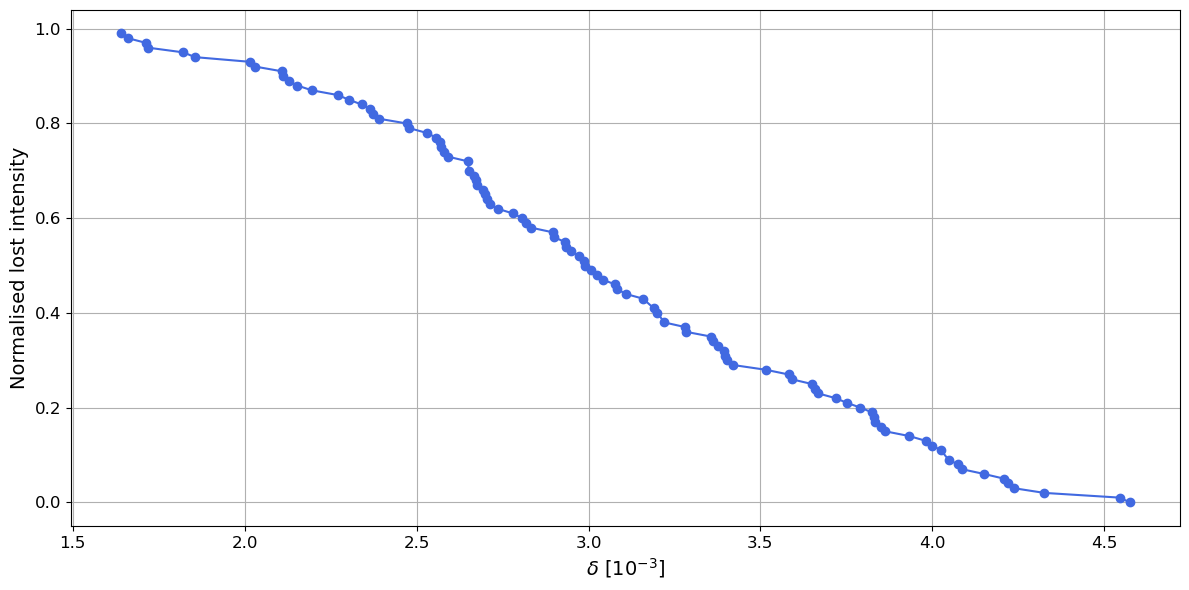

##################################
qd.50110 0.018000000000000002
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.14e-02 -> 1.40e-03, y_rms: 9.87e-05 -> 2.12e-05
Iteration 1, x_rms: 1.40e-03 -> 4.89e-04, y_rms: 2.12e-05 -> 1.10e-05
Iteration 2, x_rms: 4.89e-04 -> 4.71e-04, y_rms: 1.10e-05 -> 8.30e-06
Iteration 3, x_rms: 4.71e-04 -> 4.42e-04, y_rms: 8.30e-06 -> 7.49e-06
Iteration 4, x_rms: 4.42e-04 -> 4.38e-04, y_rms: 7.49e-06 -> 7.02e-06
Iteration 5, x_rms: 4.38e-04 -> 4.32e-04, y_rms: 7.02e-06 -> 5.97e-06
Iteration 6, x_rms: 4.32e-04 -> 4.26e-04, y_rms: 5.97e-06 -> 5.35e-06
Iteration 7, x_rms: 4.26e-04 -> 4.24e-04, y_rms: 5.35e-06 -> 4.66e-06
Iteration 8, x_rms: 4.24e-04 -> 4.24e-04, y_rms: 4.66e-06 -> 4.26e-06
Iteration 9, x_rms: 4.24e-04 -> 4.24e-04, y_rms: 4.26e-06 -> 4.02e-06


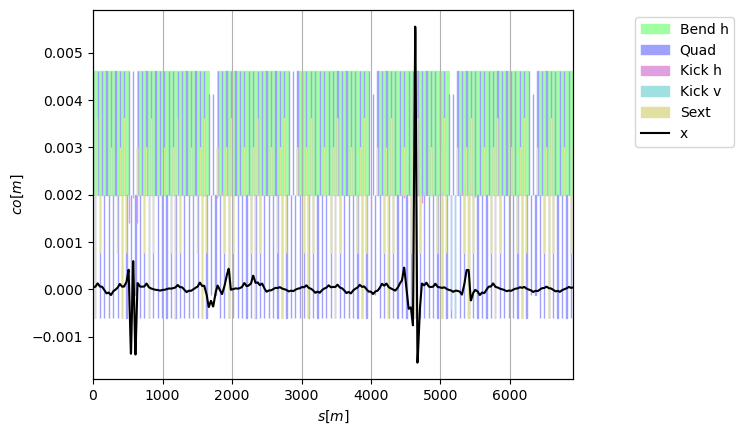

*** Maximum RMS bunch length 0.23610110400434298m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.22399999989004865
--> Emittance: 0.28086798645702066
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.33 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 34.9s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


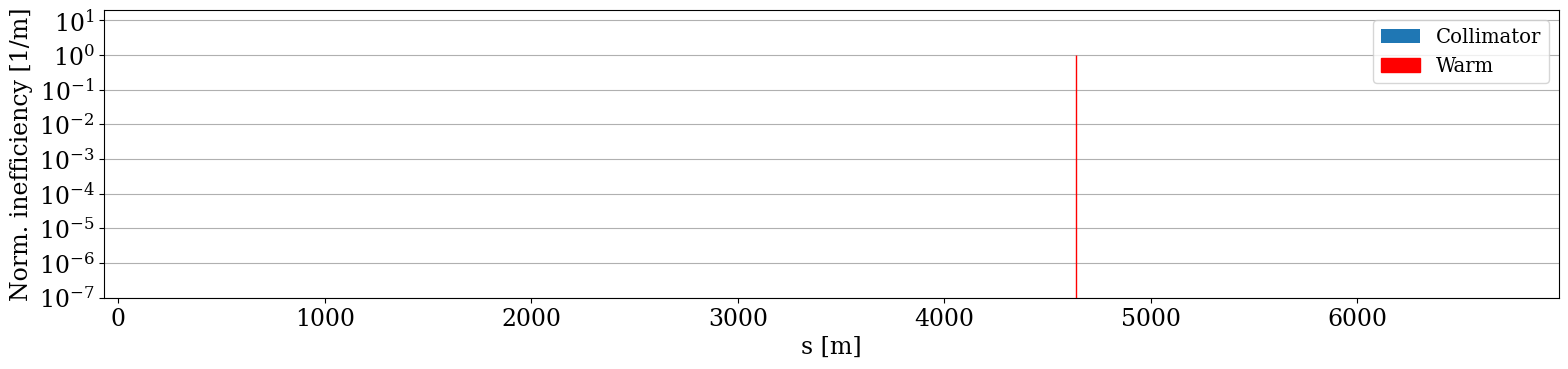

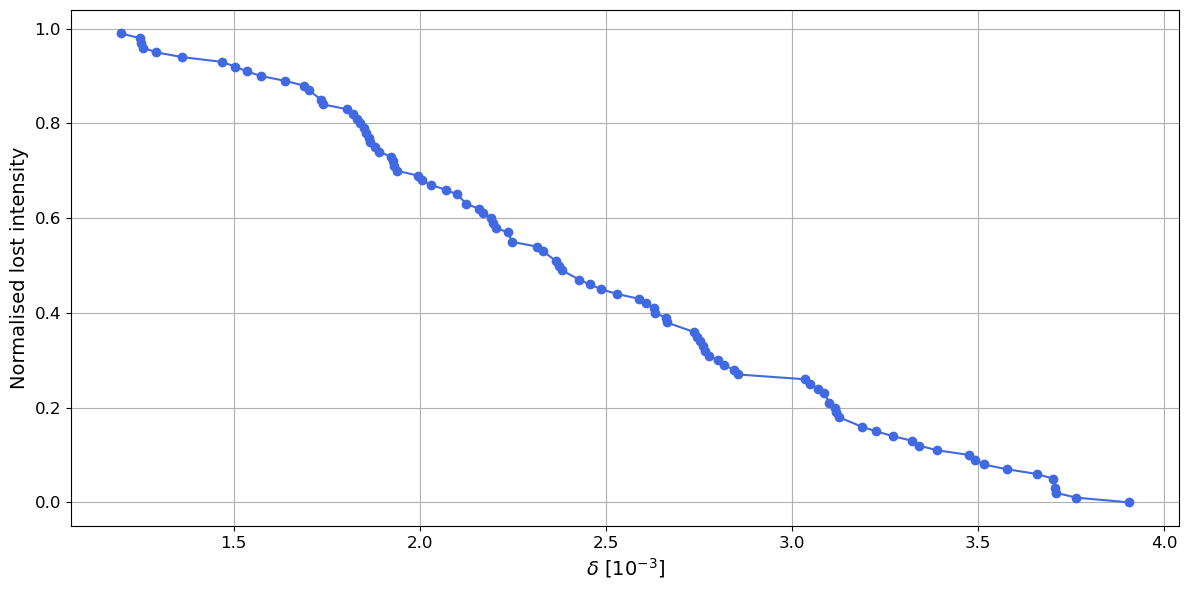

##################################
qd.50110 0.02
##################################
 
DPpos


Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           
Iteration 0, x_rms: 3.49e-02 -> 1.67e-03, y_rms: 9.88e-05 -> 2.15e-05
Iteration 1, x_rms: 1.67e-03 -> 5.29e-04, y_rms: 2.15e-05 -> 1.10e-05
Iteration 2, x_rms: 5.29e-04 -> 5.02e-04, y_rms: 1.10e-05 -> 8.29e-06
Iteration 3, x_rms: 5.02e-04 -> 4.92e-04, y_rms: 8.29e-06 -> 7.44e-06
Iteration 4, x_rms: 4.92e-04 -> 4.83e-04, y_rms: 7.44e-06 -> 6.97e-06
Iteration 5, x_rms: 4.83e-04 -> 4.79e-04, y_rms: 6.97e-06 -> 6.63e-06
Iteration 6, x_rms: 4.79e-04 -> 4.70e-04, y_rms: 6.63e-06 -> 6.17e-06
Iteration 7, x_rms: 4.70e-04 -> 4.68e-04, y_rms: 6.17e-06 -> 5.59e-06
Iteration 8, x_rms: 4.68e-04 -> 4.65e-04, y_rms: 5.59e-06 -> 5.07e-06
Iteration 9, x_rms: 4.65e-04 -> 4.65e-04, y_rms: 5.07e-06 -> 4.23e-06


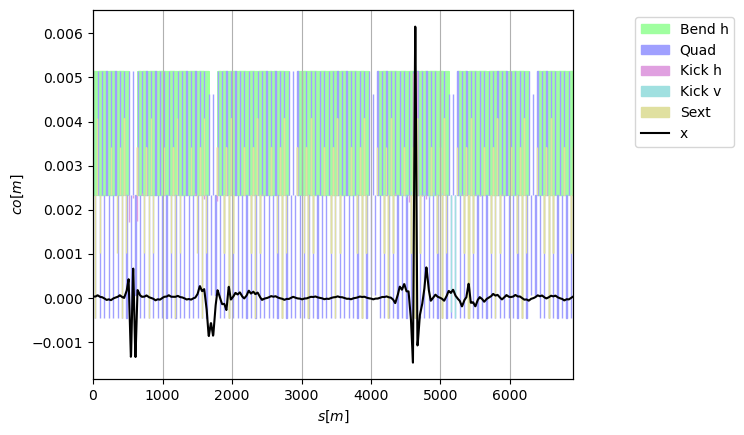

*** Maximum RMS bunch length 0.23610110400434298m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900486
--> Emittance: 0.28085545323842137
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Slicing line:   0%|          | 0/32248 [00:00<?, ?it/s]

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
Enabled time-dependent variables in the line.
The current frequency is 199999999.0Hz, adding -1.0Hz per turn.
This sweep will move the center of the bucket with Δδ = 2.811e-06 per turn.
The bucket height is 0.002994, so this implies the sweep will shift one bucket every 2130.43 turns.
No xcoll elements found in line.


Tracking:   0%|          | 0/6000 [00:00<?, ?it/s]

No xcoll elements found in line.
Done sweeping RF in 26.8s.
Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.
{'veqd.50110.a_aper': 100}


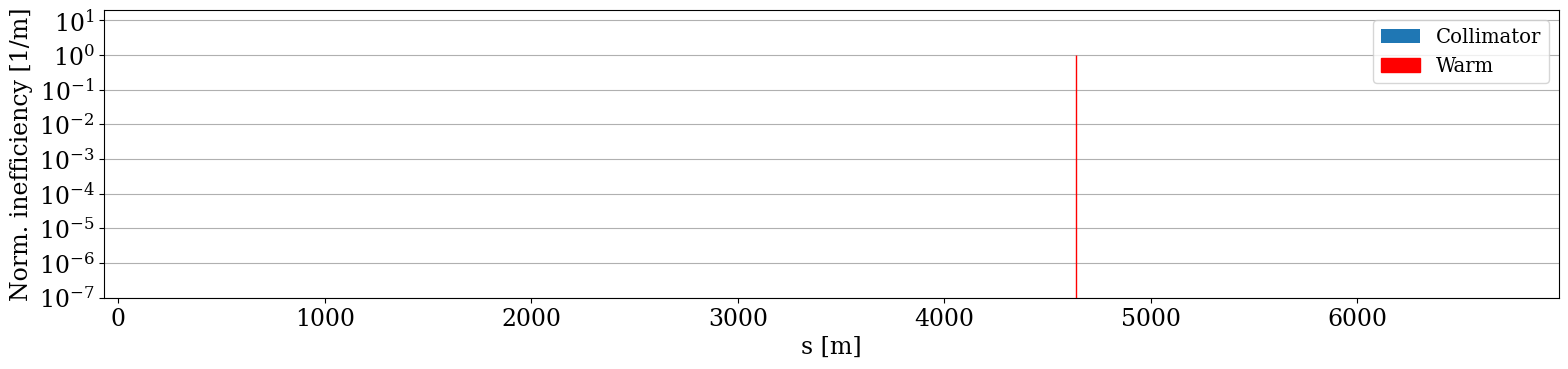

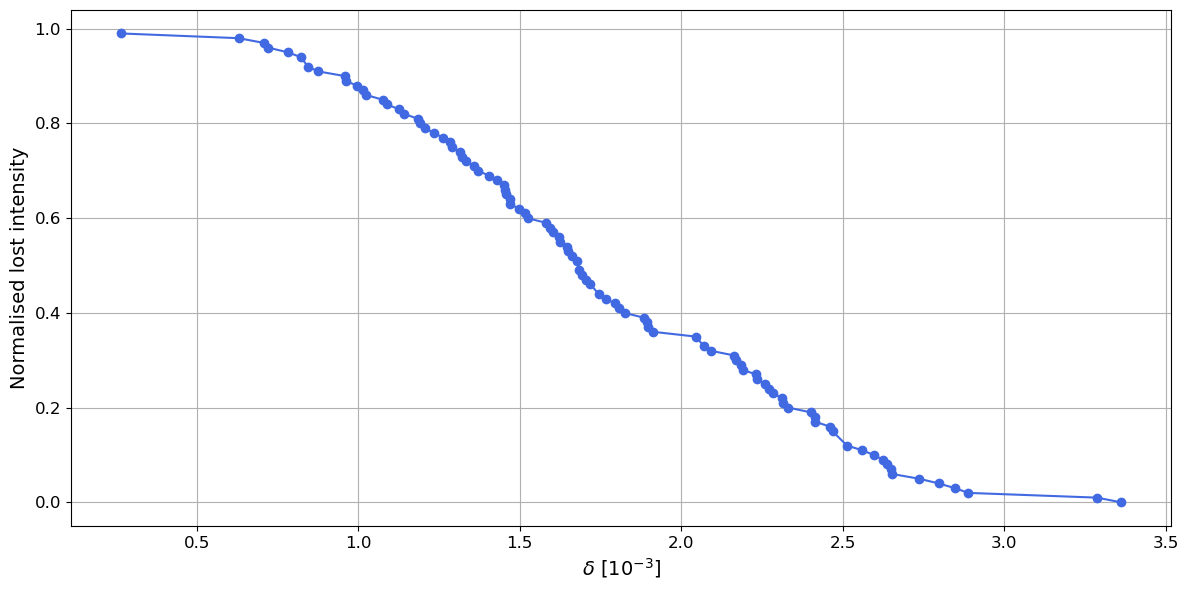

In [ ]:
case = 'case7'
for quad in ['qd.20110', 'qd.31110', 'qd.50110']:
    bumps = np.linspace(0, 20e-3, 11)#np.linspace(-20e-3, 0, 11)
    dir = Path(f'/Users/lisepauwels/sps_simulations/Prototyping/20251017/results/optimised_apertures/{quad}/')
    for bump in bumps:
          print('##################################')
          print(quad, bump)
          print('##################################')
          print(' ')
          
          sim_name = f'bump_{bump*1e3:.0f}mm'
          num_particles = 100
          num_turns = 6000
          sweep = 6000

          for plane in ['DPpos']:#['DPneg', 'DPpos']:
               print(plane)
               line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta4.json')
               #orbit correction
               tw_ref = line.twiss4d()
               tt = line.get_table()
               tt_monitors = tt.rows['bp.*'].rows['.*(?<!_entry)$'].rows['.*(?<!_exit)$']
               line.steering_monitors_x = tt_monitors.name
               line.steering_monitors_y = tt_monitors.name

               tt_h_correctors = tt.rows['mdh\..*'].rows['.*h\..*']
               mask_ap_h = np.array([el.startswith('Limit') for el in tt_h_correctors.element_type])
               line.steering_correctors_x = tt_h_correctors.name[~mask_ap_h]

               tt_v_correctors = tt.rows['mdv\..*'].rows['.*v\..*']
               mask_ap_v = np.array([el.startswith('Limit') for el in tt_v_correctors.element_type])
               line.steering_correctors_y = tt_v_correctors.name[~mask_ap_v]

               line['qd.52510'].shift_x = 1e-3
               line['qd.22510'].shift_x = 1e-3
               line[f'{quad}'].shift_x = bump

               tw_before = line.twiss4d()
               orbit_correction = line.correct_trajectory(twiss_table=tw_ref,n_micado=5, n_iter=10)
               tw_after = line.twiss4d()
               plt.close('all')
               tw_after.plot('x')
               plt.show()

               remove_offmom_bpms_apers(line, exn=3.5e-6, nrj=21, pmass=0.938, bucket_height=3e-3, n_buckets=2)

               context = xo.ContextCpu()
               line.vars['qph_setvalue'] = 0.5
               line.vars['qpv_setvalue'] = 0.5
               line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
               line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05

               cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

               for name in cavity_names:
                   line[name].frequency = 200e6
                   line[name].lag = 180
               line['acl.31735'].voltage = 0 #setting 800 cav to 0V
               line['actcse.31632'].voltage = 3.0e6

               for ele, s in cases[case].items():
                   line[ele].shift_x += s

               for ele in [f'veqd.{quad.split('.')[-1]}.a_aper', f'veqd.{quad.split('.')[-1]}.b_aper']:
                   line[ele].shift_x -= bump

               SL = SweepLosses(line, sweep=sweep, plane=plane, num_turns=num_turns, num_particles=num_particles, nemitt_x=2e-6, nemitt_y=2e-6, result_name=f'{sim_name}', dir=dir, gaussian=True)

               print(SL.aperture_losses)
               SL.plot_lossmap
               SL.intensity_loss
               

In [14]:
line.get_s_position('qd.50110')

np.float64(4636.536900000003)